# N:1 MENT — marginal projections

In [1]:
import os
import sys
import time

import numpy as np
import psdist as ps
import psdist.plot as psv
import ultraplot as plt
from tqdm.notebook import tqdm
from tqdm.notebook import trange

import ment
from ment.sim import simulate
from ment.sim import copy_diagnostics
from ment.train.plot import Plotter
from ment.train.plot import PlotDistCorner
from ment.train.plot import PlotProj1D
from ment.utils import unravel

In [2]:
plt.rc["cmap.discrete"] = False
plt.rc["cmap.sequential"] = "viridis"
plt.rc["figure.facecolor"] = "white"
plt.rc["grid"] = False

## Settings

In [3]:
dist_name = "gaussian_mixture"
ndim = 6
xmax = 3.5
seed = 12345

## Source distribution

In [4]:
dist = ment.dist.get_dist(dist_name, ndim=ndim, seed=seed)
x_true = dist.sample(1_000_000)

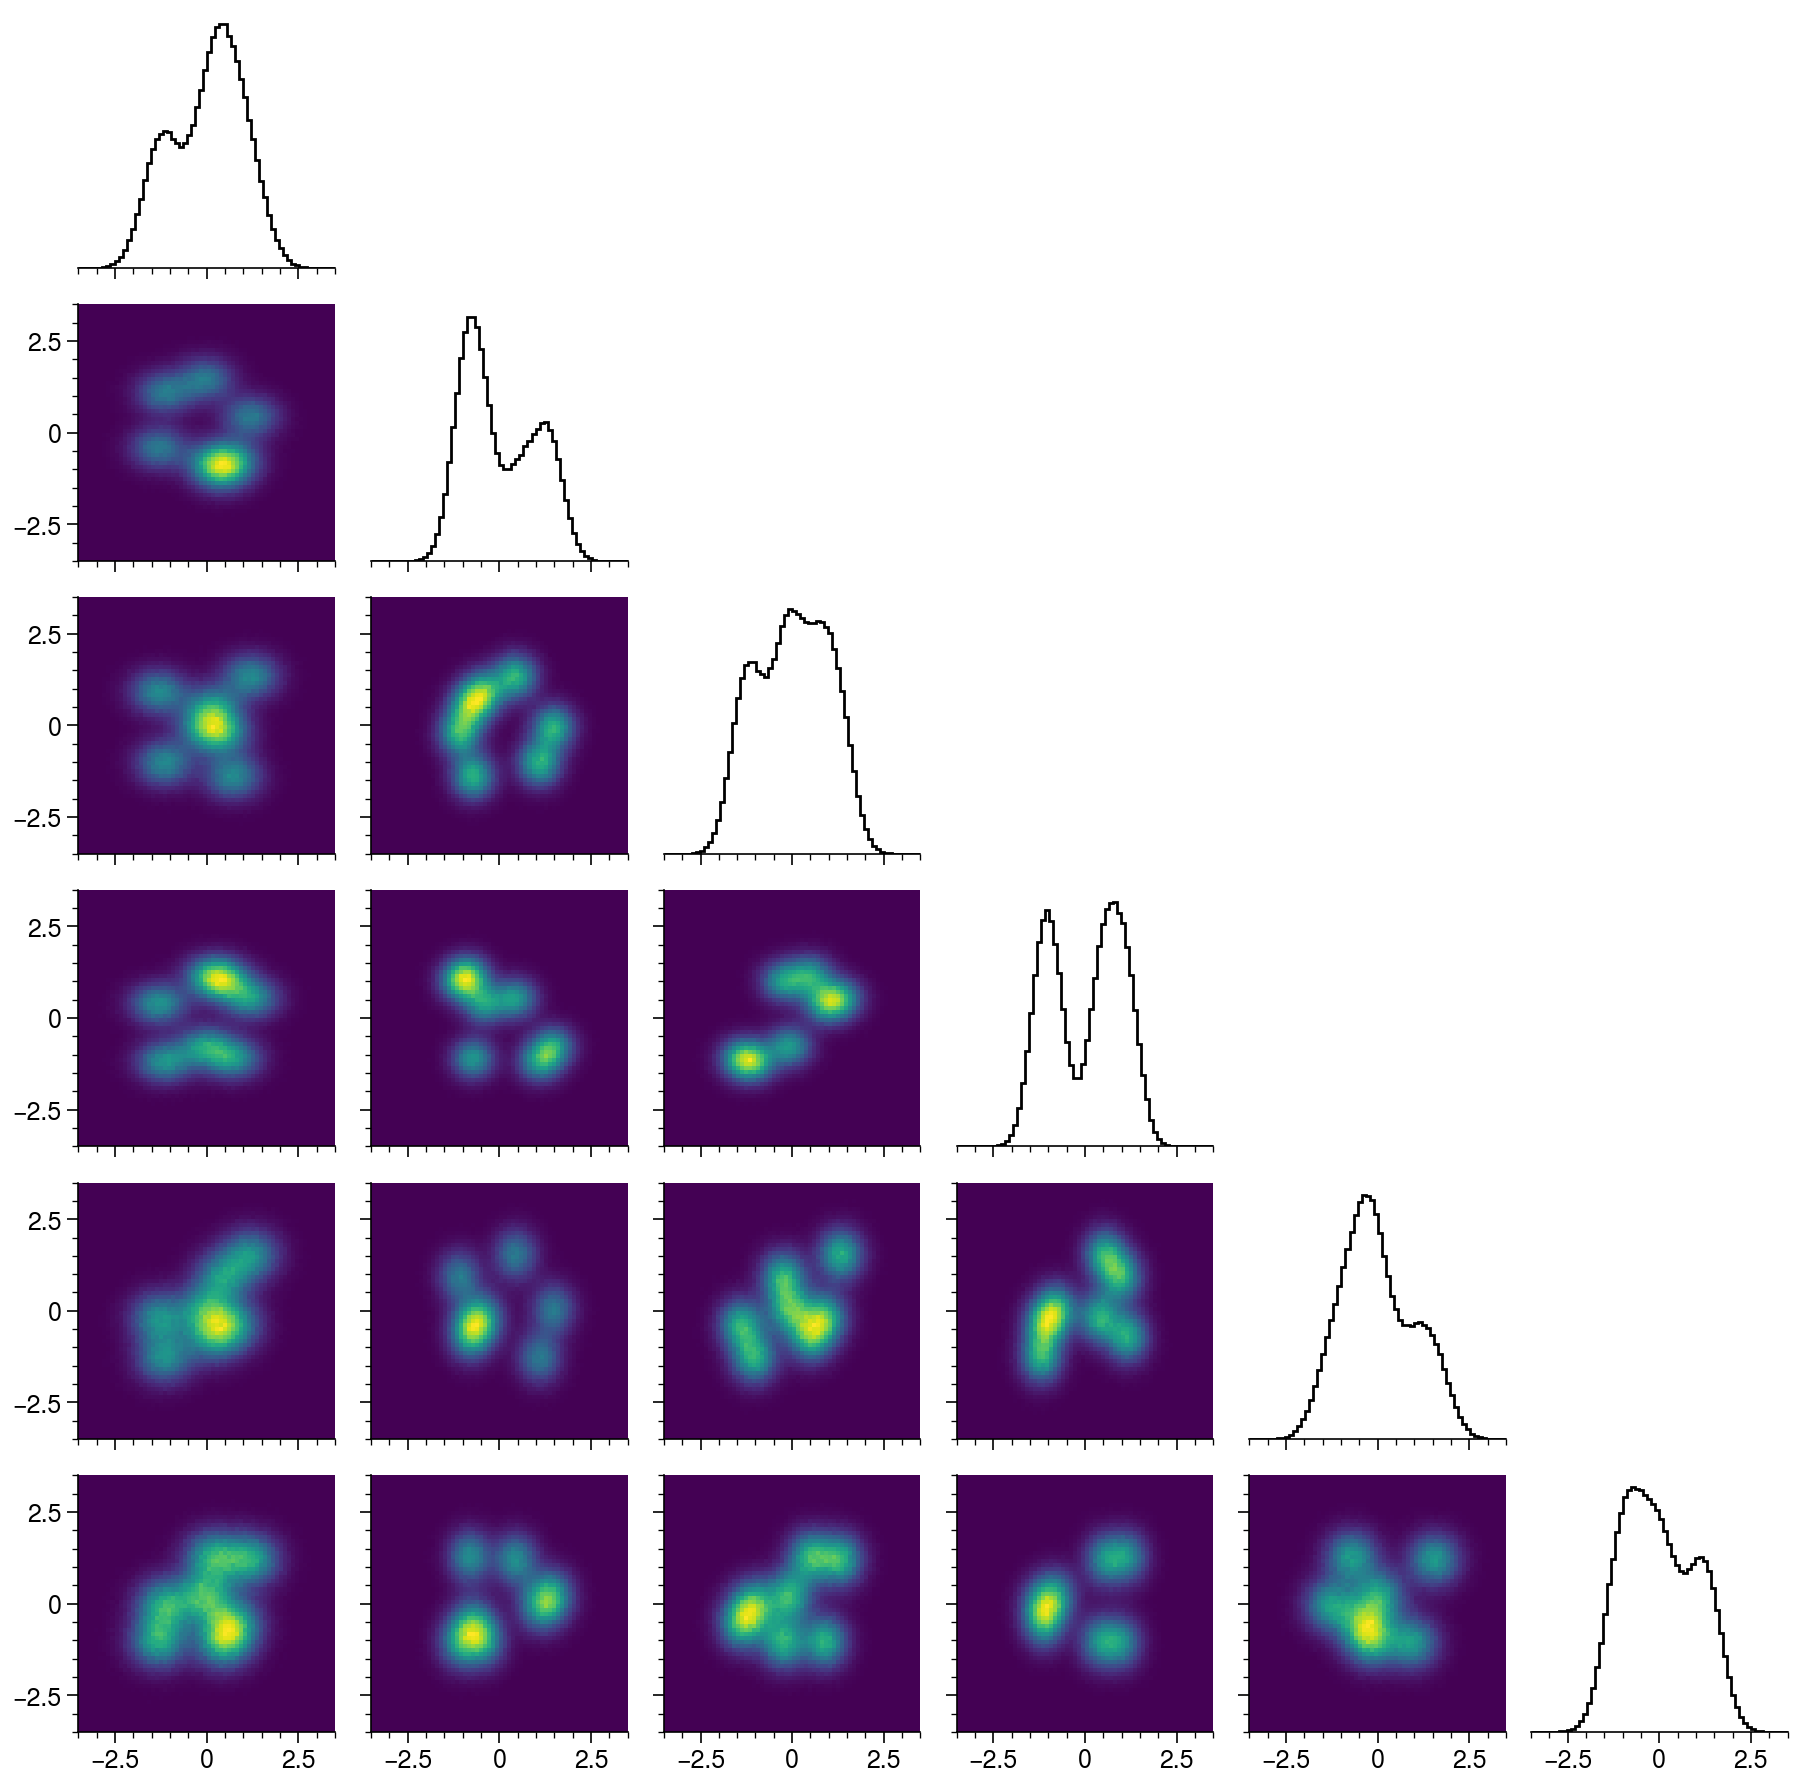

In [5]:
limits = ndim * [(-xmax, xmax)]

grid = psv.CornerGrid(ndim, figwidth=(ndim * 1.5))
grid.plot_points(x_true, limits=limits, bins=64, mask=False)
plt.show()

## Data generation

In [6]:
nmeas = 10
nbins = 64
kde = False
kde_bandwidth_frac = 1.0

In [7]:
class ProjectionTransform:
    def __init__(self, direction: np.ndarray) -> None:
        self.direction = direction

    def __call__(self, x: np.ndarray) -> np.ndarray:
        return np.sum(x * self.direction, axis=1)[:, None]

In [8]:
transforms = []
directions = np.random.normal(size=(nmeas, ndim))
for direction in directions:
    direction = np.random.normal(size=ndim)
    direction = direction / np.linalg.norm(direction)
    transform = ProjectionTransform(direction)
    transforms.append(transform)

# Create histogram diagnostics
axis_proj = axis_meas = 0
bin_edges = np.linspace(-xmax, xmax, nbins + 1)

projections = []
for transform in transforms:
    projection = ment.diag.Histogram1D(
        axis=axis_meas, edges=bin_edges, kde=kde, kde_bandwidth_frac=kde_bandwidth_frac
    )
    projections.append([projection])

# Generate data.
projections = ment.sim.simulate_with_diag_update(
    x_true,
    transforms,
    projections,
    kde=False,
    blur=0.0,
)

## Reconstruction model

In [9]:
sampler = "mcmc"
nsamp = 500_000
burnin = 10_000

if sampler == "grid":
    samp_grid_res = 32
    samp_noise = 0.5
    samp_grid_shape = ndim * [samp_grid_res]
    samp_grid_limits = limits

    sampler = ment.samp.GridSampler(
        grid_limits=samp_grid_limits,
        grid_shape=samp_grid_shape,
        noise=samp_noise,
    )
elif sampler == "mcmc":
    sampler = ment.samp.MetropolisHastingsSampler(
        ndim=ndim,
        chains=248,
        proposal_cov=np.eye(ndim),
        burnin=burnin,
        shuffle=True,
        verbose=True,
    )
else:
    raise ValueError

In [10]:
prior = ment.GaussianPrior(ndim=ndim, scale=1.0)

model = ment.MENT(
    ndim=ndim,
    transforms=transforms,
    projections=projections,
    prior=prior,
    interpolation_kws=dict(method="linear"),
    sampler=sampler,
    nsamp=nsamp,
    mode="sample",
    verbose=0,
)

## Training

In [11]:
plot_nsamp = 1_000_000
plot_nbins = 64

In [12]:
def plot_model(model):
    figs = []

    # Plot reconstructed distribution.
    x_pred = model.sample(1_000_000)

    grid = psv.CornerGrid(ndim, figwidth=(ndim * 1.25), diag_shrink=0.80)
    grid.plot(
        x_pred,
        limits=limits,
        bins=65,
        mask=False,
        cmap="viridis",
    )
    figs.append(grid.fig)

    # Plot simulated vs. measured projections.
    projections_true = ment.sim.copy_histograms(model.projections)
    projections_pred = ment.sim.copy_histograms(model.diagnostics)
    projections_pred = ment.sim.simulate(x_pred, transforms, projections_pred)

    ncols = min(nmeas, 7)
    nrows = int(np.ceil(nmeas / ncols))

    for log in [False, True]:
        fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(1.5 * ncols, 1.25 * nrows))
        for index, transform in enumerate(transforms):
            projection_true = unravel(projections_true)[index]
            projection_pred = unravel(projections_pred)[index]

            scale = np.max(projection_true.values.max())

            ax = axs[index]
            ax.plot(projection_true.coords, projection_true.values / scale, color="lightgray")
            ax.plot(
                projection_pred.coords,
                projection_pred.values / scale,
                color="black",
                marker=".",
                lw=0,
                ms=1.0,
            )
            ax.format(ymax=1.25, xlim=(-xmax, xmax))
            if log:
                ax.format(yscale="log", ymax=5.0, ymin=1.00e-05, yformatter="log")
        figs.append(fig)

    return figs

non numeric history values being saved


  0%|                                                                                                                                                                           | 0/14031 [00:00<?, ?it/s]

  2%|██▋                                                                                                                                                            | 241/14031 [00:00<00:05, 2400.93it/s]

  3%|█████▍                                                                                                                                                         | 482/14031 [00:00<00:05, 2378.06it/s]

  5%|████████▏                                                                                                                                                      | 720/14031 [00:00<00:05, 2259.61it/s]

  7%|██████████▉                                                                                                                                                    | 962/14031 [00:00<00:05, 2320.52it/s]

  9%|█████████████▌                                                                                                                                                | 1202/14031 [00:00<00:05, 2346.46it/s]

 10%|████████████████▎                                                                                                                                             | 1444/14031 [00:00<00:05, 2370.89it/s]

 12%|██████████████████▉                                                                                                                                           | 1687/14031 [00:00<00:05, 2387.51it/s]

 14%|█████████████████████▋                                                                                                                                        | 1931/14031 [00:00<00:05, 2401.58it/s]

 16%|████████████████████████▌                                                                                                                                     | 2176/14031 [00:00<00:04, 2414.40it/s]

 17%|███████████████████████████▏                                                                                                                                  | 2418/14031 [00:01<00:04, 2405.69it/s]

 19%|█████████████████████████████▉                                                                                                                                | 2664/14031 [00:01<00:04, 2418.97it/s]

 21%|████████████████████████████████▊                                                                                                                             | 2909/14031 [00:01<00:04, 2427.29it/s]

 22%|███████████████████████████████████▍                                                                                                                          | 3152/14031 [00:01<00:04, 2425.00it/s]

 24%|██████████████████████████████████████▏                                                                                                                       | 3396/14031 [00:01<00:04, 2427.65it/s]

 26%|████████████████████████████████████████▉                                                                                                                     | 3639/14031 [00:01<00:04, 2427.69it/s]

 28%|███████████████████████████████████████████▋                                                                                                                  | 3883/14031 [00:01<00:04, 2430.42it/s]

 29%|██████████████████████████████████████████████▍                                                                                                               | 4127/14031 [00:01<00:04, 2430.99it/s]

 31%|█████████████████████████████████████████████████▏                                                                                                            | 4371/14031 [00:01<00:03, 2432.05it/s]

 33%|███████████████████████████████████████████████████▉                                                                                                          | 4615/14031 [00:01<00:03, 2433.55it/s]

 35%|██████████████████████████████████████████████████████▋                                                                                                       | 4860/14031 [00:02<00:03, 2436.62it/s]

 36%|█████████████████████████████████████████████████████████▍                                                                                                    | 5104/14031 [00:02<00:03, 2434.67it/s]

 38%|████████████████████████████████████████████████████████████▏                                                                                                 | 5348/14031 [00:02<00:03, 2434.72it/s]

 40%|██████████████████████████████████████████████████████████████▉                                                                                               | 5592/14031 [00:02<00:03, 2430.46it/s]

 42%|█████████████████████████████████████████████████████████████████▋                                                                                            | 5836/14031 [00:02<00:03, 2432.17it/s]

 43%|████████████████████████████████████████████████████████████████████▍                                                                                         | 6080/14031 [00:02<00:03, 2429.27it/s]

 45%|███████████████████████████████████████████████████████████████████████▏                                                                                      | 6323/14031 [00:02<00:03, 2428.16it/s]

 47%|█████████████████████████████████████████████████████████████████████████▉                                                                                    | 6567/14031 [00:02<00:03, 2429.39it/s]

 49%|████████████████████████████████████████████████████████████████████████████▋                                                                                 | 6811/14031 [00:02<00:02, 2430.05it/s]

 50%|███████████████████████████████████████████████████████████████████████████████▍                                                                              | 7055/14031 [00:02<00:02, 2432.87it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████▏                                                                           | 7299/14031 [00:03<00:02, 2431.39it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 7543/14031 [00:03<00:02, 2432.70it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 7788/14031 [00:03<00:02, 2437.57it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 8032/14031 [00:03<00:02, 2433.55it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 8276/14031 [00:03<00:02, 2426.54it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 8521/14031 [00:03<00:02, 2430.56it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 8765/14031 [00:03<00:02, 2431.24it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 9009/14031 [00:03<00:02, 2433.35it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 9253/14031 [00:03<00:01, 2434.16it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 9498/14031 [00:03<00:01, 2437.89it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 9742/14031 [00:04<00:01, 2376.91it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 9981/14031 [00:04<00:01, 2362.17it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 10225/14031 [00:04<00:01, 2382.37it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 10467/14031 [00:04<00:01, 2393.35it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 10712/14031 [00:04<00:01, 2407.75it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 10957/14031 [00:04<00:01, 2419.50it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 11202/14031 [00:04<00:01, 2428.48it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 11445/14031 [00:04<00:01, 2419.62it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 11690/14031 [00:04<00:00, 2428.24it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 11935/14031 [00:04<00:00, 2432.21it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 12179/14031 [00:05<00:00, 2432.32it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 12423/14031 [00:05<00:00, 2419.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 12667/14031 [00:05<00:00, 2424.99it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 12910/14031 [00:05<00:00, 2419.66it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 13152/14031 [00:05<00:00, 2419.55it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 13397/14031 [00:05<00:00, 2426.74it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 13642/14031 [00:05<00:00, 2432.49it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 13886/14031 [00:05<00:00, 2424.93it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:05<00:00, 2417.20it/s]

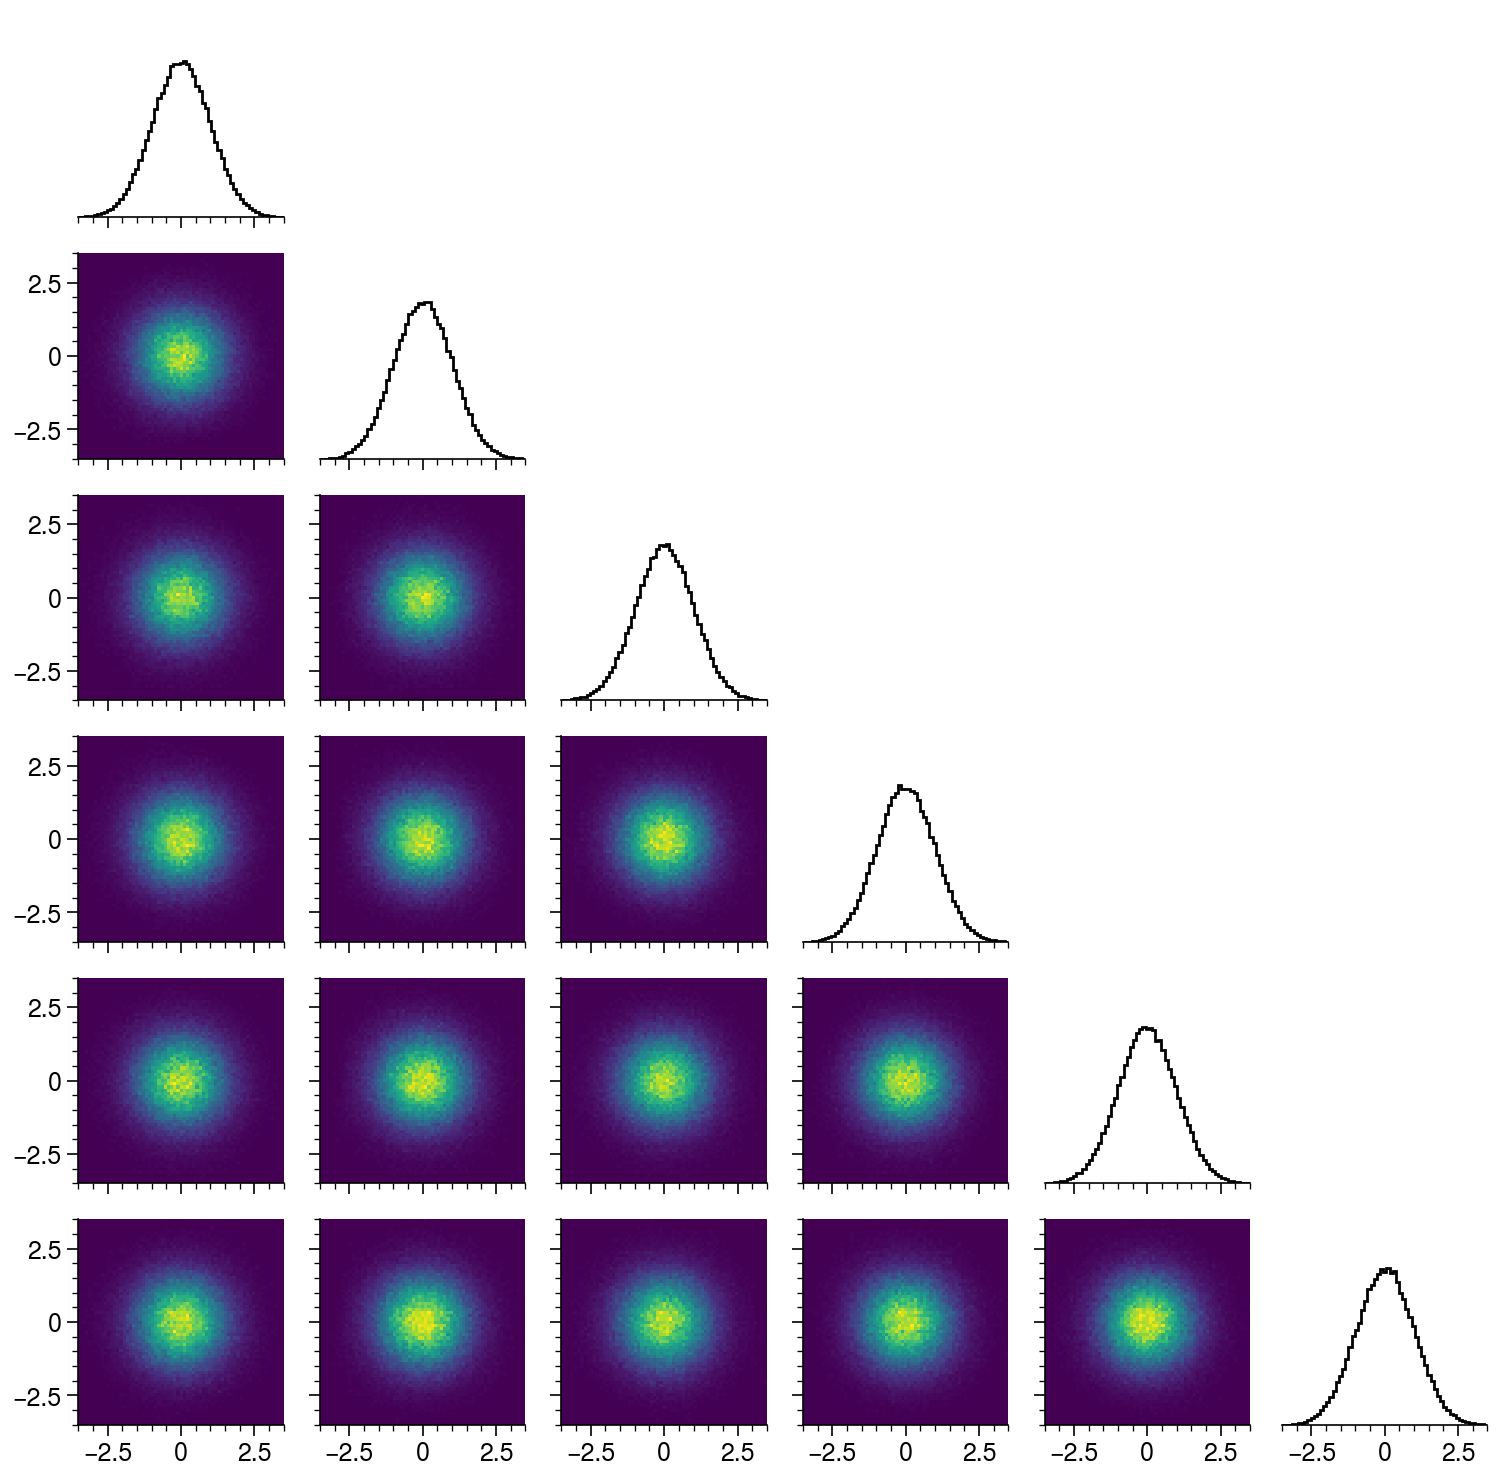

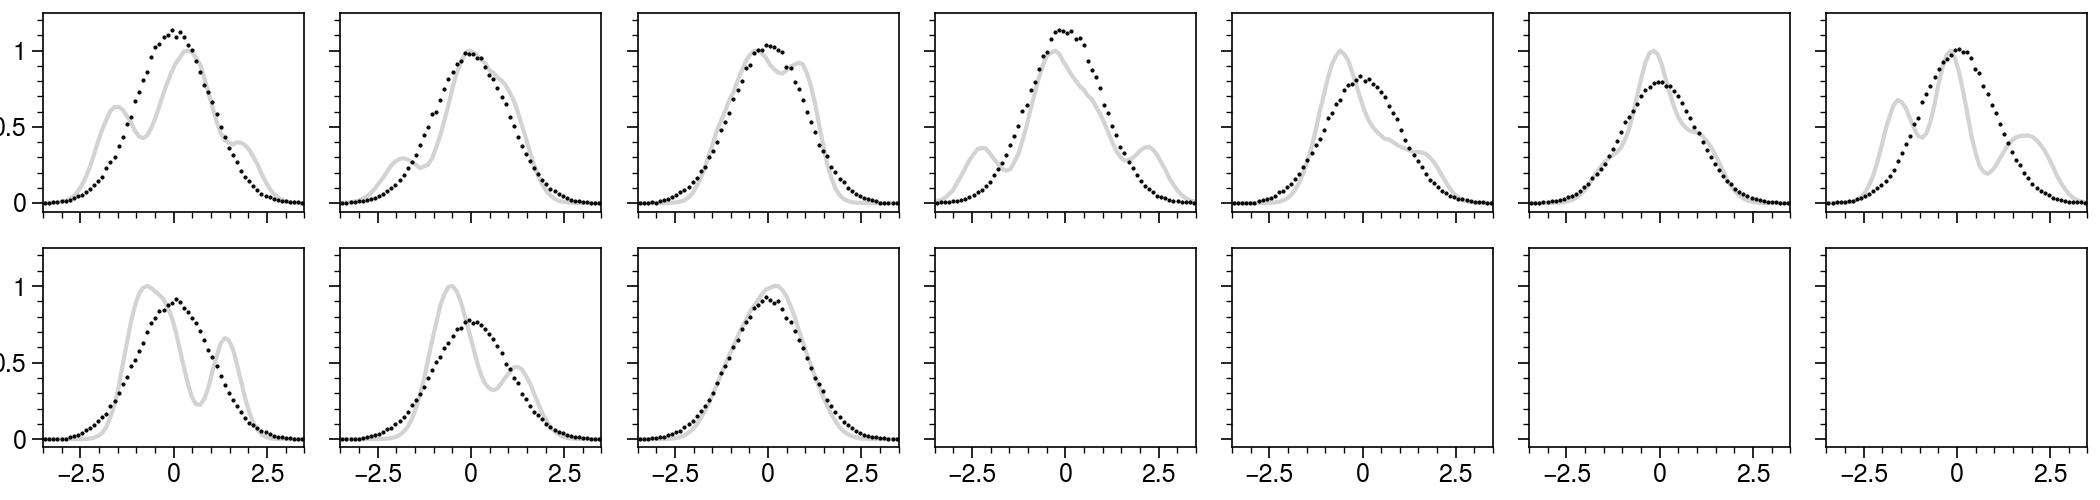

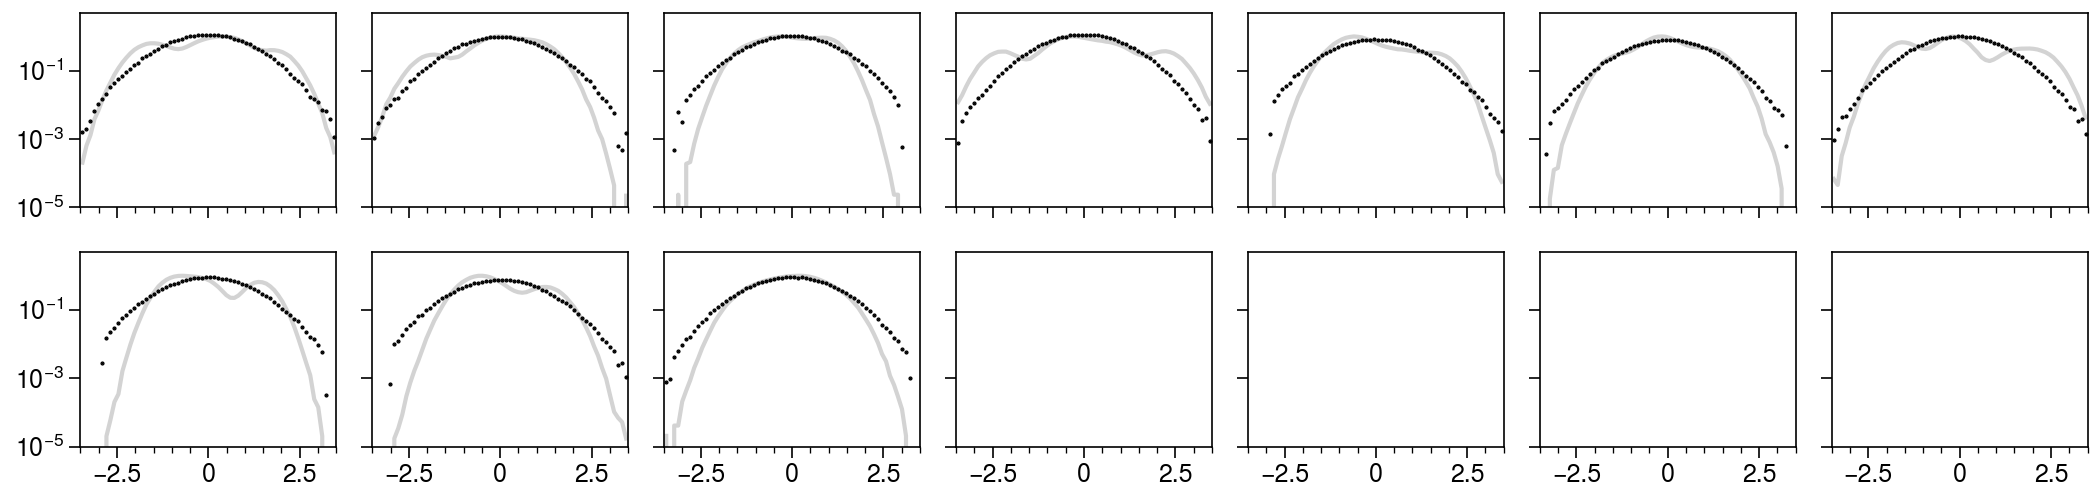

None
epoch = 1


  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  2%|███▏                                                                                                                                                           | 245/12015 [00:00<00:04, 2445.94it/s]

  4%|██████▌                                                                                                                                                        | 495/12015 [00:00<00:04, 2475.36it/s]

  6%|█████████▊                                                                                                                                                     | 743/12015 [00:00<00:04, 2476.66it/s]

  8%|█████████████                                                                                                                                                  | 991/12015 [00:00<00:04, 2476.52it/s]

 10%|████████████████▎                                                                                                                                             | 1241/12015 [00:00<00:04, 2483.09it/s]

 12%|███████████████████▌                                                                                                                                          | 1492/12015 [00:00<00:04, 2491.84it/s]

 15%|██████████████████████▉                                                                                                                                       | 1745/12015 [00:00<00:04, 2501.28it/s]

 17%|██████████████████████████▏                                                                                                                                   | 1996/12015 [00:00<00:04, 2502.39it/s]

 19%|█████████████████████████████▌                                                                                                                                | 2247/12015 [00:00<00:03, 2500.47it/s]

 21%|████████████████████████████████▊                                                                                                                             | 2498/12015 [00:01<00:03, 2498.45it/s]

 23%|████████████████████████████████████▏                                                                                                                         | 2749/12015 [00:01<00:03, 2501.37it/s]

 25%|███████████████████████████████████████▍                                                                                                                      | 3000/12015 [00:01<00:03, 2497.90it/s]

 27%|██████████████████████████████████████████▋                                                                                                                   | 3250/12015 [00:01<00:03, 2490.85it/s]

 29%|██████████████████████████████████████████████                                                                                                                | 3500/12015 [00:01<00:03, 2487.92it/s]

 31%|█████████████████████████████████████████████████▎                                                                                                            | 3749/12015 [00:01<00:03, 2485.87it/s]

 33%|████████████████████████████████████████████████████▌                                                                                                         | 3998/12015 [00:01<00:03, 2483.97it/s]

 35%|███████████████████████████████████████████████████████▊                                                                                                      | 4247/12015 [00:01<00:03, 2485.33it/s]

 37%|███████████████████████████████████████████████████████████                                                                                                   | 4496/12015 [00:01<00:03, 2482.35it/s]

 40%|██████████████████████████████████████████████████████████████▍                                                                                               | 4746/12015 [00:01<00:02, 2487.56it/s]

 42%|█████████████████████████████████████████████████████████████████▋                                                                                            | 4998/12015 [00:02<00:02, 2495.06it/s]

 44%|█████████████████████████████████████████████████████████████████████                                                                                         | 5250/12015 [00:02<00:02, 2500.81it/s]

 46%|████████████████████████████████████████████████████████████████████████▎                                                                                     | 5502/12015 [00:02<00:02, 2505.34it/s]

 48%|███████████████████████████████████████████████████████████████████████████▋                                                                                  | 5753/12015 [00:02<00:02, 2500.37it/s]

 50%|██████████████████████████████████████████████████████████████████████████████▉                                                                               | 6005/12015 [00:02<00:02, 2504.88it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████▎                                                                           | 6258/12015 [00:02<00:02, 2510.26it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 6510/12015 [00:02<00:02, 2511.93it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 6762/12015 [00:02<00:02, 2506.75it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 7014/12015 [00:02<00:01, 2510.25it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 7266/12015 [00:02<00:01, 2511.35it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 7519/12015 [00:03<00:01, 2514.78it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 7771/12015 [00:03<00:01, 2514.18it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 8023/12015 [00:03<00:01, 2514.63it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 8275/12015 [00:03<00:01, 2515.52it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 8527/12015 [00:03<00:01, 2515.94it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 8780/12015 [00:03<00:01, 2517.22it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 9032/12015 [00:03<00:01, 2514.84it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 9284/12015 [00:03<00:01, 2516.12it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 9536/12015 [00:03<00:00, 2509.75it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 9787/12015 [00:03<00:00, 2504.21it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 10040/12015 [00:04<00:00, 2510.71it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 10292/12015 [00:04<00:00, 2509.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 10545/12015 [00:04<00:00, 2514.78it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 10797/12015 [00:04<00:00, 2509.53it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 11048/12015 [00:04<00:00, 2506.67it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11299/12015 [00:04<00:00, 2506.52it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 11555/12015 [00:04<00:00, 2521.28it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 11816/12015 [00:04<00:00, 2545.78it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2506.49it/s]

  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  2%|███▎                                                                                                                                                           | 246/12015 [00:00<00:04, 2453.57it/s]

  4%|██████▌                                                                                                                                                        | 494/12015 [00:00<00:04, 2468.22it/s]

  6%|██████████                                                                                                                                                     | 757/12015 [00:00<00:04, 2541.79it/s]

  8%|█████████████▍                                                                                                                                                | 1019/12015 [00:00<00:04, 2570.69it/s]

 11%|████████████████▊                                                                                                                                             | 1278/12015 [00:00<00:04, 2574.15it/s]

 13%|████████████████████▎                                                                                                                                         | 1542/12015 [00:00<00:04, 2595.04it/s]

 15%|███████████████████████▋                                                                                                                                      | 1805/12015 [00:00<00:03, 2604.38it/s]

 17%|███████████████████████████▏                                                                                                                                  | 2068/12015 [00:00<00:03, 2611.75it/s]

 19%|██████████████████████████████▋                                                                                                                               | 2330/12015 [00:00<00:03, 2613.27it/s]

 22%|██████████████████████████████████                                                                                                                            | 2592/12015 [00:01<00:03, 2613.79it/s]

 24%|█████████████████████████████████████▌                                                                                                                        | 2855/12015 [00:01<00:03, 2618.24it/s]

 26%|████████████████████████████████████████▉                                                                                                                     | 3117/12015 [00:01<00:03, 2617.80it/s]

 28%|████████████████████████████████████████████▍                                                                                                                 | 3380/12015 [00:01<00:03, 2620.49it/s]

 30%|███████████████████████████████████████████████▉                                                                                                              | 3644/12015 [00:01<00:03, 2625.41it/s]

 33%|███████████████████████████████████████████████████▍                                                                                                          | 3907/12015 [00:01<00:03, 2625.17it/s]

 35%|██████████████████████████████████████████████████████▊                                                                                                       | 4171/12015 [00:01<00:02, 2627.59it/s]

 37%|██████████████████████████████████████████████████████████▎                                                                                                   | 4436/12015 [00:01<00:02, 2633.04it/s]

 39%|█████████████████████████████████████████████████████████████▊                                                                                                | 4700/12015 [00:01<00:02, 2628.58it/s]

 41%|█████████████████████████████████████████████████████████████████▎                                                                                            | 4964/12015 [00:01<00:02, 2630.79it/s]

 44%|████████████████████████████████████████████████████████████████████▋                                                                                         | 5228/12015 [00:02<00:02, 2626.31it/s]

 46%|████████████████████████████████████████████████████████████████████████▏                                                                                     | 5491/12015 [00:02<00:02, 2621.89it/s]

 48%|███████████████████████████████████████████████████████████████████████████▋                                                                                  | 5754/12015 [00:02<00:02, 2609.07it/s]

 50%|███████████████████████████████████████████████████████████████████████████████                                                                               | 6017/12015 [00:02<00:02, 2615.15it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████▌                                                                           | 6281/12015 [00:02<00:02, 2619.80it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████                                                                        | 6545/12015 [00:02<00:02, 2625.76it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 6810/12015 [00:02<00:01, 2630.59it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 7074/12015 [00:02<00:01, 2631.37it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 7338/12015 [00:02<00:01, 2625.42it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 7602/12015 [00:02<00:01, 2626.81it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 7865/12015 [00:03<00:01, 2623.41it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 8128/12015 [00:03<00:01, 2621.89it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 8392/12015 [00:03<00:01, 2625.88it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 8655/12015 [00:03<00:01, 2625.03it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 8918/12015 [00:03<00:01, 2625.82it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 9181/12015 [00:03<00:01, 2623.75it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 9445/12015 [00:03<00:00, 2626.62it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 9708/12015 [00:03<00:00, 2621.45it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 9971/12015 [00:03<00:00, 2619.27it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 10234/12015 [00:03<00:00, 2622.29it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 10498/12015 [00:04<00:00, 2626.51it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 10761/12015 [00:04<00:00, 2624.16it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 11025/12015 [00:04<00:00, 2626.99it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 11290/12015 [00:04<00:00, 2630.93it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 11554/12015 [00:04<00:00, 2631.93it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 11818/12015 [00:04<00:00, 2626.33it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2616.82it/s]

  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  2%|███▎                                                                                                                                                           | 250/12015 [00:00<00:04, 2497.42it/s]

  4%|██████▋                                                                                                                                                        | 501/12015 [00:00<00:04, 2500.92it/s]

  6%|█████████▉                                                                                                                                                     | 752/12015 [00:00<00:04, 2483.67it/s]

  8%|█████████████▏                                                                                                                                                | 1004/12015 [00:00<00:04, 2495.83it/s]

 10%|████████████████▌                                                                                                                                             | 1255/12015 [00:00<00:04, 2500.31it/s]

 13%|███████████████████▊                                                                                                                                          | 1506/12015 [00:00<00:04, 2495.00it/s]

 15%|███████████████████████                                                                                                                                       | 1758/12015 [00:00<00:04, 2499.59it/s]

 17%|██████████████████████████▍                                                                                                                                   | 2008/12015 [00:00<00:04, 2497.20it/s]

 19%|█████████████████████████████▋                                                                                                                                | 2258/12015 [00:00<00:03, 2497.75it/s]

 21%|█████████████████████████████████                                                                                                                             | 2510/12015 [00:01<00:03, 2501.81it/s]

 23%|████████████████████████████████████▎                                                                                                                         | 2762/12015 [00:01<00:03, 2505.91it/s]

 25%|███████████████████████████████████████▌                                                                                                                      | 3013/12015 [00:01<00:03, 2504.66it/s]

 27%|██████████████████████████████████████████▉                                                                                                                   | 3264/12015 [00:01<00:03, 2504.64it/s]

 29%|██████████████████████████████████████████████▏                                                                                                               | 3516/12015 [00:01<00:03, 2506.79it/s]

 31%|█████████████████████████████████████████████████▌                                                                                                            | 3768/12015 [00:01<00:03, 2510.70it/s]

 33%|████████████████████████████████████████████████████▉                                                                                                         | 4022/12015 [00:01<00:03, 2517.07it/s]

 36%|████████████████████████████████████████████████████████▏                                                                                                     | 4275/12015 [00:01<00:03, 2518.99it/s]

 38%|███████████████████████████████████████████████████████████▌                                                                                                  | 4527/12015 [00:01<00:02, 2516.18it/s]

 40%|██████████████████████████████████████████████████████████████▊                                                                                               | 4781/12015 [00:01<00:02, 2520.43it/s]

 42%|██████████████████████████████████████████████████████████████████▏                                                                                           | 5034/12015 [00:02<00:02, 2523.12it/s]

 44%|█████████████████████████████████████████████████████████████████████▌                                                                                        | 5287/12015 [00:02<00:02, 2522.17it/s]

 46%|████████████████████████████████████████████████████████████████████████▊                                                                                     | 5540/12015 [00:02<00:02, 2519.87it/s]

 48%|████████████████████████████████████████████████████████████████████████████▏                                                                                 | 5793/12015 [00:02<00:02, 2520.65it/s]

 50%|███████████████████████████████████████████████████████████████████████████████▌                                                                              | 6046/12015 [00:02<00:02, 2520.31it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████▊                                                                           | 6299/12015 [00:02<00:02, 2520.18it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 6552/12015 [00:02<00:02, 2517.11it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 6804/12015 [00:02<00:02, 2517.91it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 7057/12015 [00:02<00:01, 2520.01it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 7310/12015 [00:02<00:01, 2521.00it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 7563/12015 [00:03<00:01, 2522.39it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 7816/12015 [00:03<00:01, 2509.47it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 8067/12015 [00:03<00:01, 2400.29it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 8316/12015 [00:03<00:01, 2424.45it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 8568/12015 [00:03<00:01, 2450.14it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 8820/12015 [00:03<00:01, 2468.38it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 9072/12015 [00:03<00:01, 2482.19it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 9321/12015 [00:03<00:01, 2481.85it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 9573/12015 [00:03<00:00, 2490.59it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 9825/12015 [00:03<00:00, 2499.31it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 10076/12015 [00:04<00:00, 2495.92it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 10326/12015 [00:04<00:00, 2486.24it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 10575/12015 [00:04<00:00, 2486.78it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 10825/12015 [00:04<00:00, 2489.50it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 11078/12015 [00:04<00:00, 2498.71it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 11330/12015 [00:04<00:00, 2502.34it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 11582/12015 [00:04<00:00, 2507.58it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 11835/12015 [00:04<00:00, 2512.94it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2500.60it/s]

  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  2%|███▎                                                                                                                                                           | 252/12015 [00:00<00:04, 2511.24it/s]

  4%|██████▋                                                                                                                                                        | 505/12015 [00:00<00:04, 2522.11it/s]

  6%|██████████                                                                                                                                                     | 758/12015 [00:00<00:04, 2525.65it/s]

  8%|█████████████▎                                                                                                                                                | 1012/12015 [00:00<00:04, 2530.67it/s]

 11%|████████████████▋                                                                                                                                             | 1266/12015 [00:00<00:04, 2529.20it/s]

 13%|███████████████████▉                                                                                                                                          | 1519/12015 [00:00<00:04, 2523.53it/s]

 15%|███████████████████████▎                                                                                                                                      | 1772/12015 [00:00<00:04, 2509.92it/s]

 17%|██████████████████████████▌                                                                                                                                   | 2024/12015 [00:00<00:03, 2506.47it/s]

 19%|█████████████████████████████▉                                                                                                                                | 2275/12015 [00:00<00:03, 2507.39it/s]

 21%|█████████████████████████████████▏                                                                                                                            | 2526/12015 [00:01<00:03, 2502.29it/s]

 23%|████████████████████████████████████▌                                                                                                                         | 2777/12015 [00:01<00:03, 2500.08it/s]

 25%|███████████████████████████████████████▊                                                                                                                      | 3028/12015 [00:01<00:03, 2499.81it/s]

 27%|███████████████████████████████████████████                                                                                                                   | 3278/12015 [00:01<00:03, 2498.92it/s]

 29%|██████████████████████████████████████████████▍                                                                                                               | 3528/12015 [00:01<00:03, 2404.77it/s]

 31%|█████████████████████████████████████████████████▌                                                                                                            | 3773/12015 [00:01<00:03, 2417.07it/s]

 33%|████████████████████████████████████████████████████▉                                                                                                         | 4024/12015 [00:01<00:03, 2443.58it/s]

 36%|████████████████████████████████████████████████████████▏                                                                                                     | 4276/12015 [00:01<00:03, 2463.68it/s]

 38%|███████████████████████████████████████████████████████████▌                                                                                                  | 4527/12015 [00:01<00:03, 2476.95it/s]

 40%|██████████████████████████████████████████████████████████████▊                                                                                               | 4780/12015 [00:01<00:02, 2490.71it/s]

 42%|██████████████████████████████████████████████████████████████████▏                                                                                           | 5032/12015 [00:02<00:02, 2498.00it/s]

 44%|█████████████████████████████████████████████████████████████████████▍                                                                                        | 5284/12015 [00:02<00:02, 2502.30it/s]

 46%|████████████████████████████████████████████████████████████████████████▊                                                                                     | 5536/12015 [00:02<00:02, 2506.46it/s]

 48%|████████████████████████████████████████████████████████████████████████████▏                                                                                 | 5789/12015 [00:02<00:02, 2510.60it/s]

 50%|███████████████████████████████████████████████████████████████████████████████▍                                                                              | 6041/12015 [00:02<00:02, 2498.03it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████▋                                                                           | 6291/12015 [00:02<00:02, 2480.22it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████                                                                        | 6540/12015 [00:02<00:02, 2481.73it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 6792/12015 [00:02<00:02, 2492.72it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 7043/12015 [00:02<00:01, 2497.63it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 7295/12015 [00:02<00:01, 2503.73it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 7546/12015 [00:03<00:01, 2493.50it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 7796/12015 [00:03<00:01, 2494.96it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 8048/12015 [00:03<00:01, 2500.23it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 8301/12015 [00:03<00:01, 2506.41it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 8554/12015 [00:03<00:01, 2511.79it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 8806/12015 [00:03<00:01, 2509.23it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 9059/12015 [00:03<00:01, 2513.72it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 9312/12015 [00:03<00:01, 2517.74it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 9565/12015 [00:03<00:00, 2519.39it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 9817/12015 [00:03<00:00, 2516.14it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 10070/12015 [00:04<00:00, 2518.83it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 10322/12015 [00:04<00:00, 2515.80it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 10575/12015 [00:04<00:00, 2519.14it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 10827/12015 [00:04<00:00, 2514.96it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 11079/12015 [00:04<00:00, 2466.97it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 11326/12015 [00:04<00:00, 2390.44it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 11575/12015 [00:04<00:00, 2418.26it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 11826/12015 [00:04<00:00, 2444.64it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2489.38it/s]

  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  2%|███▎                                                                                                                                                           | 250/12015 [00:00<00:04, 2499.78it/s]

  4%|██████▌                                                                                                                                                        | 500/12015 [00:00<00:04, 2476.11it/s]

  6%|█████████▉                                                                                                                                                     | 751/12015 [00:00<00:04, 2489.04it/s]

  8%|█████████████▏                                                                                                                                                | 1002/12015 [00:00<00:04, 2496.11it/s]

 10%|████████████████▍                                                                                                                                             | 1252/12015 [00:00<00:04, 2496.64it/s]

 13%|███████████████████▊                                                                                                                                          | 1502/12015 [00:00<00:04, 2491.22it/s]

 15%|███████████████████████                                                                                                                                       | 1754/12015 [00:00<00:04, 2499.78it/s]

 17%|██████████████████████████▍                                                                                                                                   | 2007/12015 [00:00<00:03, 2506.72it/s]

 19%|█████████████████████████████▋                                                                                                                                | 2260/12015 [00:00<00:03, 2512.47it/s]

 21%|█████████████████████████████████                                                                                                                             | 2513/12015 [00:01<00:03, 2517.63it/s]

 23%|████████████████████████████████████▍                                                                                                                         | 2767/12015 [00:01<00:03, 2521.54it/s]

 25%|███████████████████████████████████████▋                                                                                                                      | 3020/12015 [00:01<00:03, 2523.66it/s]

 27%|███████████████████████████████████████████                                                                                                                   | 3273/12015 [00:01<00:03, 2525.23it/s]

 29%|██████████████████████████████████████████████▍                                                                                                               | 3527/12015 [00:01<00:03, 2528.57it/s]

 31%|█████████████████████████████████████████████████▋                                                                                                            | 3781/12015 [00:01<00:03, 2529.62it/s]

 34%|█████████████████████████████████████████████████████                                                                                                         | 4035/12015 [00:01<00:03, 2530.09it/s]

 36%|████████████████████████████████████████████████████████▍                                                                                                     | 4289/12015 [00:01<00:03, 2527.57it/s]

 38%|███████████████████████████████████████████████████████████▊                                                                                                  | 4546/12015 [00:01<00:02, 2539.10it/s]

 40%|███████████████████████████████████████████████████████████████▏                                                                                              | 4806/12015 [00:01<00:02, 2556.75it/s]

 42%|██████████████████████████████████████████████████████████████████▌                                                                                           | 5066/12015 [00:02<00:02, 2569.28it/s]

 44%|██████████████████████████████████████████████████████████████████████                                                                                        | 5329/12015 [00:02<00:02, 2586.84it/s]

 47%|█████████████████████████████████████████████████████████████████████████▌                                                                                    | 5593/12015 [00:02<00:02, 2601.45it/s]

 49%|████████████████████████████████████████████████████████████████████████████▉                                                                                 | 5854/12015 [00:02<00:02, 2598.28it/s]

 51%|████████████████████████████████████████████████████████████████████████████████▍                                                                             | 6115/12015 [00:02<00:02, 2599.18it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████▊                                                                          | 6375/12015 [00:02<00:02, 2599.03it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 6635/12015 [00:02<00:02, 2582.46it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 6894/12015 [00:02<00:02, 2449.10it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 7141/12015 [00:02<00:02, 2372.62it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 7392/12015 [00:02<00:01, 2410.93it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 7652/12015 [00:03<00:01, 2463.14it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 7910/12015 [00:03<00:01, 2497.03it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 8169/12015 [00:03<00:01, 2523.87it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 8429/12015 [00:03<00:01, 2545.18it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 8690/12015 [00:03<00:01, 2562.66it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 8951/12015 [00:03<00:01, 2574.14it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 9213/12015 [00:03<00:01, 2585.33it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 9474/12015 [00:03<00:00, 2592.46it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 9736/12015 [00:03<00:00, 2600.67it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 9999/12015 [00:03<00:00, 2608.39it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 10260/12015 [00:04<00:00, 2598.72it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 10521/12015 [00:04<00:00, 2599.42it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 10782/12015 [00:04<00:00, 2601.60it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 11044/12015 [00:04<00:00, 2605.81it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11306/12015 [00:04<00:00, 2609.78it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 11567/12015 [00:04<00:00, 2609.78it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 11831/12015 [00:04<00:00, 2616.71it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2548.81it/s]

  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  2%|███▎                                                                                                                                                           | 253/12015 [00:00<00:04, 2520.20it/s]

  4%|██████▋                                                                                                                                                        | 506/12015 [00:00<00:04, 2515.48it/s]

  6%|██████████                                                                                                                                                     | 759/12015 [00:00<00:04, 2518.57it/s]

  8%|█████████████▎                                                                                                                                                | 1011/12015 [00:00<00:04, 2518.10it/s]

 11%|████████████████▌                                                                                                                                             | 1263/12015 [00:00<00:04, 2503.78it/s]

 13%|███████████████████▉                                                                                                                                          | 1516/12015 [00:00<00:04, 2511.78it/s]

 15%|███████████████████████▎                                                                                                                                      | 1769/12015 [00:00<00:04, 2517.38it/s]

 17%|██████████████████████████▌                                                                                                                                   | 2021/12015 [00:00<00:03, 2511.98it/s]

 19%|█████████████████████████████▉                                                                                                                                | 2273/12015 [00:00<00:03, 2508.43it/s]

 21%|█████████████████████████████████▏                                                                                                                            | 2524/12015 [00:01<00:03, 2498.13it/s]

 23%|████████████████████████████████████▌                                                                                                                         | 2776/12015 [00:01<00:03, 2503.64it/s]

 25%|███████████████████████████████████████▊                                                                                                                      | 3027/12015 [00:01<00:03, 2503.38it/s]

 27%|███████████████████████████████████████████▏                                                                                                                  | 3280/12015 [00:01<00:03, 2508.50it/s]

 29%|██████████████████████████████████████████████▍                                                                                                               | 3533/12015 [00:01<00:03, 2513.31it/s]

 32%|█████████████████████████████████████████████████▊                                                                                                            | 3785/12015 [00:01<00:03, 2510.94it/s]

 34%|█████████████████████████████████████████████████████                                                                                                         | 4037/12015 [00:01<00:03, 2511.95it/s]

 36%|████████████████████████████████████████████████████████▍                                                                                                     | 4290/12015 [00:01<00:03, 2517.21it/s]

 38%|███████████████████████████████████████████████████████████▋                                                                                                  | 4542/12015 [00:01<00:02, 2517.06it/s]

 40%|███████████████████████████████████████████████████████████████                                                                                               | 4795/12015 [00:01<00:02, 2518.68it/s]

 42%|██████████████████████████████████████████████████████████████████▎                                                                                           | 5047/12015 [00:02<00:02, 2516.86it/s]

 44%|█████████████████████████████████████████████████████████████████████▋                                                                                        | 5300/12015 [00:02<00:02, 2520.72it/s]

 46%|█████████████████████████████████████████████████████████████████████████                                                                                     | 5554/12015 [00:02<00:02, 2523.53it/s]

 48%|████████████████████████████████████████████████████████████████████████████▎                                                                                 | 5807/12015 [00:02<00:02, 2522.03it/s]

 50%|███████████████████████████████████████████████████████████████████████████████▋                                                                              | 6060/12015 [00:02<00:02, 2522.79it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████                                                                           | 6313/12015 [00:02<00:02, 2518.92it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 6565/12015 [00:02<00:02, 2518.55it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 6818/12015 [00:02<00:02, 2521.86it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 7071/12015 [00:02<00:01, 2520.00it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 7324/12015 [00:02<00:01, 2518.18it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 7576/12015 [00:03<00:01, 2517.83it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 7828/12015 [00:03<00:01, 2441.64it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 8073/12015 [00:03<00:01, 2418.16it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 8325/12015 [00:03<00:01, 2445.18it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 8579/12015 [00:03<00:01, 2471.92it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 8831/12015 [00:03<00:01, 2483.92it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 9080/12015 [00:03<00:01, 2485.45it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 9334/12015 [00:03<00:01, 2500.28it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 9588/12015 [00:03<00:00, 2511.08it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 9840/12015 [00:03<00:00, 2504.66it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 10091/12015 [00:04<00:00, 2501.42it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 10342/12015 [00:04<00:00, 2500.14it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 10594/12015 [00:04<00:00, 2505.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 10845/12015 [00:04<00:00, 2502.66it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 11099/12015 [00:04<00:00, 2511.22it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 11351/12015 [00:04<00:00, 2513.77it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 11605/12015 [00:04<00:00, 2520.79it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 11858/12015 [00:04<00:00, 2512.25it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2505.82it/s]

  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  2%|███▎                                                                                                                                                           | 251/12015 [00:00<00:04, 2501.72it/s]

  4%|██████▋                                                                                                                                                        | 502/12015 [00:00<00:04, 2500.30it/s]

  6%|█████████▉                                                                                                                                                     | 753/12015 [00:00<00:04, 2497.41it/s]

  8%|█████████████▏                                                                                                                                                | 1003/12015 [00:00<00:04, 2490.29it/s]

 10%|████████████████▍                                                                                                                                             | 1253/12015 [00:00<00:04, 2488.68it/s]

 13%|███████████████████▊                                                                                                                                          | 1503/12015 [00:00<00:04, 2489.71it/s]

 15%|███████████████████████                                                                                                                                       | 1753/12015 [00:00<00:04, 2492.76it/s]

 17%|██████████████████████████▎                                                                                                                                   | 2005/12015 [00:00<00:04, 2499.46it/s]

 19%|█████████████████████████████▋                                                                                                                                | 2256/12015 [00:00<00:03, 2501.38it/s]

 21%|████████████████████████████████▉                                                                                                                             | 2507/12015 [00:01<00:03, 2499.17it/s]

 23%|████████████████████████████████████▎                                                                                                                         | 2757/12015 [00:01<00:03, 2495.09it/s]

 25%|███████████████████████████████████████▌                                                                                                                      | 3007/12015 [00:01<00:03, 2494.48it/s]

 27%|██████████████████████████████████████████▊                                                                                                                   | 3257/12015 [00:01<00:03, 2484.95it/s]

 29%|██████████████████████████████████████████████                                                                                                                | 3506/12015 [00:01<00:03, 2393.58it/s]

 31%|█████████████████████████████████████████████████▍                                                                                                            | 3755/12015 [00:01<00:03, 2419.60it/s]

 33%|████████████████████████████████████████████████████▋                                                                                                         | 4007/12015 [00:01<00:03, 2446.74it/s]

 35%|████████████████████████████████████████████████████████                                                                                                      | 4260/12015 [00:01<00:03, 2468.72it/s]

 38%|███████████████████████████████████████████████████████████▎                                                                                                  | 4513/12015 [00:01<00:03, 2485.34it/s]

 40%|██████████████████████████████████████████████████████████████▋                                                                                               | 4765/12015 [00:01<00:02, 2494.44it/s]

 42%|█████████████████████████████████████████████████████████████████▉                                                                                            | 5017/12015 [00:02<00:02, 2501.18it/s]

 44%|█████████████████████████████████████████████████████████████████████▎                                                                                        | 5268/12015 [00:02<00:02, 2496.60it/s]

 46%|████████████████████████████████████████████████████████████████████████▌                                                                                     | 5518/12015 [00:02<00:02, 2494.72it/s]

 48%|███████████████████████████████████████████████████████████████████████████▊                                                                                  | 5769/12015 [00:02<00:02, 2498.44it/s]

 50%|███████████████████████████████████████████████████████████████████████████████▏                                                                              | 6020/12015 [00:02<00:02, 2500.14it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████▍                                                                           | 6273/12015 [00:02<00:02, 2507.96it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 6526/12015 [00:02<00:02, 2514.34it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 6778/12015 [00:02<00:02, 2512.23it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 7030/12015 [00:02<00:01, 2513.76it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 7283/12015 [00:02<00:01, 2516.84it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 7536/12015 [00:03<00:01, 2519.10it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 7788/12015 [00:03<00:01, 2508.36it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 8039/12015 [00:03<00:01, 2503.33it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 8291/12015 [00:03<00:01, 2506.45it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 8543/12015 [00:03<00:01, 2509.11it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 8796/12015 [00:03<00:01, 2512.45it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 9048/12015 [00:03<00:01, 2502.04it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 9299/12015 [00:03<00:01, 2493.83it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 9551/12015 [00:03<00:00, 2498.68it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 9801/12015 [00:03<00:00, 2498.14it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 10054/12015 [00:04<00:00, 2505.55it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 10307/12015 [00:04<00:00, 2512.20it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 10560/12015 [00:04<00:00, 2516.34it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 10813/12015 [00:04<00:00, 2518.09it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 11066/12015 [00:04<00:00, 2519.78it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 11318/12015 [00:04<00:00, 2393.24it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 11559/12015 [00:04<00:00, 2395.79it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 11806/12015 [00:04<00:00, 2416.25it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2485.59it/s]

  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  2%|███▎                                                                                                                                                           | 249/12015 [00:00<00:04, 2485.95it/s]

  4%|██████▌                                                                                                                                                        | 498/12015 [00:00<00:04, 2481.92it/s]

  6%|█████████▉                                                                                                                                                     | 748/12015 [00:00<00:04, 2486.17it/s]

  8%|█████████████▏                                                                                                                                                 | 997/12015 [00:00<00:04, 2485.46it/s]

 10%|████████████████▍                                                                                                                                             | 1247/12015 [00:00<00:04, 2487.70it/s]

 12%|███████████████████▋                                                                                                                                          | 1496/12015 [00:00<00:04, 2479.76it/s]

 15%|██████████████████████▉                                                                                                                                       | 1746/12015 [00:00<00:04, 2483.47it/s]

 17%|██████████████████████████▏                                                                                                                                   | 1995/12015 [00:00<00:04, 2484.86it/s]

 19%|█████████████████████████████▌                                                                                                                                | 2244/12015 [00:00<00:03, 2483.51it/s]

 21%|████████████████████████████████▊                                                                                                                             | 2493/12015 [00:01<00:03, 2484.24it/s]

 23%|████████████████████████████████████                                                                                                                          | 2743/12015 [00:01<00:03, 2488.14it/s]

 25%|███████████████████████████████████████▎                                                                                                                      | 2992/12015 [00:01<00:03, 2486.90it/s]

 27%|██████████████████████████████████████████▌                                                                                                                   | 3241/12015 [00:01<00:03, 2485.94it/s]

 29%|█████████████████████████████████████████████▉                                                                                                                | 3491/12015 [00:01<00:03, 2488.52it/s]

 31%|█████████████████████████████████████████████████▏                                                                                                            | 3740/12015 [00:01<00:03, 2486.29it/s]

 33%|████████████████████████████████████████████████████▍                                                                                                         | 3990/12015 [00:01<00:03, 2487.84it/s]

 35%|███████████████████████████████████████████████████████▊                                                                                                      | 4240/12015 [00:01<00:03, 2489.76it/s]

 37%|███████████████████████████████████████████████████████████                                                                                                   | 4490/12015 [00:01<00:03, 2492.37it/s]

 39%|██████████████████████████████████████████████████████████████▎                                                                                               | 4742/12015 [00:01<00:02, 2500.25it/s]

 42%|█████████████████████████████████████████████████████████████████▋                                                                                            | 4995/12015 [00:02<00:02, 2507.62it/s]

 44%|█████████████████████████████████████████████████████████████████████                                                                                         | 5248/12015 [00:02<00:02, 2512.38it/s]

 46%|████████████████████████████████████████████████████████████████████████▎                                                                                     | 5501/12015 [00:02<00:02, 2515.03it/s]

 48%|███████████████████████████████████████████████████████████████████████████▋                                                                                  | 5754/12015 [00:02<00:02, 2518.65it/s]

 50%|██████████████████████████████████████████████████████████████████████████████▉                                                                               | 6007/12015 [00:02<00:02, 2519.38it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████▎                                                                           | 6260/12015 [00:02<00:02, 2519.94it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 6512/12015 [00:02<00:02, 2515.40it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 6764/12015 [00:02<00:02, 2403.20it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 7006/12015 [00:02<00:02, 2340.89it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 7252/12015 [00:02<00:02, 2374.74it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 7510/12015 [00:03<00:01, 2432.86it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 7769/12015 [00:03<00:01, 2477.54it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 8027/12015 [00:03<00:01, 2506.00it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 8286/12015 [00:03<00:01, 2530.70it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 8549/12015 [00:03<00:01, 2559.16it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 8807/12015 [00:03<00:01, 2565.28it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 9065/12015 [00:03<00:01, 2566.93it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 9324/12015 [00:03<00:01, 2571.15it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 9585/12015 [00:03<00:00, 2580.99it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 9848/12015 [00:03<00:00, 2594.02it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 10110/12015 [00:04<00:00, 2601.39it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 10373/12015 [00:04<00:00, 2607.30it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 10636/12015 [00:04<00:00, 2613.52it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 10899/12015 [00:04<00:00, 2617.91it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 11162/12015 [00:04<00:00, 2618.67it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 11424/12015 [00:04<00:00, 2617.03it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 11687/12015 [00:04<00:00, 2620.23it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 11950/12015 [00:04<00:00, 2613.40it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2522.45it/s]

  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  2%|███▍                                                                                                                                                           | 261/12015 [00:00<00:04, 2601.59it/s]

  4%|██████▉                                                                                                                                                        | 523/12015 [00:00<00:04, 2611.34it/s]

  7%|██████████▍                                                                                                                                                    | 787/12015 [00:00<00:04, 2622.70it/s]

  9%|█████████████▊                                                                                                                                                | 1050/12015 [00:00<00:04, 2623.88it/s]

 11%|█████████████████▎                                                                                                                                            | 1313/12015 [00:00<00:04, 2621.62it/s]

 13%|████████████████████▋                                                                                                                                         | 1577/12015 [00:00<00:03, 2627.74it/s]

 15%|████████████████████████▏                                                                                                                                     | 1840/12015 [00:00<00:03, 2622.73it/s]

 18%|███████████████████████████▋                                                                                                                                  | 2103/12015 [00:00<00:03, 2623.45it/s]

 20%|███████████████████████████████                                                                                                                               | 2366/12015 [00:00<00:03, 2622.98it/s]

 22%|██████████████████████████████████▌                                                                                                                           | 2629/12015 [00:01<00:03, 2623.53it/s]

 24%|██████████████████████████████████████                                                                                                                        | 2893/12015 [00:01<00:03, 2626.56it/s]

 26%|█████████████████████████████████████████▌                                                                                                                    | 3156/12015 [00:01<00:03, 2627.46it/s]

 28%|████████████████████████████████████████████▉                                                                                                                 | 3419/12015 [00:01<00:03, 2628.15it/s]

 31%|████████████████████████████████████████████████▍                                                                                                             | 3683/12015 [00:01<00:03, 2630.57it/s]

 33%|███████████████████████████████████████████████████▉                                                                                                          | 3948/12015 [00:01<00:03, 2633.54it/s]

 35%|███████████████████████████████████████████████████████▍                                                                                                      | 4213/12015 [00:01<00:02, 2636.37it/s]

 37%|██████████████████████████████████████████████████████████▊                                                                                                   | 4477/12015 [00:01<00:02, 2635.48it/s]

 39%|██████████████████████████████████████████████████████████████▎                                                                                               | 4741/12015 [00:01<00:02, 2617.33it/s]

 42%|█████████████████████████████████████████████████████████████████▊                                                                                            | 5005/12015 [00:01<00:02, 2622.28it/s]

 44%|█████████████████████████████████████████████████████████████████████▎                                                                                        | 5268/12015 [00:02<00:02, 2618.48it/s]

 46%|████████████████████████████████████████████████████████████████████████▋                                                                                     | 5532/12015 [00:02<00:02, 2623.60it/s]

 48%|████████████████████████████████████████████████████████████████████████████▏                                                                                 | 5796/12015 [00:02<00:02, 2627.39it/s]

 50%|███████████████████████████████████████████████████████████████████████████████▋                                                                              | 6060/12015 [00:02<00:02, 2629.67it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████▏                                                                          | 6323/12015 [00:02<00:02, 2615.64it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 6585/12015 [00:02<00:02, 2614.38it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████                                                                    | 6847/12015 [00:02<00:01, 2615.11it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 7109/12015 [00:02<00:01, 2614.22it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 7371/12015 [00:02<00:01, 2614.19it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 7634/12015 [00:02<00:01, 2618.30it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 7898/12015 [00:03<00:01, 2622.76it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 8161/12015 [00:03<00:01, 2619.70it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 8423/12015 [00:03<00:01, 2618.90it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 8685/12015 [00:03<00:01, 2618.63it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 8950/12015 [00:03<00:01, 2625.26it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 9214/12015 [00:03<00:01, 2628.87it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 9477/12015 [00:03<00:00, 2625.40it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 9740/12015 [00:03<00:00, 2623.17it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 10004/12015 [00:03<00:00, 2626.79it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 10269/12015 [00:03<00:00, 2631.76it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 10533/12015 [00:04<00:00, 2628.72it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 10797/12015 [00:04<00:00, 2629.52it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 11061/12015 [00:04<00:00, 2630.94it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 11325/12015 [00:04<00:00, 2632.14it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 11589/12015 [00:04<00:00, 2628.91it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 11852/12015 [00:04<00:00, 2622.30it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2622.63it/s]

  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  2%|███▍                                                                                                                                                           | 262/12015 [00:00<00:04, 2611.15it/s]

  4%|██████▉                                                                                                                                                        | 526/12015 [00:00<00:04, 2626.20it/s]

  7%|██████████▍                                                                                                                                                    | 789/12015 [00:00<00:04, 2619.16it/s]

  9%|█████████████▊                                                                                                                                                | 1051/12015 [00:00<00:04, 2615.61it/s]

 11%|█████████████████▎                                                                                                                                            | 1313/12015 [00:00<00:04, 2558.22it/s]

 13%|████████████████████▋                                                                                                                                         | 1574/12015 [00:00<00:04, 2573.76it/s]

 15%|████████████████████████▏                                                                                                                                     | 1837/12015 [00:00<00:03, 2588.78it/s]

 17%|███████████████████████████▌                                                                                                                                  | 2100/12015 [00:00<00:03, 2598.88it/s]

 20%|███████████████████████████████                                                                                                                               | 2363/12015 [00:00<00:03, 2608.29it/s]

 22%|██████████████████████████████████▌                                                                                                                           | 2626/12015 [00:01<00:03, 2612.25it/s]

 24%|██████████████████████████████████████                                                                                                                        | 2890/12015 [00:01<00:03, 2618.55it/s]

 26%|█████████████████████████████████████████▍                                                                                                                    | 3152/12015 [00:01<00:03, 2618.29it/s]

 28%|████████████████████████████████████████████▉                                                                                                                 | 3414/12015 [00:01<00:03, 2617.31it/s]

 31%|████████████████████████████████████████████████▎                                                                                                             | 3678/12015 [00:01<00:03, 2621.48it/s]

 33%|███████████████████████████████████████████████████▊                                                                                                          | 3942/12015 [00:01<00:03, 2624.93it/s]

 35%|███████████████████████████████████████████████████████▎                                                                                                      | 4205/12015 [00:01<00:02, 2623.74it/s]

 37%|██████████████████████████████████████████████████████████▊                                                                                                   | 4468/12015 [00:01<00:02, 2622.74it/s]

 39%|██████████████████████████████████████████████████████████████▏                                                                                               | 4731/12015 [00:01<00:02, 2622.06it/s]

 42%|█████████████████████████████████████████████████████████████████▋                                                                                            | 4995/12015 [00:01<00:02, 2624.69it/s]

 44%|█████████████████████████████████████████████████████████████████████▏                                                                                        | 5258/12015 [00:02<00:02, 2604.72it/s]

 46%|████████████████████████████████████████████████████████████████████████▌                                                                                     | 5519/12015 [00:02<00:02, 2570.90it/s]

 48%|███████████████████████████████████████████████████████████████████████████▉                                                                                  | 5777/12015 [00:02<00:02, 2550.53it/s]

 50%|███████████████████████████████████████████████████████████████████████████████▎                                                                              | 6033/12015 [00:02<00:02, 2539.71it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████▋                                                                           | 6288/12015 [00:02<00:02, 2533.99it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████                                                                        | 6542/12015 [00:02<00:02, 2526.22it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 6795/12015 [00:02<00:02, 2519.07it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 7047/12015 [00:02<00:01, 2506.54it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 7298/12015 [00:02<00:01, 2493.92it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 7548/12015 [00:02<00:01, 2484.14it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 7797/12015 [00:03<00:01, 2482.49it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 8046/12015 [00:03<00:01, 2481.80it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 8295/12015 [00:03<00:01, 2479.56it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 8544/12015 [00:03<00:01, 2480.31it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 8795/12015 [00:03<00:01, 2487.50it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 9046/12015 [00:03<00:01, 2493.70it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 9299/12015 [00:03<00:01, 2502.84it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 9552/12015 [00:03<00:00, 2508.87it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 9803/12015 [00:03<00:00, 2493.02it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 10053/12015 [00:03<00:00, 2491.43it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 10304/12015 [00:04<00:00, 2496.88it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 10555/12015 [00:04<00:00, 2498.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 10807/12015 [00:04<00:00, 2502.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 11060/12015 [00:04<00:00, 2510.03it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 11312/12015 [00:04<00:00, 2511.45it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 11566/12015 [00:04<00:00, 2517.29it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 11818/12015 [00:04<00:00, 2513.07it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2545.70it/s]

  0%|                                                                                                                                                                           | 0/14031 [00:00<?, ?it/s]

  2%|██▉                                                                                                                                                            | 258/14031 [00:00<00:05, 2576.08it/s]

  4%|█████▊                                                                                                                                                         | 516/14031 [00:00<00:05, 2575.69it/s]

  6%|████████▊                                                                                                                                                      | 774/14031 [00:00<00:05, 2572.17it/s]

  7%|███████████▌                                                                                                                                                  | 1032/14031 [00:00<00:05, 2574.35it/s]

  9%|██████████████▌                                                                                                                                               | 1290/14031 [00:00<00:04, 2576.15it/s]

 11%|█████████████████▍                                                                                                                                            | 1550/14031 [00:00<00:04, 2584.10it/s]

 13%|████████████████████▍                                                                                                                                         | 1810/14031 [00:00<00:04, 2587.61it/s]

 15%|███████████████████████▎                                                                                                                                      | 2074/14031 [00:00<00:04, 2602.23it/s]

 17%|██████████████████████████▎                                                                                                                                   | 2335/14031 [00:00<00:04, 2588.68it/s]

 18%|█████████████████████████████▏                                                                                                                                | 2594/14031 [00:01<00:04, 2585.11it/s]

 20%|████████████████████████████████▏                                                                                                                             | 2853/14031 [00:01<00:04, 2578.50it/s]

 22%|███████████████████████████████████                                                                                                                           | 3111/14031 [00:01<00:04, 2573.39it/s]

 24%|█████████████████████████████████████▉                                                                                                                        | 3369/14031 [00:01<00:04, 2575.12it/s]

 26%|████████████████████████████████████████▊                                                                                                                     | 3628/14031 [00:01<00:04, 2576.91it/s]

 28%|███████████████████████████████████████████▊                                                                                                                  | 3886/14031 [00:01<00:03, 2568.66it/s]

 30%|██████████████████████████████████████████████▋                                                                                                               | 4143/14031 [00:01<00:03, 2567.22it/s]

 31%|█████████████████████████████████████████████████▌                                                                                                            | 4400/14031 [00:01<00:03, 2566.54it/s]

 33%|████████████████████████████████████████████████████▍                                                                                                         | 4657/14031 [00:01<00:03, 2566.73it/s]

 35%|███████████████████████████████████████████████████████▎                                                                                                      | 4915/14031 [00:01<00:03, 2569.62it/s]

 37%|██████████████████████████████████████████████████████████▏                                                                                                   | 5172/14031 [00:02<00:03, 2566.07it/s]

 39%|█████████████████████████████████████████████████████████████▏                                                                                                | 5429/14031 [00:02<00:03, 2561.14it/s]

 41%|████████████████████████████████████████████████████████████████                                                                                              | 5686/14031 [00:02<00:03, 2563.59it/s]

 42%|██████████████████████████████████████████████████████████████████▉                                                                                           | 5943/14031 [00:02<00:03, 2559.81it/s]

 44%|█████████████████████████████████████████████████████████████████████▊                                                                                        | 6199/14031 [00:02<00:03, 2557.23it/s]

 46%|████████████████████████████████████████████████████████████████████████▋                                                                                     | 6457/14031 [00:02<00:02, 2562.48it/s]

 48%|███████████████████████████████████████████████████████████████████████████▌                                                                                  | 6714/14031 [00:02<00:02, 2559.39it/s]

 50%|██████████████████████████████████████████████████████████████████████████████▌                                                                               | 6973/14031 [00:02<00:02, 2567.17it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████▍                                                                            | 7235/14031 [00:02<00:02, 2582.43it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 7494/14031 [00:02<00:02, 2578.88it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 7752/14031 [00:03<00:02, 2567.53it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 8009/14031 [00:03<00:02, 2521.99it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 8262/14031 [00:03<00:02, 2520.46it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 8519/14031 [00:03<00:02, 2532.74it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 8776/14031 [00:03<00:02, 2542.51it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 9033/14031 [00:03<00:01, 2548.16it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 9290/14031 [00:03<00:01, 2553.13it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 9546/14031 [00:03<00:01, 2550.91it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 9803/14031 [00:03<00:01, 2555.33it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 10059/14031 [00:03<00:01, 2548.37it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 10315/14031 [00:04<00:01, 2550.20it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 10572/14031 [00:04<00:01, 2554.47it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 10828/14031 [00:04<00:01, 2551.63it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 11084/14031 [00:04<00:01, 2552.61it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 11340/14031 [00:04<00:01, 2552.75it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 11596/14031 [00:04<00:00, 2553.49it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 11852/14031 [00:04<00:00, 2552.95it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 12109/14031 [00:04<00:00, 2555.75it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 12365/14031 [00:04<00:00, 2554.41it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 12621/14031 [00:04<00:00, 2554.99it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 12877/14031 [00:05<00:00, 2554.55it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 13134/14031 [00:05<00:00, 2556.70it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 13390/14031 [00:05<00:00, 2557.28it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 13647/14031 [00:05<00:00, 2559.09it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 13909/14031 [00:05<00:00, 2576.97it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:05<00:00, 2562.88it/s]

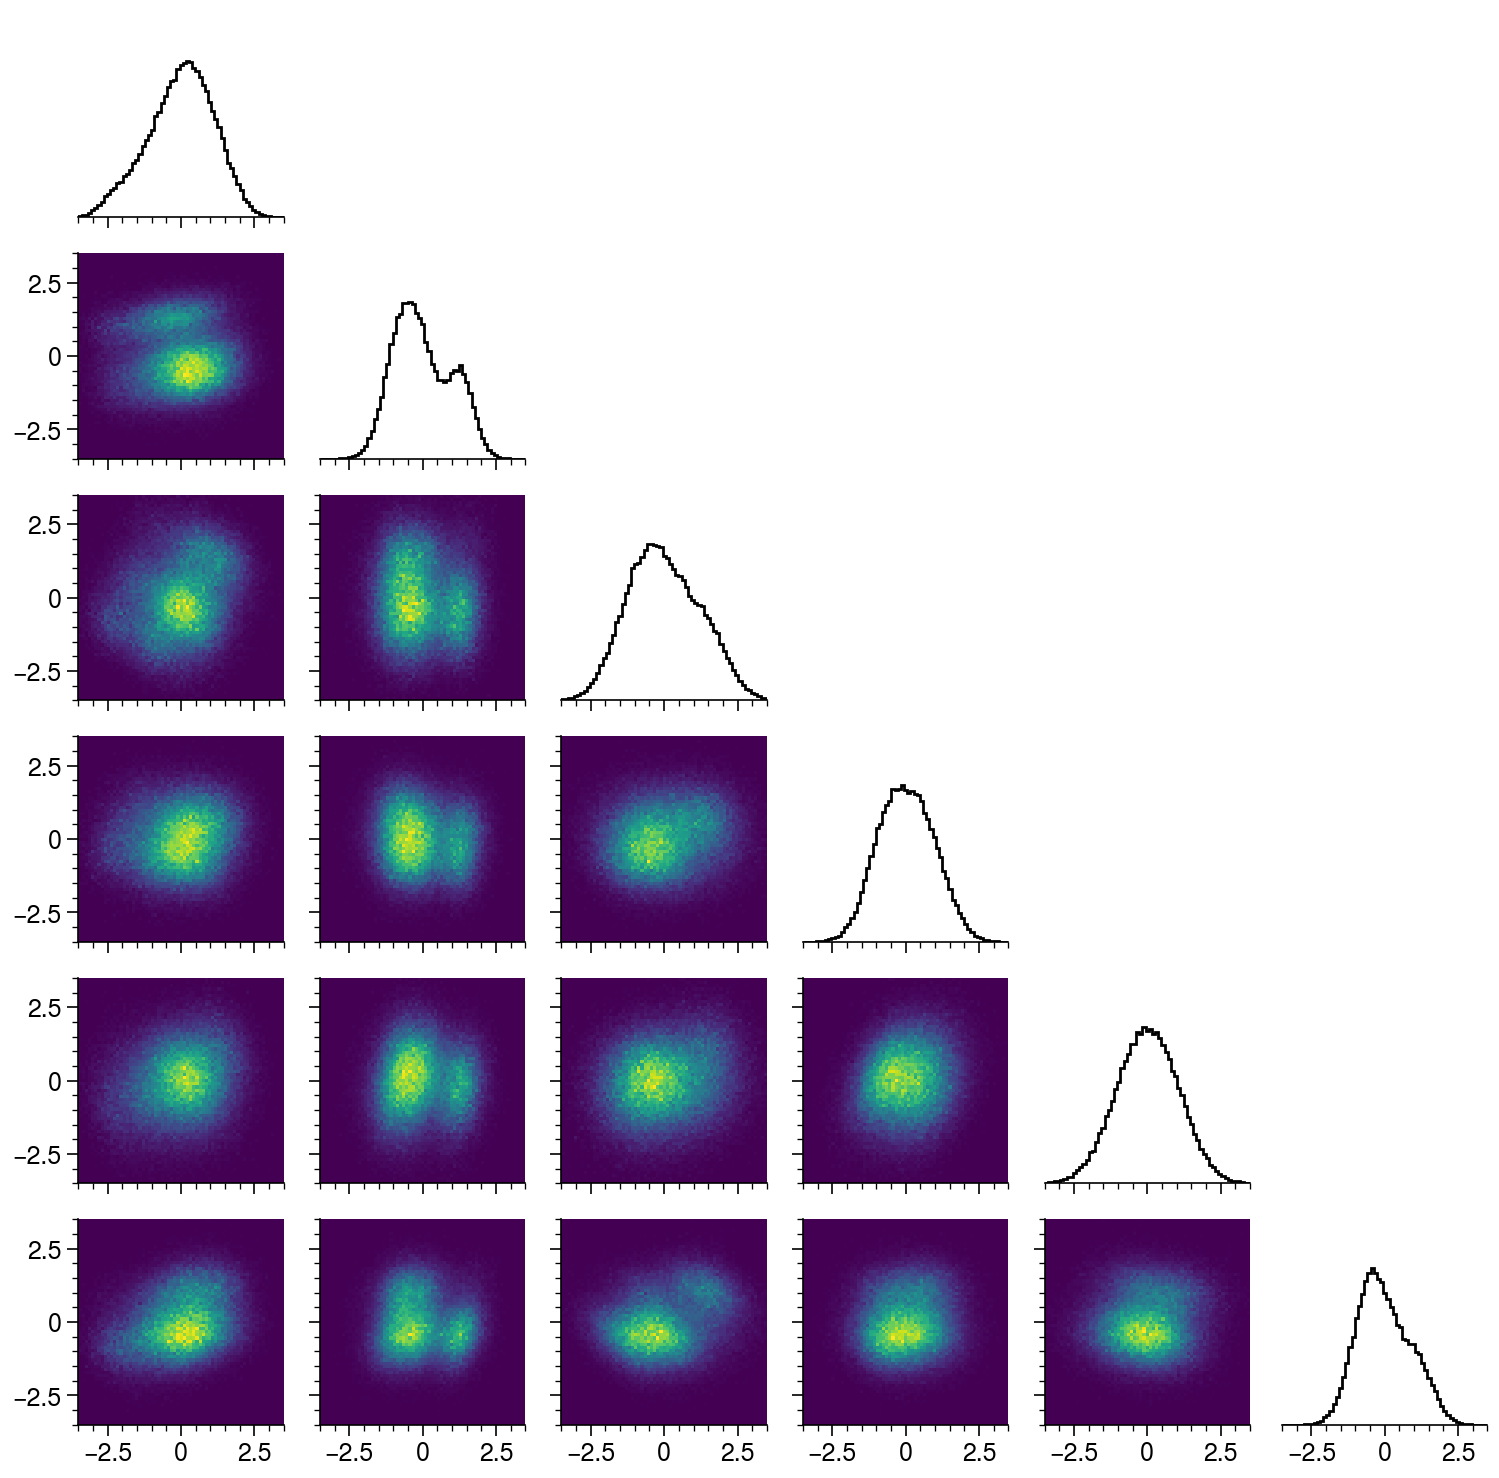

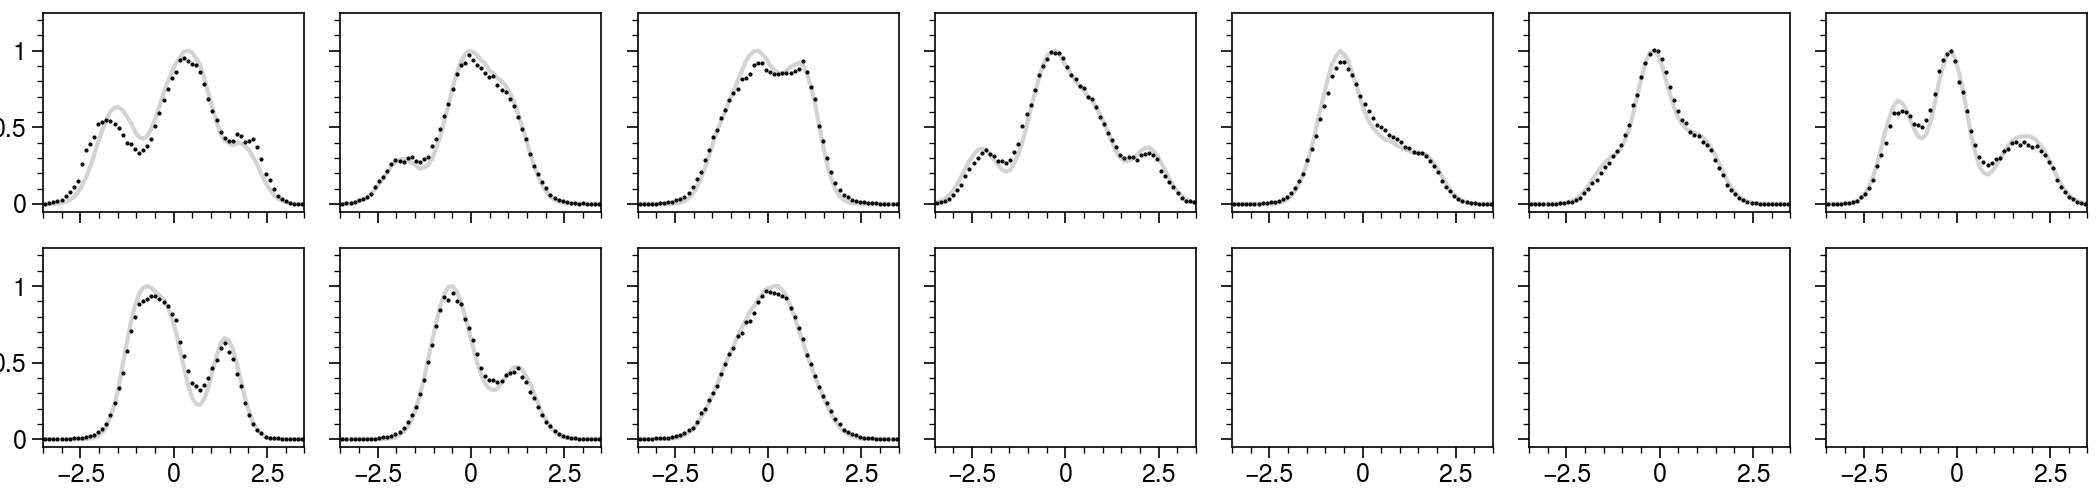

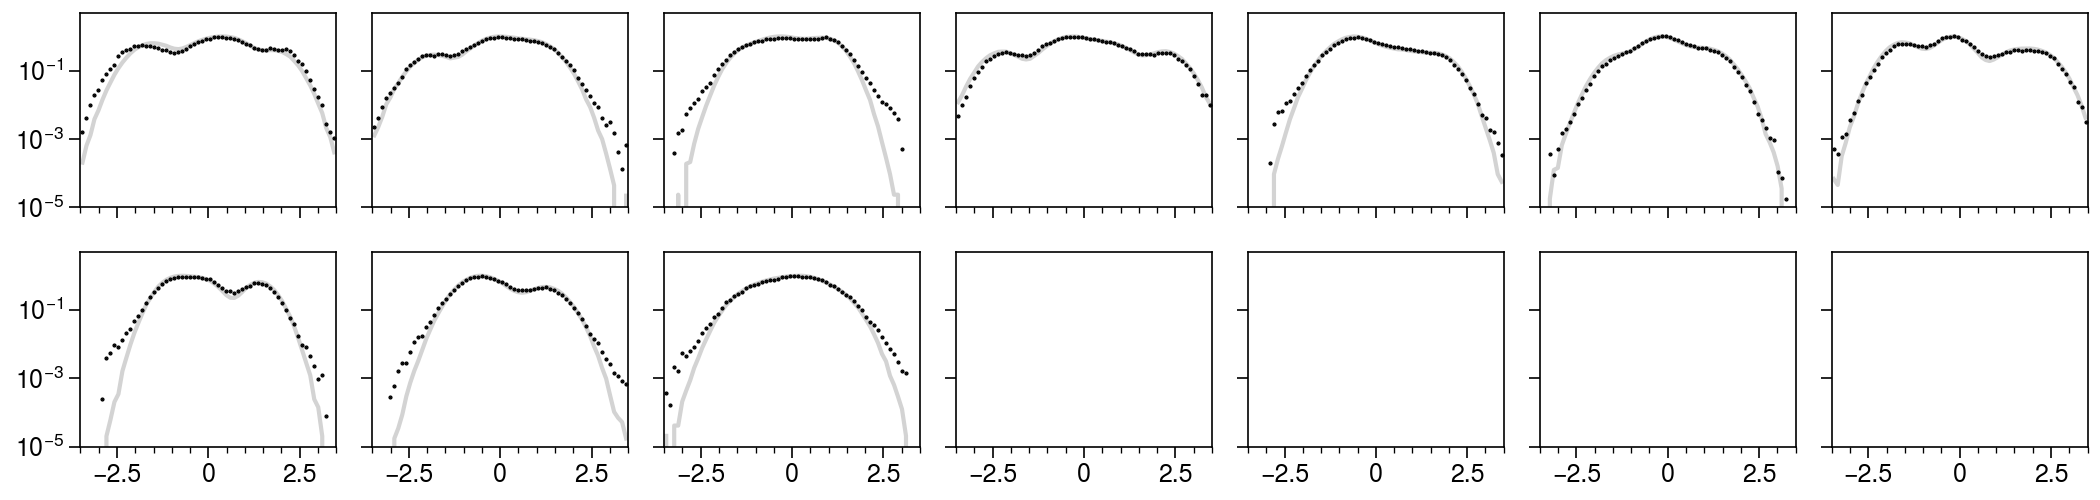

None
epoch = 2


  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  2%|███▎                                                                                                                                                           | 255/12015 [00:00<00:04, 2547.54it/s]

  4%|██████▉                                                                                                                                                        | 520/12015 [00:00<00:04, 2605.67it/s]

  7%|██████████▍                                                                                                                                                    | 785/12015 [00:00<00:04, 2624.32it/s]

  9%|█████████████▊                                                                                                                                                | 1048/12015 [00:00<00:04, 2621.69it/s]

 11%|█████████████████▏                                                                                                                                            | 1311/12015 [00:00<00:04, 2605.27it/s]

 13%|████████████████████▋                                                                                                                                         | 1575/12015 [00:00<00:03, 2616.60it/s]

 15%|████████████████████████▏                                                                                                                                     | 1840/12015 [00:00<00:03, 2625.97it/s]

 18%|███████████████████████████▋                                                                                                                                  | 2103/12015 [00:00<00:03, 2617.51it/s]

 20%|███████████████████████████████                                                                                                                               | 2366/12015 [00:00<00:03, 2618.52it/s]

 22%|██████████████████████████████████▌                                                                                                                           | 2628/12015 [00:01<00:03, 2610.09it/s]

 24%|██████████████████████████████████████                                                                                                                        | 2890/12015 [00:01<00:03, 2597.41it/s]

 26%|█████████████████████████████████████████▍                                                                                                                    | 3150/12015 [00:01<00:03, 2562.82it/s]

 28%|████████████████████████████████████████████▊                                                                                                                 | 3407/12015 [00:01<00:03, 2514.86it/s]

 30%|████████████████████████████████████████████████                                                                                                              | 3659/12015 [00:01<00:03, 2504.58it/s]

 33%|███████████████████████████████████████████████████▍                                                                                                          | 3910/12015 [00:01<00:03, 2491.60it/s]

 35%|██████████████████████████████████████████████████████▋                                                                                                       | 4160/12015 [00:01<00:03, 2480.13it/s]

 37%|█████████████████████████████████████████████████████████▉                                                                                                    | 4409/12015 [00:01<00:03, 2469.58it/s]

 39%|█████████████████████████████████████████████████████████████▏                                                                                                | 4656/12015 [00:01<00:02, 2466.42it/s]

 41%|████████████████████████████████████████████████████████████████▍                                                                                             | 4903/12015 [00:01<00:02, 2459.33it/s]

 43%|███████████████████████████████████████████████████████████████████▋                                                                                          | 5149/12015 [00:02<00:02, 2454.71it/s]

 45%|██████████████████████████████████████████████████████████████████████▉                                                                                       | 5398/12015 [00:02<00:02, 2463.53it/s]

 47%|██████████████████████████████████████████████████████████████████████████▏                                                                                   | 5645/12015 [00:02<00:02, 2462.15it/s]

 49%|█████████████████████████████████████████████████████████████████████████████▍                                                                                | 5892/12015 [00:02<00:02, 2447.85it/s]

 51%|████████████████████████████████████████████████████████████████████████████████▊                                                                             | 6142/12015 [00:02<00:02, 2462.73it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████                                                                          | 6392/12015 [00:02<00:02, 2472.55it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 6640/12015 [00:02<00:02, 2448.70it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 6885/12015 [00:02<00:02, 2445.88it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 7130/12015 [00:02<00:01, 2444.86it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 7378/12015 [00:02<00:01, 2452.70it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 7624/12015 [00:03<00:01, 2451.92it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 7876/12015 [00:03<00:01, 2471.08it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 8127/12015 [00:03<00:01, 2480.53it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 8378/12015 [00:03<00:01, 2488.96it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 8630/12015 [00:03<00:01, 2498.03it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 8882/12015 [00:03<00:01, 2502.25it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 9133/12015 [00:03<00:01, 2493.91it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 9383/12015 [00:03<00:01, 2476.62it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 9631/12015 [00:03<00:00, 2475.54it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 9879/12015 [00:03<00:00, 2475.43it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 10127/12015 [00:04<00:00, 2468.97it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 10374/12015 [00:04<00:00, 2461.90it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 10622/12015 [00:04<00:00, 2464.54it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 10871/12015 [00:04<00:00, 2470.31it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 11123/12015 [00:04<00:00, 2483.53it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 11372/12015 [00:04<00:00, 2480.32it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 11621/12015 [00:04<00:00, 2468.43it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 11870/12015 [00:04<00:00, 2473.57it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2499.29it/s]

  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  2%|███▎                                                                                                                                                           | 249/12015 [00:00<00:04, 2487.75it/s]

  4%|██████▌                                                                                                                                                        | 498/12015 [00:00<00:04, 2472.96it/s]

  6%|█████████▊                                                                                                                                                     | 746/12015 [00:00<00:04, 2467.00it/s]

  8%|█████████████▏                                                                                                                                                 | 993/12015 [00:00<00:04, 2465.65it/s]

 10%|████████████████▎                                                                                                                                             | 1244/12015 [00:00<00:04, 2478.98it/s]

 12%|███████████████████▋                                                                                                                                          | 1497/12015 [00:00<00:04, 2493.98it/s]

 15%|██████████████████████▉                                                                                                                                       | 1747/12015 [00:00<00:04, 2492.17it/s]

 17%|██████████████████████████▎                                                                                                                                   | 1997/12015 [00:00<00:04, 2484.92it/s]

 19%|█████████████████████████████▌                                                                                                                                | 2246/12015 [00:00<00:03, 2484.40it/s]

 21%|████████████████████████████████▊                                                                                                                             | 2495/12015 [00:01<00:03, 2476.44it/s]

 23%|████████████████████████████████████                                                                                                                          | 2744/12015 [00:01<00:03, 2477.59it/s]

 25%|███████████████████████████████████████▎                                                                                                                      | 2993/12015 [00:01<00:03, 2480.43it/s]

 27%|██████████████████████████████████████████▋                                                                                                                   | 3246/12015 [00:01<00:03, 2494.47it/s]

 29%|█████████████████████████████████████████████▉                                                                                                                | 3496/12015 [00:01<00:03, 2482.04it/s]

 31%|█████████████████████████████████████████████████▏                                                                                                            | 3745/12015 [00:01<00:03, 2477.08it/s]

 33%|████████████████████████████████████████████████████▌                                                                                                         | 3993/12015 [00:01<00:03, 2473.68it/s]

 35%|███████████████████████████████████████████████████████▊                                                                                                      | 4241/12015 [00:01<00:03, 2471.62it/s]

 37%|███████████████████████████████████████████████████████████                                                                                                   | 4489/12015 [00:01<00:03, 2465.81it/s]

 39%|██████████████████████████████████████████████████████████████▎                                                                                               | 4741/12015 [00:01<00:02, 2479.67it/s]

 42%|█████████████████████████████████████████████████████████████████▋                                                                                            | 4992/12015 [00:02<00:02, 2486.11it/s]

 44%|████████████████████████████████████████████████████████████████████▉                                                                                         | 5241/12015 [00:02<00:02, 2482.50it/s]

 46%|████████████████████████████████████████████████████████████████████████▏                                                                                     | 5491/12015 [00:02<00:02, 2487.32it/s]

 48%|███████████████████████████████████████████████████████████████████████████▌                                                                                  | 5745/12015 [00:02<00:02, 2500.37it/s]

 50%|██████████████████████████████████████████████████████████████████████████████▊                                                                               | 5996/12015 [00:02<00:02, 2490.76it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████▏                                                                           | 6246/12015 [00:02<00:02, 2480.20it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 6495/12015 [00:02<00:02, 2481.39it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 6749/12015 [00:02<00:02, 2497.62it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 6999/12015 [00:02<00:02, 2480.77it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 7250/12015 [00:02<00:01, 2486.60it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 7500/12015 [00:03<00:01, 2487.77it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 7753/12015 [00:03<00:01, 2500.03it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 8004/12015 [00:03<00:01, 2500.87it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 8255/12015 [00:03<00:01, 2503.07it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 8506/12015 [00:03<00:01, 2501.35it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 8759/12015 [00:03<00:01, 2507.18it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 9011/12015 [00:03<00:01, 2510.53it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 9264/12015 [00:03<00:01, 2513.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 9517/12015 [00:03<00:00, 2517.23it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 9769/12015 [00:03<00:00, 2516.59it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 10022/12015 [00:04<00:00, 2519.00it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 10275/12015 [00:04<00:00, 2520.91it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 10528/12015 [00:04<00:00, 2517.44it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 10780/12015 [00:04<00:00, 2515.69it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 11033/12015 [00:04<00:00, 2518.01it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 11286/12015 [00:04<00:00, 2519.95it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 11538/12015 [00:04<00:00, 2517.39it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 11790/12015 [00:04<00:00, 2516.71it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2495.64it/s]

  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  2%|███▎                                                                                                                                                           | 246/12015 [00:00<00:04, 2456.34it/s]

  4%|██████▌                                                                                                                                                        | 498/12015 [00:00<00:04, 2489.19it/s]

  6%|█████████▉                                                                                                                                                     | 747/12015 [00:00<00:04, 2489.12it/s]

  8%|█████████████▏                                                                                                                                                 | 996/12015 [00:00<00:04, 2472.87it/s]

 10%|████████████████▎                                                                                                                                             | 1245/12015 [00:00<00:04, 2476.99it/s]

 12%|███████████████████▋                                                                                                                                          | 1497/12015 [00:00<00:04, 2490.70it/s]

 15%|███████████████████████                                                                                                                                       | 1750/12015 [00:00<00:04, 2501.05it/s]

 17%|██████████████████████████▎                                                                                                                                   | 2001/12015 [00:00<00:04, 2500.45it/s]

 19%|█████████████████████████████▌                                                                                                                                | 2252/12015 [00:00<00:03, 2491.42it/s]

 21%|████████████████████████████████▉                                                                                                                             | 2502/12015 [00:01<00:03, 2483.53it/s]

 23%|████████████████████████████████████▏                                                                                                                         | 2754/12015 [00:01<00:03, 2492.18it/s]

 25%|███████████████████████████████████████▌                                                                                                                      | 3008/12015 [00:01<00:03, 2503.87it/s]

 27%|██████████████████████████████████████████▉                                                                                                                   | 3261/12015 [00:01<00:03, 2510.85it/s]

 29%|██████████████████████████████████████████████▏                                                                                                               | 3514/12015 [00:01<00:03, 2515.31it/s]

 31%|█████████████████████████████████████████████████▌                                                                                                            | 3767/12015 [00:01<00:03, 2517.70it/s]

 33%|████████████████████████████████████████████████████▊                                                                                                         | 4020/12015 [00:01<00:03, 2520.93it/s]

 36%|████████████████████████████████████████████████████████▏                                                                                                     | 4273/12015 [00:01<00:03, 2523.12it/s]

 38%|███████████████████████████████████████████████████████████▌                                                                                                  | 4526/12015 [00:01<00:02, 2518.70it/s]

 40%|██████████████████████████████████████████████████████████████▊                                                                                               | 4779/12015 [00:01<00:02, 2521.69it/s]

 42%|██████████████████████████████████████████████████████████████████▏                                                                                           | 5032/12015 [00:02<00:02, 2506.28it/s]

 44%|█████████████████████████████████████████████████████████████████████▍                                                                                        | 5283/12015 [00:02<00:02, 2491.46it/s]

 46%|████████████████████████████████████████████████████████████████████████▊                                                                                     | 5534/12015 [00:02<00:02, 2495.98it/s]

 48%|████████████████████████████████████████████████████████████████████████████                                                                                  | 5787/12015 [00:02<00:02, 2504.62it/s]

 50%|███████████████████████████████████████████████████████████████████████████████▍                                                                              | 6040/12015 [00:02<00:02, 2510.54it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████▊                                                                           | 6294/12015 [00:02<00:02, 2518.88it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████                                                                        | 6548/12015 [00:02<00:02, 2522.45it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 6802/12015 [00:02<00:02, 2524.78it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 7055/12015 [00:02<00:01, 2521.14it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 7310/12015 [00:02<00:01, 2527.36it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 7564/12015 [00:03<00:01, 2528.87it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 7817/12015 [00:03<00:01, 2528.59it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 8071/12015 [00:03<00:01, 2530.93it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 8325/12015 [00:03<00:01, 2533.12it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 8580/12015 [00:03<00:01, 2535.28it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 8834/12015 [00:03<00:01, 2507.17it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 9085/12015 [00:03<00:01, 2498.48it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 9335/12015 [00:03<00:01, 2482.38it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 9584/12015 [00:03<00:00, 2468.13it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 9831/12015 [00:03<00:00, 2466.00it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 10081/12015 [00:04<00:00, 2474.06it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 10329/12015 [00:04<00:00, 2459.48it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 10575/12015 [00:04<00:00, 2456.17it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 10827/12015 [00:04<00:00, 2472.70it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 11079/12015 [00:04<00:00, 2484.58it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 11328/12015 [00:04<00:00, 2478.80it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 11580/12015 [00:04<00:00, 2488.43it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 11829/12015 [00:04<00:00, 2486.21it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2500.27it/s]

  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  2%|███▎                                                                                                                                                           | 252/12015 [00:00<00:04, 2514.37it/s]

  4%|██████▋                                                                                                                                                        | 504/12015 [00:00<00:04, 2509.33it/s]

  6%|██████████                                                                                                                                                     | 756/12015 [00:00<00:04, 2513.36it/s]

  8%|█████████████▎                                                                                                                                                | 1010/12015 [00:00<00:04, 2522.74it/s]

 11%|████████████████▌                                                                                                                                             | 1263/12015 [00:00<00:04, 2522.55it/s]

 13%|███████████████████▉                                                                                                                                          | 1516/12015 [00:00<00:04, 2521.86it/s]

 15%|███████████████████████▎                                                                                                                                      | 1769/12015 [00:00<00:04, 2510.09it/s]

 17%|██████████████████████████▌                                                                                                                                   | 2023/12015 [00:00<00:03, 2516.60it/s]

 19%|█████████████████████████████▉                                                                                                                                | 2277/12015 [00:00<00:03, 2521.43it/s]

 21%|█████████████████████████████████▎                                                                                                                            | 2530/12015 [00:01<00:03, 2519.58it/s]

 23%|████████████████████████████████████▌                                                                                                                         | 2784/12015 [00:01<00:03, 2522.79it/s]

 25%|███████████████████████████████████████▉                                                                                                                      | 3037/12015 [00:01<00:03, 2514.51it/s]

 27%|███████████████████████████████████████████▎                                                                                                                  | 3289/12015 [00:01<00:03, 2515.26it/s]

 29%|██████████████████████████████████████████████▌                                                                                                               | 3541/12015 [00:01<00:03, 2515.21it/s]

 32%|█████████████████████████████████████████████████▉                                                                                                            | 3793/12015 [00:01<00:03, 2516.57it/s]

 34%|█████████████████████████████████████████████████████▏                                                                                                        | 4045/12015 [00:01<00:03, 2516.76it/s]

 36%|████████████████████████████████████████████████████████▌                                                                                                     | 4297/12015 [00:01<00:03, 2502.83it/s]

 38%|███████████████████████████████████████████████████████████▊                                                                                                  | 4548/12015 [00:01<00:03, 2488.33it/s]

 40%|███████████████████████████████████████████████████████████████▏                                                                                              | 4801/12015 [00:01<00:02, 2498.17it/s]

 42%|██████████████████████████████████████████████████████████████████▍                                                                                           | 5054/12015 [00:02<00:02, 2505.64it/s]

 44%|█████████████████████████████████████████████████████████████████████▊                                                                                        | 5307/12015 [00:02<00:02, 2510.99it/s]

 46%|█████████████████████████████████████████████████████████████████████████                                                                                     | 5560/12015 [00:02<00:02, 2516.11it/s]

 48%|████████████████████████████████████████████████████████████████████████████▍                                                                                 | 5813/12015 [00:02<00:02, 2517.59it/s]

 50%|███████████████████████████████████████████████████████████████████████████████▊                                                                              | 6067/12015 [00:02<00:02, 2522.88it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████                                                                           | 6320/12015 [00:02<00:02, 2520.01it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 6573/12015 [00:02<00:02, 2520.39it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 6826/12015 [00:02<00:02, 2523.00it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 7079/12015 [00:02<00:01, 2522.53it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 7332/12015 [00:02<00:01, 2521.64it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 7585/12015 [00:03<00:01, 2522.37it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 7839/12015 [00:03<00:01, 2524.79it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 8092/12015 [00:03<00:01, 2526.25it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 8346/12015 [00:03<00:01, 2528.06it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 8599/12015 [00:03<00:01, 2510.01it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 8851/12015 [00:03<00:01, 2471.14it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 9099/12015 [00:03<00:01, 2441.14it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 9344/12015 [00:03<00:01, 2417.65it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 9586/12015 [00:03<00:01, 2402.82it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 9827/12015 [00:03<00:00, 2396.22it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 10067/12015 [00:04<00:00, 2390.58it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 10307/12015 [00:04<00:00, 2380.42it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 10546/12015 [00:04<00:00, 2380.41it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 10786/12015 [00:04<00:00, 2384.62it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 11025/12015 [00:04<00:00, 2385.21it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 11271/12015 [00:04<00:00, 2406.30it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 11512/12015 [00:04<00:00, 2401.93it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 11753/12015 [00:04<00:00, 2395.63it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 11997/12015 [00:04<00:00, 2406.37it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2477.62it/s]

  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  2%|███▎                                                                                                                                                           | 247/12015 [00:00<00:04, 2463.10it/s]

  4%|██████▌                                                                                                                                                        | 494/12015 [00:00<00:04, 2419.23it/s]

  6%|█████████▊                                                                                                                                                     | 738/12015 [00:00<00:04, 2426.84it/s]

  8%|████████████▉                                                                                                                                                  | 981/12015 [00:00<00:04, 2395.89it/s]

 10%|████████████████                                                                                                                                              | 1223/12015 [00:00<00:04, 2403.63it/s]

 12%|███████████████████▎                                                                                                                                          | 1464/12015 [00:00<00:04, 2382.87it/s]

 14%|██████████████████████▍                                                                                                                                       | 1704/12015 [00:00<00:04, 2387.30it/s]

 16%|█████████████████████████▌                                                                                                                                    | 1948/12015 [00:00<00:04, 2402.06it/s]

 18%|████████████████████████████▊                                                                                                                                 | 2189/12015 [00:00<00:04, 2385.85it/s]

 20%|███████████████████████████████▉                                                                                                                              | 2428/12015 [00:01<00:04, 2372.64it/s]

 22%|███████████████████████████████████                                                                                                                           | 2670/12015 [00:01<00:03, 2386.47it/s]

 24%|██████████████████████████████████████▍                                                                                                                       | 2920/12015 [00:01<00:03, 2419.78it/s]

 26%|█████████████████████████████████████████▌                                                                                                                    | 3165/12015 [00:01<00:03, 2426.31it/s]

 28%|████████████████████████████████████████████▊                                                                                                                 | 3408/12015 [00:01<00:03, 2427.20it/s]

 30%|████████████████████████████████████████████████                                                                                                              | 3651/12015 [00:01<00:03, 2420.99it/s]

 32%|███████████████████████████████████████████████████▏                                                                                                          | 3894/12015 [00:01<00:03, 2394.68it/s]

 34%|██████████████████████████████████████████████████████▍                                                                                                       | 4139/12015 [00:01<00:03, 2410.37it/s]

 36%|█████████████████████████████████████████████████████████▋                                                                                                    | 4384/12015 [00:01<00:03, 2419.94it/s]

 39%|████████████████████████████████████████████████████████████▊                                                                                                 | 4627/12015 [00:01<00:03, 2417.41it/s]

 41%|████████████████████████████████████████████████████████████████                                                                                              | 4869/12015 [00:02<00:02, 2397.30it/s]

 43%|███████████████████████████████████████████████████████████████████▎                                                                                          | 5115/12015 [00:02<00:02, 2415.85it/s]

 45%|██████████████████████████████████████████████████████████████████████▍                                                                                       | 5359/12015 [00:02<00:02, 2420.75it/s]

 47%|█████████████████████████████████████████████████████████████████████████▋                                                                                    | 5602/12015 [00:02<00:02, 2422.94it/s]

 49%|████████████████████████████████████████████████████████████████████████████▊                                                                                 | 5845/12015 [00:02<00:02, 2424.12it/s]

 51%|████████████████████████████████████████████████████████████████████████████████                                                                              | 6088/12015 [00:02<00:02, 2422.78it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████▎                                                                          | 6331/12015 [00:02<00:02, 2422.45it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 6576/12015 [00:02<00:02, 2428.49it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 6826/12015 [00:02<00:02, 2447.97it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 7071/12015 [00:02<00:02, 2441.46it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 7316/12015 [00:03<00:01, 2434.59it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 7560/12015 [00:03<00:01, 2433.50it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 7806/12015 [00:03<00:01, 2439.38it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 8051/12015 [00:03<00:01, 2441.40it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 8296/12015 [00:03<00:01, 2442.09it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 8541/12015 [00:03<00:01, 2440.56it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 8786/12015 [00:03<00:01, 2424.77it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 9030/12015 [00:03<00:01, 2426.89it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 9274/12015 [00:03<00:01, 2430.16it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 9522/12015 [00:03<00:01, 2443.31it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 9767/12015 [00:04<00:00, 2427.60it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 10011/12015 [00:04<00:00, 2430.33it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 10255/12015 [00:04<00:00, 2415.76it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 10500/12015 [00:04<00:00, 2423.80it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 10747/12015 [00:04<00:00, 2435.74it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 10991/12015 [00:04<00:00, 2431.44it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 11235/12015 [00:04<00:00, 2429.01it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 11479/12015 [00:04<00:00, 2431.38it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 11723/12015 [00:04<00:00, 2430.11it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 11967/12015 [00:04<00:00, 2428.16it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2421.34it/s]

  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  2%|███▎                                                                                                                                                           | 249/12015 [00:00<00:04, 2486.82it/s]

  4%|██████▌                                                                                                                                                        | 498/12015 [00:00<00:04, 2469.38it/s]

  6%|█████████▊                                                                                                                                                     | 745/12015 [00:00<00:04, 2462.08it/s]

  8%|█████████████▏                                                                                                                                                 | 992/12015 [00:00<00:04, 2459.61it/s]

 10%|████████████████▎                                                                                                                                             | 1238/12015 [00:00<00:04, 2458.55it/s]

 12%|███████████████████▌                                                                                                                                          | 1484/12015 [00:00<00:04, 2452.63it/s]

 14%|██████████████████████▋                                                                                                                                       | 1730/12015 [00:00<00:04, 2445.57it/s]

 16%|█████████████████████████▉                                                                                                                                    | 1975/12015 [00:00<00:04, 2443.21it/s]

 18%|█████████████████████████████▏                                                                                                                                | 2220/12015 [00:00<00:04, 2412.39it/s]

 21%|████████████████████████████████▍                                                                                                                             | 2464/12015 [00:01<00:03, 2418.14it/s]

 23%|███████████████████████████████████▋                                                                                                                          | 2710/12015 [00:01<00:03, 2429.21it/s]

 25%|██████████████████████████████████████▊                                                                                                                       | 2956/12015 [00:01<00:03, 2438.45it/s]

 27%|██████████████████████████████████████████                                                                                                                    | 3203/12015 [00:01<00:03, 2447.81it/s]

 29%|█████████████████████████████████████████████▎                                                                                                                | 3448/12015 [00:01<00:03, 2446.33it/s]

 31%|████████████████████████████████████████████████▌                                                                                                             | 3695/12015 [00:01<00:03, 2451.55it/s]

 33%|███████████████████████████████████████████████████▊                                                                                                          | 3943/12015 [00:01<00:03, 2457.32it/s]

 35%|███████████████████████████████████████████████████████▏                                                                                                      | 4194/12015 [00:01<00:03, 2473.05it/s]

 37%|██████████████████████████████████████████████████████████▍                                                                                                   | 4442/12015 [00:01<00:03, 2466.44it/s]

 39%|█████████████████████████████████████████████████████████████▋                                                                                                | 4689/12015 [00:01<00:02, 2461.54it/s]

 41%|████████████████████████████████████████████████████████████████▉                                                                                             | 4936/12015 [00:02<00:02, 2459.31it/s]

 43%|████████████████████████████████████████████████████████████████████▏                                                                                         | 5183/12015 [00:02<00:02, 2460.33it/s]

 45%|███████████████████████████████████████████████████████████████████████▍                                                                                      | 5430/12015 [00:02<00:02, 2454.82it/s]

 47%|██████████████████████████████████████████████████████████████████████████▋                                                                                   | 5676/12015 [00:02<00:02, 2454.13it/s]

 49%|█████████████████████████████████████████████████████████████████████████████▉                                                                                | 5922/12015 [00:02<00:02, 2450.58it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████                                                                             | 6168/12015 [00:02<00:02, 2449.97it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 6414/12015 [00:02<00:02, 2451.89it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 6660/12015 [00:02<00:02, 2450.13it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 6912/12015 [00:02<00:02, 2468.99it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 7159/12015 [00:02<00:01, 2466.16it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 7406/12015 [00:03<00:01, 2465.55it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 7653/12015 [00:03<00:01, 2457.71it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 7900/12015 [00:03<00:01, 2459.22it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 8149/12015 [00:03<00:01, 2466.95it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 8396/12015 [00:03<00:01, 2466.84it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 8643/12015 [00:03<00:01, 2465.13it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 8894/12015 [00:03<00:01, 2478.12it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 9148/12015 [00:03<00:01, 2494.63it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 9398/12015 [00:03<00:01, 2492.43it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 9648/12015 [00:03<00:01, 2366.01it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 9886/12015 [00:04<00:00, 2295.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 10117/12015 [00:04<00:00, 2252.20it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 10344/12015 [00:04<00:00, 2221.00it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 10567/12015 [00:04<00:00, 2203.36it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 10788/12015 [00:04<00:00, 2185.31it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 11007/12015 [00:04<00:00, 2170.38it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 11225/12015 [00:04<00:00, 2164.57it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 11442/12015 [00:04<00:00, 2159.70it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 11659/12015 [00:04<00:00, 2147.57it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 11874/12015 [00:04<00:00, 2147.98it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:05<00:00, 2381.93it/s]

  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  2%|███▎                                                                                                                                                           | 253/12015 [00:00<00:04, 2520.47it/s]

  4%|██████▋                                                                                                                                                        | 506/12015 [00:00<00:04, 2492.89it/s]

  6%|██████████                                                                                                                                                     | 758/12015 [00:00<00:04, 2503.56it/s]

  8%|█████████████▎                                                                                                                                                | 1009/12015 [00:00<00:04, 2502.08it/s]

 11%|████████████████▌                                                                                                                                             | 1263/12015 [00:00<00:04, 2512.42it/s]

 13%|███████████████████▉                                                                                                                                          | 1516/12015 [00:00<00:04, 2517.85it/s]

 15%|███████████████████████▎                                                                                                                                      | 1770/12015 [00:00<00:04, 2523.37it/s]

 17%|██████████████████████████▌                                                                                                                                   | 2023/12015 [00:00<00:03, 2519.12it/s]

 19%|█████████████████████████████▉                                                                                                                                | 2275/12015 [00:00<00:03, 2503.01it/s]

 21%|█████████████████████████████████▏                                                                                                                            | 2526/12015 [00:01<00:03, 2497.76it/s]

 23%|████████████████████████████████████▌                                                                                                                         | 2776/12015 [00:01<00:03, 2497.63it/s]

 25%|███████████████████████████████████████▊                                                                                                                      | 3028/12015 [00:01<00:03, 2504.28it/s]

 27%|███████████████████████████████████████████                                                                                                                   | 3279/12015 [00:01<00:03, 2493.07it/s]

 29%|██████████████████████████████████████████████▍                                                                                                               | 3532/12015 [00:01<00:03, 2501.58it/s]

 32%|█████████████████████████████████████████████████▊                                                                                                            | 3785/12015 [00:01<00:03, 2507.42it/s]

 34%|█████████████████████████████████████████████████████                                                                                                         | 4039/12015 [00:01<00:03, 2516.34it/s]

 36%|████████████████████████████████████████████████████████▍                                                                                                     | 4294/12015 [00:01<00:03, 2523.93it/s]

 38%|███████████████████████████████████████████████████████████▊                                                                                                  | 4547/12015 [00:01<00:02, 2523.98it/s]

 40%|███████████████████████████████████████████████████████████████                                                                                               | 4800/12015 [00:01<00:02, 2525.58it/s]

 42%|██████████████████████████████████████████████████████████████████▍                                                                                           | 5053/12015 [00:02<00:02, 2518.06it/s]

 44%|█████████████████████████████████████████████████████████████████████▊                                                                                        | 5306/12015 [00:02<00:02, 2521.51it/s]

 46%|█████████████████████████████████████████████████████████████████████████                                                                                     | 5559/12015 [00:02<00:02, 2517.59it/s]

 48%|████████████████████████████████████████████████████████████████████████████▍                                                                                 | 5811/12015 [00:02<00:02, 2514.76it/s]

 50%|███████████████████████████████████████████████████████████████████████████████▋                                                                              | 6064/12015 [00:02<00:02, 2517.73it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████                                                                           | 6319/12015 [00:02<00:02, 2526.02it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 6574/12015 [00:02<00:02, 2531.57it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 6828/12015 [00:02<00:02, 2524.50it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 7081/12015 [00:02<00:01, 2519.28it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 7333/12015 [00:02<00:01, 2515.32it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 7585/12015 [00:03<00:01, 2508.28it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 7837/12015 [00:03<00:01, 2509.77it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 8088/12015 [00:03<00:01, 2505.97it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 8340/12015 [00:03<00:01, 2508.01it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 8594/12015 [00:03<00:01, 2514.69it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 8846/12015 [00:03<00:01, 2516.04it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 9099/12015 [00:03<00:01, 2517.59it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 9351/12015 [00:03<00:01, 2516.25it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 9604/12015 [00:03<00:00, 2519.89it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 9856/12015 [00:03<00:00, 2507.11it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 10107/12015 [00:04<00:00, 2505.09it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 10360/12015 [00:04<00:00, 2510.88it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 10612/12015 [00:04<00:00, 2503.29it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 10863/12015 [00:04<00:00, 2500.47it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 11115/12015 [00:04<00:00, 2503.58it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 11370/12015 [00:04<00:00, 2515.00it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 11625/12015 [00:04<00:00, 2523.02it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 11879/12015 [00:04<00:00, 2527.81it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2514.01it/s]

  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  2%|███▎                                                                                                                                                           | 251/12015 [00:00<00:04, 2504.89it/s]

  4%|██████▋                                                                                                                                                        | 503/12015 [00:00<00:04, 2508.08it/s]

  6%|██████████                                                                                                                                                     | 756/12015 [00:00<00:04, 2517.50it/s]

  8%|█████████████▎                                                                                                                                                | 1009/12015 [00:00<00:04, 2521.77it/s]

 11%|████████████████▌                                                                                                                                             | 1262/12015 [00:00<00:04, 2516.69it/s]

 13%|███████████████████▉                                                                                                                                          | 1514/12015 [00:00<00:04, 2506.86it/s]

 15%|███████████████████████▏                                                                                                                                      | 1765/12015 [00:00<00:04, 2499.49it/s]

 17%|██████████████████████████▌                                                                                                                                   | 2016/12015 [00:00<00:03, 2500.99it/s]

 19%|█████████████████████████████▊                                                                                                                                | 2267/12015 [00:00<00:03, 2499.79it/s]

 21%|█████████████████████████████████                                                                                                                             | 2518/12015 [00:01<00:03, 2501.66it/s]

 23%|████████████████████████████████████▍                                                                                                                         | 2771/12015 [00:01<00:03, 2509.71it/s]

 25%|███████████████████████████████████████▊                                                                                                                      | 3025/12015 [00:01<00:03, 2516.86it/s]

 27%|███████████████████████████████████████████                                                                                                                   | 3279/12015 [00:01<00:03, 2520.97it/s]

 29%|██████████████████████████████████████████████▍                                                                                                               | 3532/12015 [00:01<00:03, 2523.20it/s]

 32%|█████████████████████████████████████████████████▊                                                                                                            | 3785/12015 [00:01<00:03, 2474.65it/s]

 34%|█████████████████████████████████████████████████████                                                                                                         | 4033/12015 [00:01<00:03, 2462.28it/s]

 36%|████████████████████████████████████████████████████████▎                                                                                                     | 4280/12015 [00:01<00:03, 2455.21it/s]

 38%|███████████████████████████████████████████████████████████▌                                                                                                  | 4528/12015 [00:01<00:03, 2459.71it/s]

 40%|██████████████████████████████████████████████████████████████▊                                                                                               | 4777/12015 [00:01<00:02, 2467.01it/s]

 42%|██████████████████████████████████████████████████████████████████                                                                                            | 5027/12015 [00:02<00:02, 2474.86it/s]

 44%|█████████████████████████████████████████████████████████████████████▍                                                                                        | 5278/12015 [00:02<00:02, 2485.27it/s]

 46%|████████████████████████████████████████████████████████████████████████▋                                                                                     | 5531/12015 [00:02<00:02, 2496.40it/s]

 48%|████████████████████████████████████████████████████████████████████████████                                                                                  | 5782/12015 [00:02<00:02, 2498.77it/s]

 50%|███████████████████████████████████████████████████████████████████████████████▎                                                                              | 6032/12015 [00:02<00:02, 2490.85it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████▌                                                                           | 6282/12015 [00:02<00:02, 2490.49it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 6535/12015 [00:02<00:02, 2501.89it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 6789/12015 [00:02<00:02, 2513.26it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 7041/12015 [00:02<00:01, 2514.18it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 7293/12015 [00:02<00:01, 2512.54it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 7546/12015 [00:03<00:01, 2517.24it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 7798/12015 [00:03<00:01, 2509.90it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 8051/12015 [00:03<00:01, 2512.58it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 8303/12015 [00:03<00:01, 2512.70it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 8555/12015 [00:03<00:01, 2514.75it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 8809/12015 [00:03<00:01, 2519.89it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 9061/12015 [00:03<00:01, 2506.97it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 9312/12015 [00:03<00:01, 2501.31it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 9563/12015 [00:03<00:00, 2502.05it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 9814/12015 [00:03<00:00, 2495.74it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 10064/12015 [00:04<00:00, 2491.58it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 10315/12015 [00:04<00:00, 2495.65it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 10569/12015 [00:04<00:00, 2507.00it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 10823/12015 [00:04<00:00, 2515.91it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 11078/12015 [00:04<00:00, 2523.27it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 11331/12015 [00:04<00:00, 2513.30it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 11583/12015 [00:04<00:00, 2501.11it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 11834/12015 [00:04<00:00, 2501.70it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2501.71it/s]

  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  2%|███▎                                                                                                                                                           | 251/12015 [00:00<00:04, 2505.35it/s]

  4%|██████▋                                                                                                                                                        | 503/12015 [00:00<00:04, 2513.44it/s]

  6%|██████████                                                                                                                                                     | 757/12015 [00:00<00:04, 2521.93it/s]

  8%|█████████████▎                                                                                                                                                | 1010/12015 [00:00<00:04, 2520.86it/s]

 11%|████████████████▌                                                                                                                                             | 1263/12015 [00:00<00:04, 2523.94it/s]

 13%|███████████████████▉                                                                                                                                          | 1517/12015 [00:00<00:04, 2526.13it/s]

 15%|███████████████████████▎                                                                                                                                      | 1770/12015 [00:00<00:04, 2522.99it/s]

 17%|██████████████████████████▌                                                                                                                                   | 2024/12015 [00:00<00:03, 2527.53it/s]

 19%|█████████████████████████████▉                                                                                                                                | 2277/12015 [00:00<00:03, 2505.39it/s]

 21%|█████████████████████████████████▏                                                                                                                            | 2528/12015 [00:01<00:03, 2491.20it/s]

 23%|████████████████████████████████████▌                                                                                                                         | 2781/12015 [00:01<00:03, 2501.86it/s]

 25%|███████████████████████████████████████▊                                                                                                                      | 3032/12015 [00:01<00:03, 2499.20it/s]

 27%|███████████████████████████████████████████▏                                                                                                                  | 3282/12015 [00:01<00:03, 2499.15it/s]

 29%|██████████████████████████████████████████████▍                                                                                                               | 3534/12015 [00:01<00:03, 2504.02it/s]

 32%|█████████████████████████████████████████████████▊                                                                                                            | 3787/12015 [00:01<00:03, 2510.64it/s]

 34%|█████████████████████████████████████████████████████▏                                                                                                        | 4040/12015 [00:01<00:03, 2515.55it/s]

 36%|████████████████████████████████████████████████████████▍                                                                                                     | 4292/12015 [00:01<00:03, 2515.87it/s]

 38%|███████████████████████████████████████████████████████████▊                                                                                                  | 4545/12015 [00:01<00:02, 2520.07it/s]

 40%|███████████████████████████████████████████████████████████████                                                                                               | 4799/12015 [00:01<00:02, 2523.89it/s]

 42%|██████████████████████████████████████████████████████████████████▍                                                                                           | 5053/12015 [00:02<00:02, 2527.78it/s]

 44%|█████████████████████████████████████████████████████████████████████▊                                                                                        | 5308/12015 [00:02<00:02, 2533.06it/s]

 46%|█████████████████████████████████████████████████████████████████████████▏                                                                                    | 5562/12015 [00:02<00:02, 2523.13it/s]

 48%|████████████████████████████████████████████████████████████████████████████▍                                                                                 | 5815/12015 [00:02<00:02, 2517.16it/s]

 50%|███████████████████████████████████████████████████████████████████████████████▊                                                                              | 6067/12015 [00:02<00:02, 2511.73it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████                                                                           | 6319/12015 [00:02<00:02, 2505.74it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 6571/12015 [00:02<00:02, 2507.25it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 6822/12015 [00:02<00:02, 2507.68it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 7073/12015 [00:02<00:01, 2498.21it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 7325/12015 [00:02<00:01, 2502.74it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 7580/12015 [00:03<00:01, 2515.66it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 7835/12015 [00:03<00:01, 2525.22it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 8088/12015 [00:03<00:01, 2509.29it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 8342/12015 [00:03<00:01, 2518.30it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 8594/12015 [00:03<00:01, 2518.66it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 8846/12015 [00:03<00:01, 2513.74it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 9098/12015 [00:03<00:01, 2515.57it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 9350/12015 [00:03<00:01, 2513.63it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 9603/12015 [00:03<00:00, 2517.07it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 9858/12015 [00:03<00:00, 2525.15it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 10114/12015 [00:04<00:00, 2532.74it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 10368/12015 [00:04<00:00, 2527.32it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 10621/12015 [00:04<00:00, 2521.09it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 10876/12015 [00:04<00:00, 2527.40it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 11129/12015 [00:04<00:00, 2527.96it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 11382/12015 [00:04<00:00, 2517.53it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 11634/12015 [00:04<00:00, 2515.73it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 11886/12015 [00:04<00:00, 2514.00it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2515.76it/s]

  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  2%|███▎                                                                                                                                                           | 252/12015 [00:00<00:04, 2510.12it/s]

  4%|██████▋                                                                                                                                                        | 504/12015 [00:00<00:04, 2487.16it/s]

  6%|█████████▉                                                                                                                                                     | 753/12015 [00:00<00:04, 2486.25it/s]

  8%|█████████████▏                                                                                                                                                | 1004/12015 [00:00<00:04, 2493.97it/s]

 10%|████████████████▌                                                                                                                                             | 1257/12015 [00:00<00:04, 2504.04it/s]

 13%|███████████████████▊                                                                                                                                          | 1509/12015 [00:00<00:04, 2507.71it/s]

 15%|███████████████████████▏                                                                                                                                      | 1763/12015 [00:00<00:04, 2515.30it/s]

 17%|██████████████████████████▌                                                                                                                                   | 2017/12015 [00:00<00:03, 2520.47it/s]

 19%|█████████████████████████████▊                                                                                                                                | 2271/12015 [00:00<00:03, 2523.78it/s]

 21%|█████████████████████████████████▏                                                                                                                            | 2524/12015 [00:01<00:03, 2510.44it/s]

 23%|████████████████████████████████████▌                                                                                                                         | 2776/12015 [00:01<00:03, 2510.30it/s]

 25%|███████████████████████████████████████▊                                                                                                                      | 3028/12015 [00:01<00:03, 2510.66it/s]

 27%|███████████████████████████████████████████▏                                                                                                                  | 3280/12015 [00:01<00:03, 2512.92it/s]

 29%|██████████████████████████████████████████████▍                                                                                                               | 3532/12015 [00:01<00:03, 2509.53it/s]

 32%|█████████████████████████████████████████████████▊                                                                                                            | 3786/12015 [00:01<00:03, 2518.18it/s]

 34%|█████████████████████████████████████████████████████▏                                                                                                        | 4040/12015 [00:01<00:03, 2523.70it/s]

 36%|████████████████████████████████████████████████████████▍                                                                                                     | 4293/12015 [00:01<00:03, 2521.72it/s]

 38%|███████████████████████████████████████████████████████████▊                                                                                                  | 4547/12015 [00:01<00:02, 2525.97it/s]

 40%|███████████████████████████████████████████████████████████████▏                                                                                              | 4801/12015 [00:01<00:02, 2528.71it/s]

 42%|██████████████████████████████████████████████████████████████████▍                                                                                           | 5054/12015 [00:02<00:02, 2525.11it/s]

 44%|█████████████████████████████████████████████████████████████████████▊                                                                                        | 5307/12015 [00:02<00:02, 2524.09it/s]

 46%|█████████████████████████████████████████████████████████████████████████                                                                                     | 5560/12015 [00:02<00:02, 2521.16it/s]

 48%|████████████████████████████████████████████████████████████████████████████▍                                                                                 | 5813/12015 [00:02<00:02, 2508.81it/s]

 50%|███████████████████████████████████████████████████████████████████████████████▋                                                                              | 6064/12015 [00:02<00:02, 2508.49it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████                                                                           | 6318/12015 [00:02<00:02, 2516.80it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 6573/12015 [00:02<00:02, 2526.31it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 6826/12015 [00:02<00:02, 2525.83it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 7080/12015 [00:02<00:01, 2528.40it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 7333/12015 [00:02<00:01, 2515.26it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 7585/12015 [00:03<00:01, 2507.21it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 7837/12015 [00:03<00:01, 2508.76it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 8088/12015 [00:03<00:01, 2508.69it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 8339/12015 [00:03<00:01, 2506.71it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 8590/12015 [00:03<00:01, 2502.90it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 8845/12015 [00:03<00:01, 2515.26it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 9099/12015 [00:03<00:01, 2520.77it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 9352/12015 [00:03<00:01, 2516.92it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 9608/12015 [00:03<00:00, 2527.61it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 9861/12015 [00:03<00:00, 2523.73it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 10114/12015 [00:04<00:00, 2523.53it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 10367/12015 [00:04<00:00, 2521.81it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 10620/12015 [00:04<00:00, 2522.79it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 10873/12015 [00:04<00:00, 2523.78it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 11126/12015 [00:04<00:00, 2517.22it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 11379/12015 [00:04<00:00, 2518.82it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 11634/12015 [00:04<00:00, 2527.96it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 11888/12015 [00:04<00:00, 2530.99it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2517.47it/s]

  0%|                                                                                                                                                                           | 0/14031 [00:00<?, ?it/s]

  2%|██▊                                                                                                                                                            | 253/14031 [00:00<00:05, 2523.76it/s]

  4%|█████▋                                                                                                                                                         | 506/14031 [00:00<00:05, 2481.31it/s]

  5%|████████▌                                                                                                                                                      | 755/14031 [00:00<00:05, 2468.47it/s]

  7%|███████████▎                                                                                                                                                  | 1002/14031 [00:00<00:05, 2460.02it/s]

  9%|██████████████                                                                                                                                                | 1249/14031 [00:00<00:05, 2445.69it/s]

 11%|████████████████▊                                                                                                                                             | 1494/14031 [00:00<00:05, 2442.68it/s]

 12%|███████████████████▌                                                                                                                                          | 1739/14031 [00:00<00:05, 2436.22it/s]

 14%|██████████████████████▎                                                                                                                                       | 1983/14031 [00:00<00:04, 2435.67it/s]

 16%|█████████████████████████                                                                                                                                     | 2229/14031 [00:00<00:04, 2441.70it/s]

 18%|███████████████████████████▊                                                                                                                                  | 2475/14031 [00:01<00:04, 2445.03it/s]

 19%|██████████████████████████████▋                                                                                                                               | 2720/14031 [00:01<00:04, 2442.41it/s]

 21%|█████████████████████████████████▍                                                                                                                            | 2968/14031 [00:01<00:04, 2451.38it/s]

 23%|████████████████████████████████████▏                                                                                                                         | 3214/14031 [00:01<00:04, 2445.02it/s]

 25%|██████████████████████████████████████▉                                                                                                                       | 3459/14031 [00:01<00:04, 2441.76it/s]

 26%|█████████████████████████████████████████▋                                                                                                                    | 3705/14031 [00:01<00:04, 2444.99it/s]

 28%|████████████████████████████████████████████▌                                                                                                                 | 3952/14031 [00:01<00:04, 2449.86it/s]

 30%|███████████████████████████████████████████████▎                                                                                                              | 4199/14031 [00:01<00:04, 2455.07it/s]

 32%|██████████████████████████████████████████████████                                                                                                            | 4445/14031 [00:01<00:03, 2448.68it/s]

 33%|████████████████████████████████████████████████████▊                                                                                                         | 4692/14031 [00:01<00:03, 2453.89it/s]

 35%|███████████████████████████████████████████████████████▌                                                                                                      | 4938/14031 [00:02<00:03, 2452.81it/s]

 37%|██████████████████████████████████████████████████████████▍                                                                                                   | 5184/14031 [00:02<00:03, 2449.67it/s]

 39%|█████████████████████████████████████████████████████████████▏                                                                                                | 5431/14031 [00:02<00:03, 2455.67it/s]

 40%|███████████████████████████████████████████████████████████████▉                                                                                              | 5682/14031 [00:02<00:03, 2469.51it/s]

 42%|██████████████████████████████████████████████████████████████████▊                                                                                           | 5930/14031 [00:02<00:03, 2470.33it/s]

 44%|█████████████████████████████████████████████████████████████████████▌                                                                                        | 6178/14031 [00:02<00:03, 2470.59it/s]

 46%|████████████████████████████████████████████████████████████████████████▎                                                                                     | 6426/14031 [00:02<00:03, 2459.85it/s]

 48%|███████████████████████████████████████████████████████████████████████████▏                                                                                  | 6674/14031 [00:02<00:02, 2463.06it/s]

 49%|█████████████████████████████████████████████████████████████████████████████▉                                                                                | 6921/14031 [00:02<00:02, 2463.47it/s]

 51%|████████████████████████████████████████████████████████████████████████████████▋                                                                             | 7168/14031 [00:02<00:02, 2461.08it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████▍                                                                          | 7415/14031 [00:03<00:02, 2461.13it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 7662/14031 [00:03<00:02, 2463.34it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████                                                                     | 7909/14031 [00:03<00:02, 2458.24it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 8156/14031 [00:03<00:02, 2458.60it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 8409/14031 [00:03<00:02, 2477.11it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 8657/14031 [00:03<00:02, 2466.67it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 8906/14031 [00:03<00:02, 2471.94it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 9157/14031 [00:03<00:01, 2481.21it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 9410/14031 [00:03<00:01, 2493.95it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 9663/14031 [00:03<00:01, 2502.54it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 9914/14031 [00:04<00:01, 2491.45it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 10164/14031 [00:04<00:01, 2482.87it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 10413/14031 [00:04<00:01, 2479.44it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 10664/14031 [00:04<00:01, 2487.73it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 10913/14031 [00:04<00:01, 2485.71it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 11162/14031 [00:04<00:01, 2469.96it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 11410/14031 [00:04<00:01, 2461.23it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 11657/14031 [00:04<00:00, 2451.86it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 11903/14031 [00:04<00:00, 2447.49it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 12151/14031 [00:04<00:00, 2456.87it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 12397/14031 [00:05<00:00, 2454.65it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 12643/14031 [00:05<00:00, 2450.40it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 12889/14031 [00:05<00:00, 2444.84it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 13134/14031 [00:05<00:00, 2442.53it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 13382/14031 [00:05<00:00, 2451.63it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 13628/14031 [00:05<00:00, 2451.18it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 13874/14031 [00:05<00:00, 2445.97it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:05<00:00, 2459.37it/s]

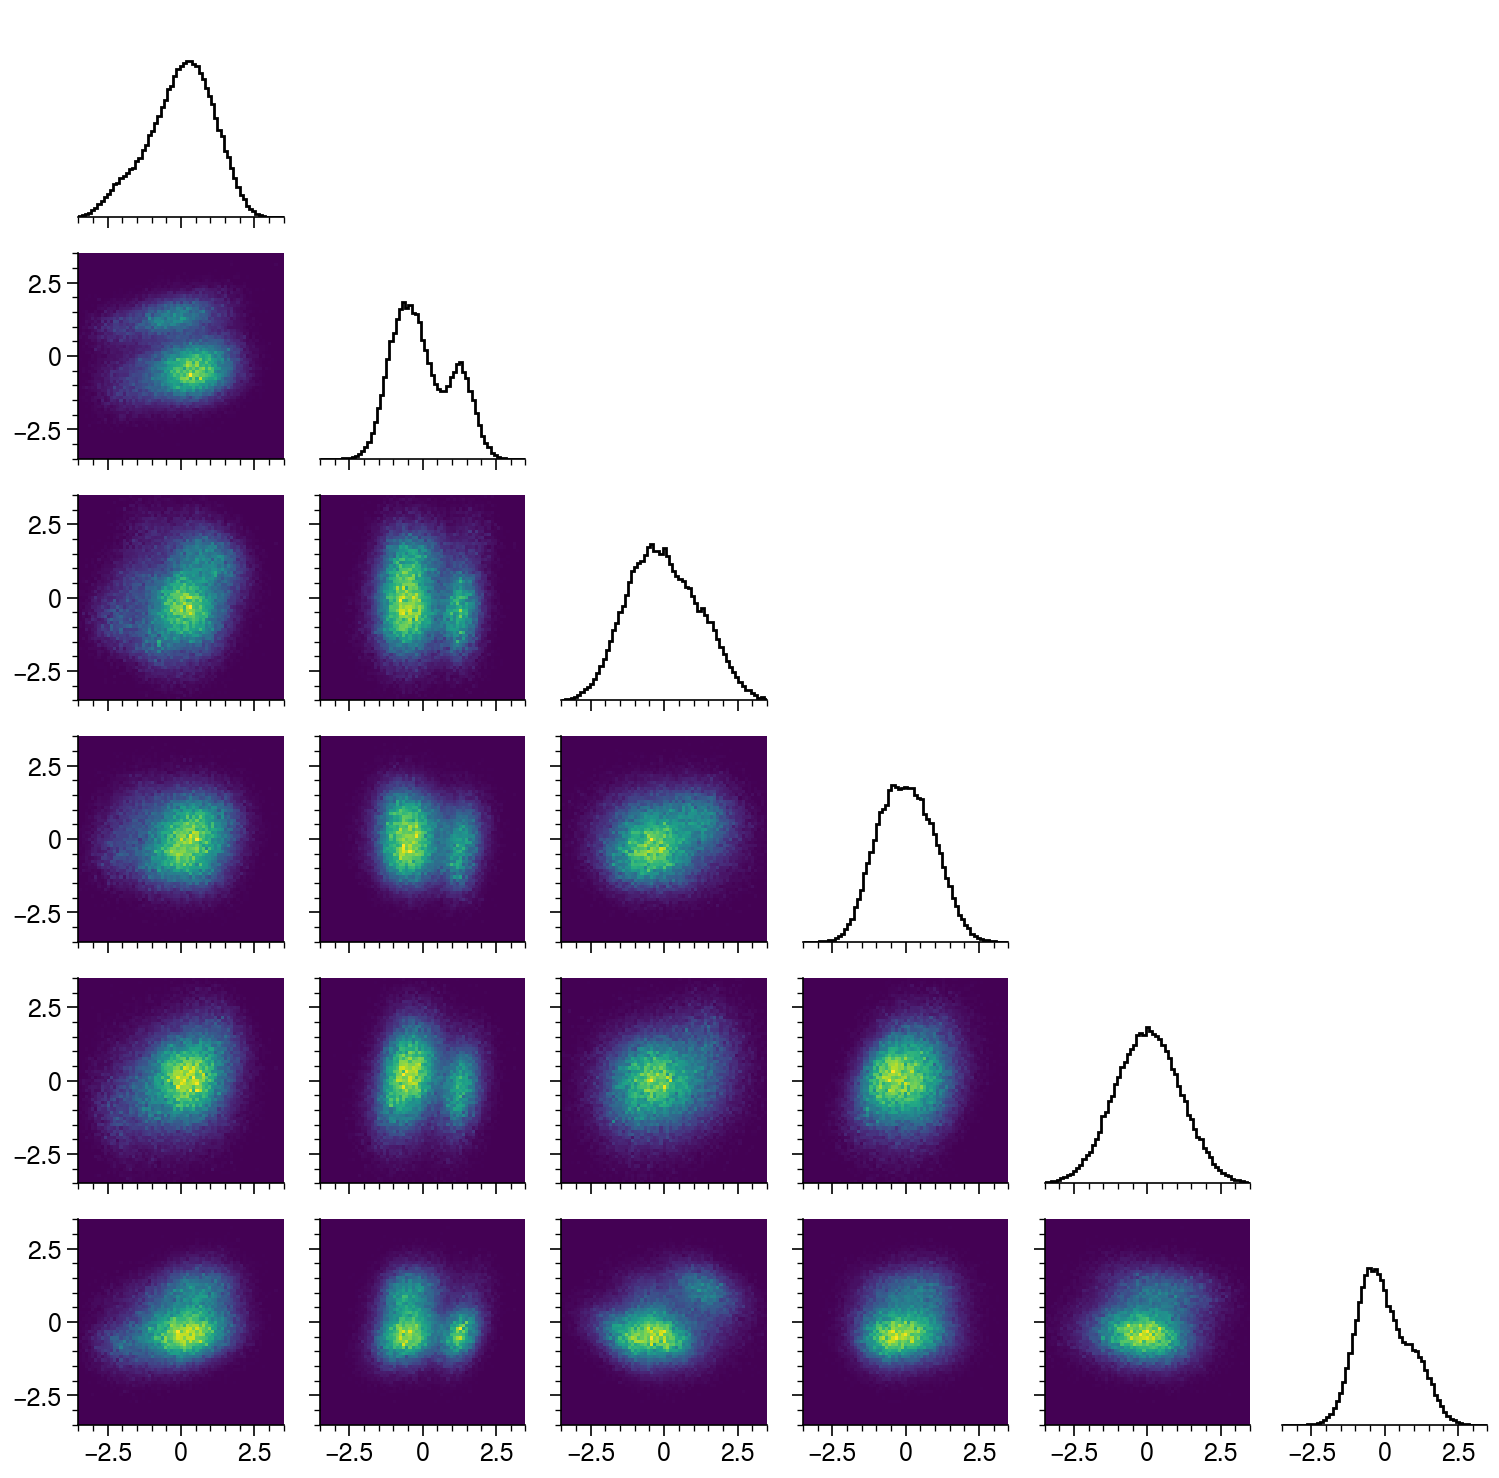

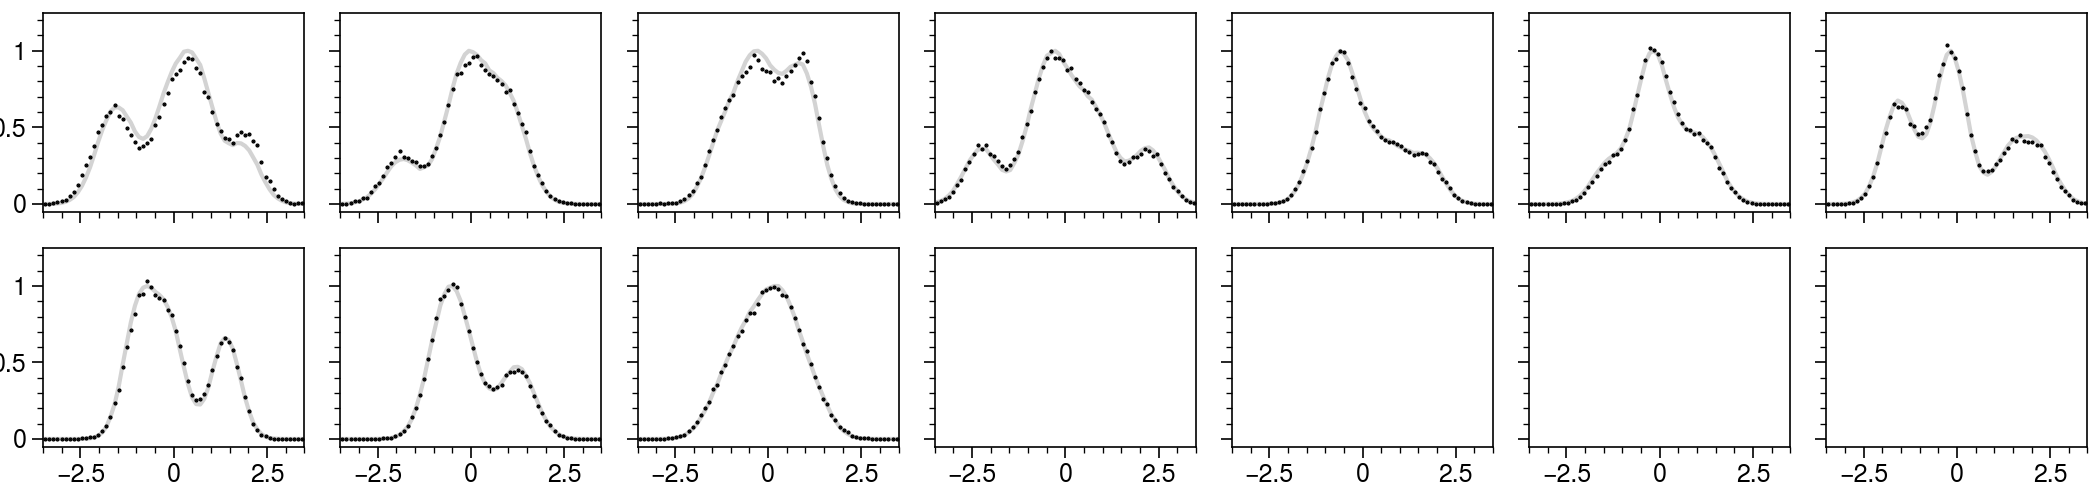

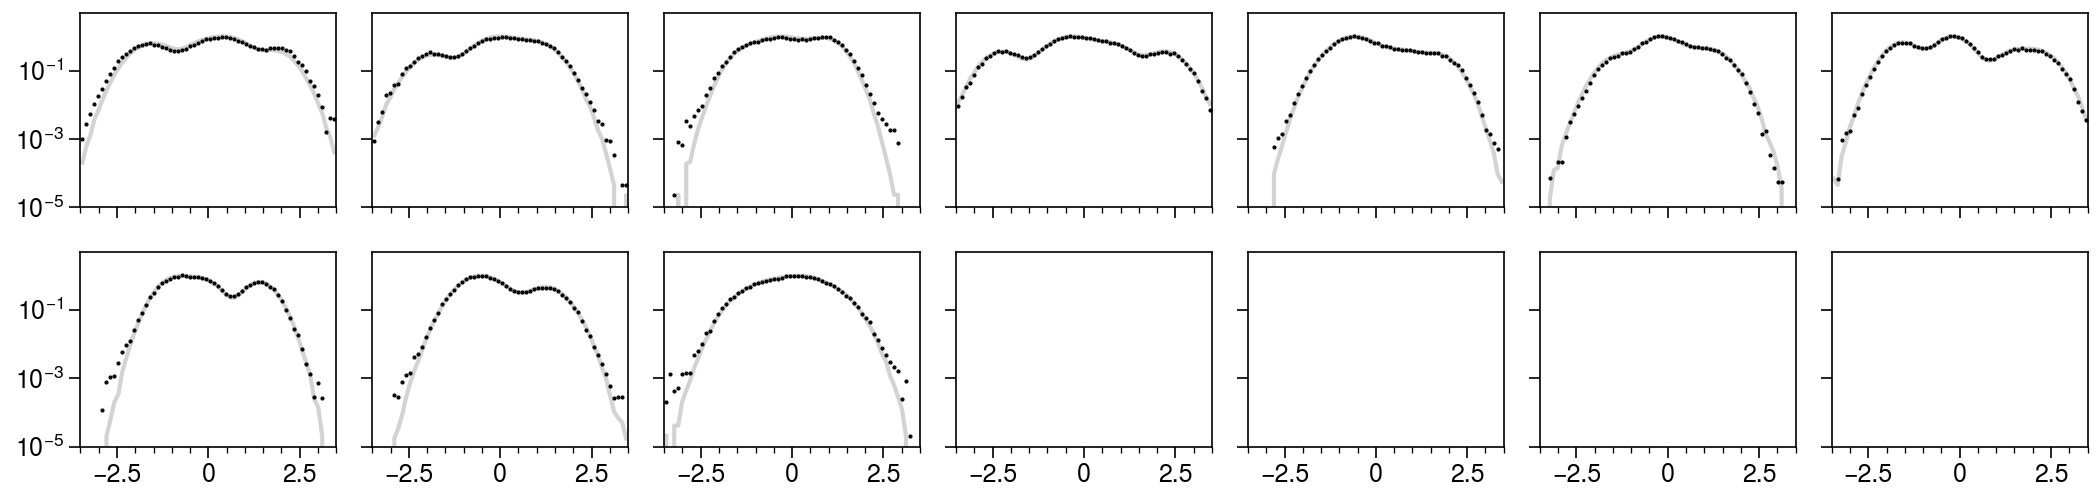

None
epoch = 3


  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  2%|██▉                                                                                                                                                            | 223/12015 [00:00<00:05, 2221.89it/s]

  4%|█████▉                                                                                                                                                         | 446/12015 [00:00<00:05, 2222.53it/s]

  6%|████████▉                                                                                                                                                      | 672/12015 [00:00<00:05, 2234.93it/s]

  7%|███████████▊                                                                                                                                                   | 896/12015 [00:00<00:05, 2220.66it/s]

  9%|██████████████▋                                                                                                                                               | 1120/12015 [00:00<00:04, 2224.92it/s]

 11%|█████████████████▋                                                                                                                                            | 1343/12015 [00:00<00:04, 2219.03it/s]

 13%|████████████████████▌                                                                                                                                         | 1568/12015 [00:00<00:04, 2228.48it/s]

 15%|███████████████████████▌                                                                                                                                      | 1793/12015 [00:00<00:04, 2232.79it/s]

 17%|██████████████████████████▌                                                                                                                                   | 2019/12015 [00:00<00:04, 2240.18it/s]

 19%|█████████████████████████████▌                                                                                                                                | 2244/12015 [00:01<00:04, 2233.00it/s]

 21%|████████████████████████████████▍                                                                                                                             | 2468/12015 [00:01<00:04, 2224.54it/s]

 22%|███████████████████████████████████▍                                                                                                                          | 2691/12015 [00:01<00:04, 2225.53it/s]

 24%|██████████████████████████████████████▎                                                                                                                       | 2914/12015 [00:01<00:04, 2226.84it/s]

 26%|█████████████████████████████████████████▎                                                                                                                    | 3140/12015 [00:01<00:03, 2234.88it/s]

 28%|████████████████████████████████████████████▎                                                                                                                 | 3366/12015 [00:01<00:03, 2240.30it/s]

 30%|███████████████████████████████████████████████▎                                                                                                              | 3594/12015 [00:01<00:03, 2249.35it/s]

 32%|██████████████████████████████████████████████████▏                                                                                                           | 3819/12015 [00:01<00:03, 2248.16it/s]

 34%|█████████████████████████████████████████████████████▍                                                                                                        | 4061/12015 [00:01<00:03, 2299.44it/s]

 36%|████████████████████████████████████████████████████████▌                                                                                                     | 4303/12015 [00:01<00:03, 2334.57it/s]

 38%|███████████████████████████████████████████████████████████▋                                                                                                  | 4540/12015 [00:02<00:03, 2343.11it/s]

 40%|██████████████████████████████████████████████████████████████▉                                                                                               | 4783/12015 [00:02<00:03, 2367.66it/s]

 42%|██████████████████████████████████████████████████████████████████                                                                                            | 5020/12015 [00:02<00:02, 2366.04it/s]

 44%|█████████████████████████████████████████████████████████████████████▍                                                                                        | 5277/12015 [00:02<00:02, 2425.92it/s]

 46%|████████████████████████████████████████████████████████████████████████▋                                                                                     | 5532/12015 [00:02<00:02, 2461.40it/s]

 48%|████████████████████████████████████████████████████████████████████████████▏                                                                                 | 5794/12015 [00:02<00:02, 2506.34it/s]

 50%|███████████████████████████████████████████████████████████████████████████████▌                                                                              | 6054/12015 [00:02<00:02, 2533.60it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████                                                                           | 6315/12015 [00:02<00:02, 2555.98it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 6575/12015 [00:02<00:02, 2567.85it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 6836/12015 [00:02<00:02, 2580.02it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 7097/12015 [00:03<00:01, 2586.81it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 7356/12015 [00:03<00:01, 2586.04it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 7617/12015 [00:03<00:01, 2593.10it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 7880/12015 [00:03<00:01, 2602.71it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 8141/12015 [00:03<00:01, 2603.94it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 8404/12015 [00:03<00:01, 2608.91it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 8667/12015 [00:03<00:01, 2614.31it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 8929/12015 [00:03<00:01, 2615.75it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 9191/12015 [00:03<00:01, 2606.47it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 9452/12015 [00:03<00:00, 2607.40it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 9715/12015 [00:04<00:00, 2613.05it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 9978/12015 [00:04<00:00, 2616.11it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 10243/12015 [00:04<00:00, 2623.63it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 10506/12015 [00:04<00:00, 2624.63it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 10769/12015 [00:04<00:00, 2619.38it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 11031/12015 [00:04<00:00, 2613.98it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 11295/12015 [00:04<00:00, 2619.96it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 11559/12015 [00:04<00:00, 2624.95it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 11824/12015 [00:04<00:00, 2629.57it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2457.00it/s]

  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  2%|███▍                                                                                                                                                           | 263/12015 [00:00<00:04, 2624.04it/s]

  4%|██████▉                                                                                                                                                        | 527/12015 [00:00<00:04, 2632.37it/s]

  7%|██████████▍                                                                                                                                                    | 792/12015 [00:00<00:04, 2639.15it/s]

  9%|█████████████▉                                                                                                                                                | 1058/12015 [00:00<00:04, 2643.55it/s]

 11%|█████████████████▍                                                                                                                                            | 1323/12015 [00:00<00:04, 2644.40it/s]

 13%|████████████████████▉                                                                                                                                         | 1589/12015 [00:00<00:03, 2646.50it/s]

 15%|████████████████████████▍                                                                                                                                     | 1855/12015 [00:00<00:03, 2648.47it/s]

 18%|███████████████████████████▉                                                                                                                                  | 2121/12015 [00:00<00:03, 2649.62it/s]

 20%|███████████████████████████████▍                                                                                                                              | 2386/12015 [00:00<00:03, 2646.42it/s]

 22%|██████████████████████████████████▊                                                                                                                           | 2651/12015 [00:01<00:03, 2645.32it/s]

 24%|██████████████████████████████████████▎                                                                                                                       | 2916/12015 [00:01<00:03, 2646.43it/s]

 26%|█████████████████████████████████████████▊                                                                                                                    | 3182/12015 [00:01<00:03, 2648.29it/s]

 29%|█████████████████████████████████████████████▎                                                                                                                | 3448/12015 [00:01<00:03, 2650.20it/s]

 31%|████████████████████████████████████████████████▊                                                                                                             | 3714/12015 [00:01<00:03, 2641.01it/s]

 33%|████████████████████████████████████████████████████▎                                                                                                         | 3980/12015 [00:01<00:03, 2643.88it/s]

 35%|███████████████████████████████████████████████████████▊                                                                                                      | 4245/12015 [00:01<00:02, 2644.02it/s]

 38%|███████████████████████████████████████████████████████████▎                                                                                                  | 4510/12015 [00:01<00:02, 2645.45it/s]

 40%|██████████████████████████████████████████████████████████████▊                                                                                               | 4776/12015 [00:01<00:02, 2647.31it/s]

 42%|██████████████████████████████████████████████████████████████████▎                                                                                           | 5041/12015 [00:01<00:02, 2646.05it/s]

 44%|█████████████████████████████████████████████████████████████████████▊                                                                                        | 5307/12015 [00:02<00:02, 2647.62it/s]

 46%|█████████████████████████████████████████████████████████████████████████▎                                                                                    | 5572/12015 [00:02<00:02, 2647.41it/s]

 49%|████████████████████████████████████████████████████████████████████████████▊                                                                                 | 5837/12015 [00:02<00:02, 2646.35it/s]

 51%|████████████████████████████████████████████████████████████████████████████████▏                                                                             | 6102/12015 [00:02<00:02, 2646.77it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████▋                                                                          | 6367/12015 [00:02<00:02, 2646.99it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 6632/12015 [00:02<00:02, 2645.42it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 6898/12015 [00:02<00:01, 2648.16it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 7163/12015 [00:02<00:01, 2646.35it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 7428/12015 [00:02<00:01, 2646.64it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 7693/12015 [00:02<00:01, 2646.14it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 7958/12015 [00:03<00:01, 2645.57it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 8223/12015 [00:03<00:01, 2645.81it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 8488/12015 [00:03<00:01, 2645.94it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 8753/12015 [00:03<00:01, 2645.76it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 9018/12015 [00:03<00:01, 2644.66it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 9283/12015 [00:03<00:01, 2608.36it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 9544/12015 [00:03<00:00, 2595.14it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 9808/12015 [00:03<00:00, 2606.50it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 10073/12015 [00:03<00:00, 2617.87it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 10337/12015 [00:03<00:00, 2621.77it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 10600/12015 [00:04<00:00, 2598.46it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 10864/12015 [00:04<00:00, 2608.04it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 11128/12015 [00:04<00:00, 2615.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 11392/12015 [00:04<00:00, 2621.85it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 11657/12015 [00:04<00:00, 2628.55it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 11922/12015 [00:04<00:00, 2634.33it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2637.08it/s]

  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  2%|███▍                                                                                                                                                           | 263/12015 [00:00<00:04, 2626.43it/s]

  4%|██████▉                                                                                                                                                        | 528/12015 [00:00<00:04, 2638.74it/s]

  7%|██████████▍                                                                                                                                                    | 793/12015 [00:00<00:04, 2640.87it/s]

  9%|█████████████▉                                                                                                                                                | 1058/12015 [00:00<00:04, 2640.33it/s]

 11%|█████████████████▍                                                                                                                                            | 1323/12015 [00:00<00:04, 2642.87it/s]

 13%|████████████████████▉                                                                                                                                         | 1588/12015 [00:00<00:03, 2641.61it/s]

 15%|████████████████████████▎                                                                                                                                     | 1853/12015 [00:00<00:03, 2641.13it/s]

 18%|███████████████████████████▊                                                                                                                                  | 2118/12015 [00:00<00:03, 2637.46it/s]

 20%|███████████████████████████████▎                                                                                                                              | 2384/12015 [00:00<00:03, 2643.27it/s]

 22%|██████████████████████████████████▊                                                                                                                           | 2649/12015 [00:01<00:03, 2639.61it/s]

 24%|██████████████████████████████████████▎                                                                                                                       | 2914/12015 [00:01<00:03, 2640.23it/s]

 26%|█████████████████████████████████████████▊                                                                                                                    | 3179/12015 [00:01<00:03, 2635.15it/s]

 29%|█████████████████████████████████████████████▎                                                                                                                | 3444/12015 [00:01<00:03, 2639.21it/s]

 31%|████████████████████████████████████████████████▊                                                                                                             | 3708/12015 [00:01<00:03, 2635.76it/s]

 33%|████████████████████████████████████████████████████▏                                                                                                         | 3972/12015 [00:01<00:03, 2634.35it/s]

 35%|███████████████████████████████████████████████████████▋                                                                                                      | 4237/12015 [00:01<00:02, 2636.50it/s]

 37%|███████████████████████████████████████████████████████████▏                                                                                                  | 4501/12015 [00:01<00:02, 2634.88it/s]

 40%|██████████████████████████████████████████████████████████████▋                                                                                               | 4765/12015 [00:01<00:02, 2635.10it/s]

 42%|██████████████████████████████████████████████████████████████████▏                                                                                           | 5029/12015 [00:01<00:02, 2631.54it/s]

 44%|█████████████████████████████████████████████████████████████████████▌                                                                                        | 5293/12015 [00:02<00:02, 2631.02it/s]

 46%|█████████████████████████████████████████████████████████████████████████                                                                                     | 5557/12015 [00:02<00:02, 2628.57it/s]

 48%|████████████████████████████████████████████████████████████████████████████▌                                                                                 | 5820/12015 [00:02<00:02, 2625.79it/s]

 51%|███████████████████████████████████████████████████████████████████████████████▉                                                                              | 6083/12015 [00:02<00:02, 2626.45it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████▍                                                                          | 6347/12015 [00:02<00:02, 2629.09it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 6610/12015 [00:02<00:02, 2628.90it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 6875/12015 [00:02<00:01, 2632.43it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 7139/12015 [00:02<00:01, 2631.94it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 7403/12015 [00:02<00:01, 2631.82it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 7667/12015 [00:02<00:01, 2634.06it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 7932/12015 [00:03<00:01, 2637.47it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 8197/12015 [00:03<00:01, 2639.67it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 8461/12015 [00:03<00:01, 2639.37it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 8726/12015 [00:03<00:01, 2641.10it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 8991/12015 [00:03<00:01, 2637.17it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 9255/12015 [00:03<00:01, 2635.59it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 9519/12015 [00:03<00:00, 2633.80it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 9785/12015 [00:03<00:00, 2638.73it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 10049/12015 [00:03<00:00, 2637.30it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 10315/12015 [00:03<00:00, 2641.77it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 10580/12015 [00:04<00:00, 2638.00it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 10845/12015 [00:04<00:00, 2639.51it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 11109/12015 [00:04<00:00, 2639.31it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 11373/12015 [00:04<00:00, 2637.58it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 11637/12015 [00:04<00:00, 2637.06it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 11901/12015 [00:04<00:00, 2636.33it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2635.89it/s]

  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  2%|███▎                                                                                                                                                           | 252/12015 [00:00<00:04, 2510.36it/s]

  4%|██████▋                                                                                                                                                        | 506/12015 [00:00<00:04, 2524.98it/s]

  6%|██████████                                                                                                                                                     | 760/12015 [00:00<00:04, 2527.32it/s]

  8%|█████████████▎                                                                                                                                                | 1015/12015 [00:00<00:04, 2532.40it/s]

 11%|████████████████▋                                                                                                                                             | 1269/12015 [00:00<00:04, 2527.48it/s]

 13%|████████████████████                                                                                                                                          | 1522/12015 [00:00<00:04, 2502.91it/s]

 15%|███████████████████████▎                                                                                                                                      | 1773/12015 [00:00<00:04, 2499.15it/s]

 17%|██████████████████████████▋                                                                                                                                   | 2025/12015 [00:00<00:03, 2503.03it/s]

 19%|█████████████████████████████▉                                                                                                                                | 2279/12015 [00:00<00:03, 2511.68it/s]

 21%|█████████████████████████████████▎                                                                                                                            | 2532/12015 [00:01<00:03, 2516.09it/s]

 23%|████████████████████████████████████▋                                                                                                                         | 2786/12015 [00:01<00:03, 2522.75it/s]

 25%|███████████████████████████████████████▉                                                                                                                      | 3039/12015 [00:01<00:03, 2523.55it/s]

 27%|███████████████████████████████████████████▎                                                                                                                  | 3292/12015 [00:01<00:03, 2519.56it/s]

 29%|██████████████████████████████████████████████▌                                                                                                               | 3544/12015 [00:01<00:03, 2483.71it/s]

 32%|█████████████████████████████████████████████████▉                                                                                                            | 3793/12015 [00:01<00:03, 2485.47it/s]

 34%|█████████████████████████████████████████████████████▏                                                                                                        | 4046/12015 [00:01<00:03, 2495.91it/s]

 36%|████████████████████████████████████████████████████████▌                                                                                                     | 4299/12015 [00:01<00:03, 2505.88it/s]

 38%|███████████████████████████████████████████████████████████▊                                                                                                  | 4550/12015 [00:01<00:02, 2502.39it/s]

 40%|███████████████████████████████████████████████████████████████▏                                                                                              | 4801/12015 [00:01<00:02, 2490.69it/s]

 42%|██████████████████████████████████████████████████████████████████▍                                                                                           | 5051/12015 [00:02<00:02, 2486.21it/s]

 44%|█████████████████████████████████████████████████████████████████████▋                                                                                        | 5300/12015 [00:02<00:02, 2483.90it/s]

 46%|████████████████████████████████████████████████████████████████████████▉                                                                                     | 5551/12015 [00:02<00:02, 2489.31it/s]

 48%|████████████████████████████████████████████████████████████████████████████▎                                                                                 | 5800/12015 [00:02<00:02, 2486.91it/s]

 50%|███████████████████████████████████████████████████████████████████████████████▌                                                                              | 6050/12015 [00:02<00:02, 2490.14it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████▉                                                                           | 6303/12015 [00:02<00:02, 2500.70it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 6556/12015 [00:02<00:02, 2507.01it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 6809/12015 [00:02<00:02, 2513.25it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 7061/12015 [00:02<00:01, 2508.96it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 7312/12015 [00:02<00:01, 2501.71it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 7563/12015 [00:03<00:01, 2496.80it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 7814/12015 [00:03<00:01, 2498.66it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 8064/12015 [00:03<00:01, 2496.93it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 8314/12015 [00:03<00:01, 2496.29it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 8564/12015 [00:03<00:01, 2491.88it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 8814/12015 [00:03<00:01, 2494.22it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 9065/12015 [00:03<00:01, 2496.32it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 9316/12015 [00:03<00:01, 2497.43it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 9568/12015 [00:03<00:00, 2503.08it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 9819/12015 [00:03<00:00, 2501.25it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 10070/12015 [00:04<00:00, 2496.67it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 10320/12015 [00:04<00:00, 2495.70it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 10572/12015 [00:04<00:00, 2501.82it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 10823/12015 [00:04<00:00, 2497.98it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 11073/12015 [00:04<00:00, 2495.48it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 11324/12015 [00:04<00:00, 2499.77it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 11576/12015 [00:04<00:00, 2504.58it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 11827/12015 [00:04<00:00, 2502.09it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2501.71it/s]

  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  2%|███▎                                                                                                                                                           | 253/12015 [00:00<00:04, 2526.21it/s]

  4%|██████▋                                                                                                                                                        | 507/12015 [00:00<00:04, 2531.15it/s]

  6%|██████████                                                                                                                                                     | 761/12015 [00:00<00:04, 2533.12it/s]

  8%|█████████████▎                                                                                                                                                | 1015/12015 [00:00<00:04, 2531.57it/s]

 11%|████████████████▋                                                                                                                                             | 1269/12015 [00:00<00:04, 2528.66it/s]

 13%|████████████████████                                                                                                                                          | 1522/12015 [00:00<00:04, 2524.75it/s]

 15%|███████████████████████▎                                                                                                                                      | 1776/12015 [00:00<00:04, 2528.09it/s]

 17%|██████████████████████████▋                                                                                                                                   | 2030/12015 [00:00<00:03, 2529.19it/s]

 19%|██████████████████████████████                                                                                                                                | 2284/12015 [00:00<00:03, 2532.10it/s]

 21%|█████████████████████████████████▍                                                                                                                            | 2538/12015 [00:01<00:03, 2531.25it/s]

 23%|████████████████████████████████████▋                                                                                                                         | 2792/12015 [00:01<00:03, 2530.47it/s]

 25%|████████████████████████████████████████                                                                                                                      | 3046/12015 [00:01<00:03, 2528.62it/s]

 27%|███████████████████████████████████████████▍                                                                                                                  | 3300/12015 [00:01<00:03, 2531.11it/s]

 30%|██████████████████████████████████████████████▋                                                                                                               | 3554/12015 [00:01<00:03, 2531.84it/s]

 32%|██████████████████████████████████████████████████                                                                                                            | 3808/12015 [00:01<00:03, 2527.99it/s]

 34%|█████████████████████████████████████████████████████▍                                                                                                        | 4061/12015 [00:01<00:03, 2524.87it/s]

 36%|████████████████████████████████████████████████████████▋                                                                                                     | 4314/12015 [00:01<00:03, 2526.07it/s]

 38%|████████████████████████████████████████████████████████████                                                                                                  | 4567/12015 [00:01<00:02, 2526.95it/s]

 40%|███████████████████████████████████████████████████████████████▍                                                                                              | 4820/12015 [00:01<00:02, 2526.44it/s]

 42%|██████████████████████████████████████████████████████████████████▋                                                                                           | 5074/12015 [00:02<00:02, 2527.73it/s]

 44%|██████████████████████████████████████████████████████████████████████                                                                                        | 5328/12015 [00:02<00:02, 2528.53it/s]

 46%|█████████████████████████████████████████████████████████████████████████▍                                                                                    | 5582/12015 [00:02<00:02, 2529.08it/s]

 49%|████████████████████████████████████████████████████████████████████████████▋                                                                                 | 5836/12015 [00:02<00:02, 2529.80it/s]

 51%|████████████████████████████████████████████████████████████████████████████████                                                                              | 6090/12015 [00:02<00:02, 2530.18it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████▍                                                                          | 6344/12015 [00:02<00:02, 2531.48it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 6598/12015 [00:02<00:02, 2532.74it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████                                                                    | 6852/12015 [00:02<00:02, 2532.31it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 7106/12015 [00:02<00:01, 2529.52it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 7360/12015 [00:02<00:01, 2530.49it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 7614/12015 [00:03<00:01, 2531.99it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 7868/12015 [00:03<00:01, 2532.66it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 8122/12015 [00:03<00:01, 2532.96it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 8376/12015 [00:03<00:01, 2534.52it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 8630/12015 [00:03<00:01, 2507.54it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 8881/12015 [00:03<00:01, 2480.60it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 9130/12015 [00:03<00:01, 2472.20it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 9378/12015 [00:03<00:01, 2464.16it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 9630/12015 [00:03<00:00, 2478.94it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 9883/12015 [00:03<00:00, 2491.72it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 10134/12015 [00:04<00:00, 2494.84it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 10388/12015 [00:04<00:00, 2505.79it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 10642/12015 [00:04<00:00, 2513.80it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 10896/12015 [00:04<00:00, 2520.89it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 11149/12015 [00:04<00:00, 2522.20it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 11404/12015 [00:04<00:00, 2528.25it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 11659/12015 [00:04<00:00, 2531.74it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 11913/12015 [00:04<00:00, 2531.94it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2521.92it/s]

  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  2%|███▎                                                                                                                                                           | 251/12015 [00:00<00:04, 2506.29it/s]

  4%|██████▋                                                                                                                                                        | 503/12015 [00:00<00:04, 2513.30it/s]

  6%|█████████▉                                                                                                                                                     | 755/12015 [00:00<00:04, 2508.05it/s]

  8%|█████████████▏                                                                                                                                                | 1007/12015 [00:00<00:04, 2512.70it/s]

 10%|████████████████▌                                                                                                                                             | 1259/12015 [00:00<00:04, 2514.95it/s]

 13%|███████████████████▊                                                                                                                                          | 1511/12015 [00:00<00:04, 2513.99it/s]

 15%|███████████████████████▏                                                                                                                                      | 1763/12015 [00:00<00:04, 2512.90it/s]

 17%|██████████████████████████▌                                                                                                                                   | 2017/12015 [00:00<00:03, 2519.49it/s]

 19%|█████████████████████████████▊                                                                                                                                | 2269/12015 [00:00<00:03, 2517.94it/s]

 21%|█████████████████████████████████▏                                                                                                                            | 2521/12015 [00:01<00:03, 2516.08it/s]

 23%|████████████████████████████████████▍                                                                                                                         | 2773/12015 [00:01<00:03, 2501.29it/s]

 25%|███████████████████████████████████████▊                                                                                                                      | 3024/12015 [00:01<00:03, 2496.76it/s]

 27%|███████████████████████████████████████████                                                                                                                   | 3276/12015 [00:01<00:03, 2501.26it/s]

 29%|██████████████████████████████████████████████▍                                                                                                               | 3527/12015 [00:01<00:03, 2500.54it/s]

 31%|█████████████████████████████████████████████████▋                                                                                                            | 3780/12015 [00:01<00:03, 2508.99it/s]

 34%|█████████████████████████████████████████████████████                                                                                                         | 4034/12015 [00:01<00:03, 2515.43it/s]

 36%|████████████████████████████████████████████████████████▎                                                                                                     | 4286/12015 [00:01<00:03, 2509.42it/s]

 38%|███████████████████████████████████████████████████████████▋                                                                                                  | 4537/12015 [00:01<00:02, 2503.00it/s]

 40%|██████████████████████████████████████████████████████████████▉                                                                                               | 4788/12015 [00:01<00:02, 2494.97it/s]

 42%|██████████████████████████████████████████████████████████████████▎                                                                                           | 5038/12015 [00:02<00:02, 2493.72it/s]

 44%|█████████████████████████████████████████████████████████████████████▌                                                                                        | 5289/12015 [00:02<00:02, 2497.92it/s]

 46%|████████████████████████████████████████████████████████████████████████▊                                                                                     | 5539/12015 [00:02<00:02, 2497.31it/s]

 48%|████████████████████████████████████████████████████████████████████████████▏                                                                                 | 5790/12015 [00:02<00:02, 2498.27it/s]

 50%|███████████████████████████████████████████████████████████████████████████████▍                                                                              | 6040/12015 [00:02<00:02, 2494.47it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████▋                                                                           | 6290/12015 [00:02<00:02, 2488.54it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 6539/12015 [00:02<00:02, 2484.22it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 6791/12015 [00:02<00:02, 2493.52it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 7044/12015 [00:02<00:01, 2502.14it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 7297/12015 [00:02<00:01, 2508.31it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 7550/12015 [00:03<00:01, 2512.08it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 7803/12015 [00:03<00:01, 2516.86it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 8056/12015 [00:03<00:01, 2518.89it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 8309/12015 [00:03<00:01, 2520.20it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 8562/12015 [00:03<00:01, 2520.10it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 8815/12015 [00:03<00:01, 2515.07it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 9068/12015 [00:03<00:01, 2516.77it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 9321/12015 [00:03<00:01, 2519.62it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 9574/12015 [00:03<00:00, 2521.36it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 9827/12015 [00:03<00:00, 2519.43it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 10080/12015 [00:04<00:00, 2521.62it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 10333/12015 [00:04<00:00, 2522.72it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 10586/12015 [00:04<00:00, 2523.20it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 10839/12015 [00:04<00:00, 2522.14it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 11092/12015 [00:04<00:00, 2523.42it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 11345/12015 [00:04<00:00, 2523.80it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 11598/12015 [00:04<00:00, 2524.12it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 11851/12015 [00:04<00:00, 2521.72it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2511.02it/s]

  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  2%|███▎                                                                                                                                                           | 254/12015 [00:00<00:04, 2532.28it/s]

  4%|██████▋                                                                                                                                                        | 508/12015 [00:00<00:04, 2526.77it/s]

  6%|██████████                                                                                                                                                     | 762/12015 [00:00<00:04, 2528.34it/s]

  8%|█████████████▎                                                                                                                                                | 1015/12015 [00:00<00:04, 2525.01it/s]

 11%|████████████████▋                                                                                                                                             | 1268/12015 [00:00<00:04, 2521.93it/s]

 13%|████████████████████                                                                                                                                          | 1521/12015 [00:00<00:04, 2523.27it/s]

 15%|███████████████████████▎                                                                                                                                      | 1774/12015 [00:00<00:04, 2524.38it/s]

 17%|██████████████████████████▋                                                                                                                                   | 2027/12015 [00:00<00:03, 2525.23it/s]

 19%|█████████████████████████████▉                                                                                                                                | 2280/12015 [00:00<00:03, 2521.29it/s]

 21%|█████████████████████████████████▎                                                                                                                            | 2533/12015 [00:01<00:03, 2521.45it/s]

 23%|████████████████████████████████████▋                                                                                                                         | 2786/12015 [00:01<00:03, 2521.57it/s]

 25%|███████████████████████████████████████▉                                                                                                                      | 3040/12015 [00:01<00:03, 2524.60it/s]

 27%|███████████████████████████████████████████▎                                                                                                                  | 3293/12015 [00:01<00:03, 2522.64it/s]

 30%|██████████████████████████████████████████████▋                                                                                                               | 3547/12015 [00:01<00:03, 2524.91it/s]

 32%|█████████████████████████████████████████████████▉                                                                                                            | 3800/12015 [00:01<00:03, 2518.81it/s]

 34%|█████████████████████████████████████████████████████▎                                                                                                        | 4054/12015 [00:01<00:03, 2522.76it/s]

 36%|████████████████████████████████████████████████████████▋                                                                                                     | 4307/12015 [00:01<00:03, 2519.65it/s]

 38%|███████████████████████████████████████████████████████████▉                                                                                                  | 4559/12015 [00:01<00:02, 2518.50it/s]

 40%|███████████████████████████████████████████████████████████████▎                                                                                              | 4811/12015 [00:01<00:02, 2517.87it/s]

 42%|██████████████████████████████████████████████████████████████████▌                                                                                           | 5065/12015 [00:02<00:02, 2522.75it/s]

 44%|█████████████████████████████████████████████████████████████████████▉                                                                                        | 5318/12015 [00:02<00:02, 2520.77it/s]

 46%|█████████████████████████████████████████████████████████████████████████▎                                                                                    | 5572/12015 [00:02<00:02, 2523.97it/s]

 48%|████████████████████████████████████████████████████████████████████████████▌                                                                                 | 5825/12015 [00:02<00:02, 2522.00it/s]

 51%|███████████████████████████████████████████████████████████████████████████████▉                                                                              | 6078/12015 [00:02<00:02, 2517.16it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████▎                                                                          | 6332/12015 [00:02<00:02, 2523.00it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 6585/12015 [00:02<00:02, 2524.43it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 6838/12015 [00:02<00:02, 2525.21it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 7092/12015 [00:02<00:01, 2527.30it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 7346/12015 [00:02<00:01, 2528.37it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 7599/12015 [00:03<00:01, 2524.19it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 7852/12015 [00:03<00:01, 2521.66it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 8105/12015 [00:03<00:01, 2520.99it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 8358/12015 [00:03<00:01, 2519.23it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 8610/12015 [00:03<00:01, 2517.59it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 8864/12015 [00:03<00:01, 2523.20it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 9118/12015 [00:03<00:01, 2526.91it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 9371/12015 [00:03<00:01, 2524.41it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 9625/12015 [00:03<00:00, 2527.76it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 9878/12015 [00:03<00:00, 2524.90it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 10131/12015 [00:04<00:00, 2525.70it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 10384/12015 [00:04<00:00, 2524.00it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 10637/12015 [00:04<00:00, 2524.24it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 10891/12015 [00:04<00:00, 2527.38it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 11145/12015 [00:04<00:00, 2529.12it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 11398/12015 [00:04<00:00, 2529.04it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 11651/12015 [00:04<00:00, 2519.58it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 11903/12015 [00:04<00:00, 2494.65it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2520.24it/s]

  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  2%|███▎                                                                                                                                                           | 246/12015 [00:00<00:04, 2451.96it/s]

  4%|██████▌                                                                                                                                                        | 495/12015 [00:00<00:04, 2473.74it/s]

  6%|█████████▉                                                                                                                                                     | 747/12015 [00:00<00:04, 2493.77it/s]

  8%|█████████████▏                                                                                                                                                 | 997/12015 [00:00<00:04, 2488.69it/s]

 10%|████████████████▍                                                                                                                                             | 1246/12015 [00:00<00:04, 2484.25it/s]

 12%|███████████████████▋                                                                                                                                          | 1495/12015 [00:00<00:04, 2485.30it/s]

 15%|██████████████████████▉                                                                                                                                       | 1746/12015 [00:00<00:04, 2493.17it/s]

 17%|██████████████████████████▎                                                                                                                                   | 2000/12015 [00:00<00:03, 2505.32it/s]

 19%|█████████████████████████████▌                                                                                                                                | 2251/12015 [00:00<00:03, 2497.18it/s]

 21%|████████████████████████████████▉                                                                                                                             | 2501/12015 [00:01<00:03, 2489.91it/s]

 23%|████████████████████████████████████▏                                                                                                                         | 2751/12015 [00:01<00:03, 2492.55it/s]

 25%|███████████████████████████████████████▌                                                                                                                      | 3005/12015 [00:01<00:03, 2504.15it/s]

 27%|██████████████████████████████████████████▊                                                                                                                   | 3256/12015 [00:01<00:03, 2495.78it/s]

 29%|██████████████████████████████████████████████                                                                                                                | 3506/12015 [00:01<00:03, 2492.03it/s]

 31%|█████████████████████████████████████████████████▍                                                                                                            | 3756/12015 [00:01<00:03, 2492.13it/s]

 33%|████████████████████████████████████████████████████▋                                                                                                         | 4008/12015 [00:01<00:03, 2497.79it/s]

 35%|████████████████████████████████████████████████████████                                                                                                      | 4259/12015 [00:01<00:03, 2498.82it/s]

 38%|███████████████████████████████████████████████████████████▎                                                                                                  | 4509/12015 [00:01<00:03, 2490.47it/s]

 40%|██████████████████████████████████████████████████████████████▌                                                                                               | 4759/12015 [00:01<00:02, 2475.44it/s]

 42%|█████████████████████████████████████████████████████████████████▊                                                                                            | 5007/12015 [00:02<00:02, 2476.28it/s]

 44%|█████████████████████████████████████████████████████████████████████▏                                                                                        | 5257/12015 [00:02<00:02, 2482.50it/s]

 46%|████████████████████████████████████████████████████████████████████████▍                                                                                     | 5506/12015 [00:02<00:02, 2476.18it/s]

 48%|███████████████████████████████████████████████████████████████████████████▋                                                                                  | 5756/12015 [00:02<00:02, 2480.99it/s]

 50%|██████████████████████████████████████████████████████████████████████████████▉                                                                               | 6005/12015 [00:02<00:02, 2477.87it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████▎                                                                           | 6257/12015 [00:02<00:02, 2488.80it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 6507/12015 [00:02<00:02, 2491.05it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 6758/12015 [00:02<00:02, 2496.60it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 7008/12015 [00:02<00:02, 2497.10it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 7258/12015 [00:02<00:01, 2494.83it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 7508/12015 [00:03<00:01, 2491.59it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 7758/12015 [00:03<00:01, 2493.43it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 8008/12015 [00:03<00:01, 2494.27it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 8260/12015 [00:03<00:01, 2500.34it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 8511/12015 [00:03<00:01, 2499.01it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 8761/12015 [00:03<00:01, 2493.26it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 9012/12015 [00:03<00:01, 2496.92it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 9264/12015 [00:03<00:01, 2503.71it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 9516/12015 [00:03<00:00, 2506.58it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 9769/12015 [00:03<00:00, 2512.88it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 10021/12015 [00:04<00:00, 2498.69it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 10271/12015 [00:04<00:00, 2485.69it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 10520/12015 [00:04<00:00, 2458.79it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 10766/12015 [00:04<00:00, 2457.00it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 11013/12015 [00:04<00:00, 2459.44it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 11264/12015 [00:04<00:00, 2472.03it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 11515/12015 [00:04<00:00, 2480.51it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 11766/12015 [00:04<00:00, 2488.65it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2489.32it/s]

  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  2%|███▎                                                                                                                                                           | 251/12015 [00:00<00:04, 2508.64it/s]

  4%|██████▋                                                                                                                                                        | 502/12015 [00:00<00:04, 2503.25it/s]

  6%|█████████▉                                                                                                                                                     | 753/12015 [00:00<00:04, 2496.38it/s]

  8%|█████████████▏                                                                                                                                                | 1003/12015 [00:00<00:04, 2485.49it/s]

 10%|████████████████▌                                                                                                                                             | 1257/12015 [00:00<00:04, 2500.94it/s]

 13%|███████████████████▊                                                                                                                                          | 1511/12015 [00:00<00:04, 2511.31it/s]

 15%|███████████████████████▏                                                                                                                                      | 1763/12015 [00:00<00:04, 2513.10it/s]

 17%|██████████████████████████▍                                                                                                                                   | 2015/12015 [00:00<00:03, 2506.77it/s]

 19%|█████████████████████████████▊                                                                                                                                | 2266/12015 [00:00<00:03, 2506.65it/s]

 21%|█████████████████████████████████                                                                                                                             | 2518/12015 [00:01<00:03, 2510.40it/s]

 23%|████████████████████████████████████▍                                                                                                                         | 2772/12015 [00:01<00:03, 2517.54it/s]

 25%|███████████████████████████████████████▊                                                                                                                      | 3026/12015 [00:01<00:03, 2522.45it/s]

 27%|███████████████████████████████████████████▏                                                                                                                  | 3280/12015 [00:01<00:03, 2525.81it/s]

 29%|██████████████████████████████████████████████▍                                                                                                               | 3534/12015 [00:01<00:03, 2527.42it/s]

 32%|█████████████████████████████████████████████████▊                                                                                                            | 3787/12015 [00:01<00:03, 2524.67it/s]

 34%|█████████████████████████████████████████████████████▏                                                                                                        | 4040/12015 [00:01<00:03, 2521.89it/s]

 36%|████████████████████████████████████████████████████████▍                                                                                                     | 4293/12015 [00:01<00:03, 2516.46it/s]

 38%|███████████████████████████████████████████████████████████▊                                                                                                  | 4545/12015 [00:01<00:02, 2499.57it/s]

 40%|███████████████████████████████████████████████████████████████                                                                                               | 4795/12015 [00:01<00:02, 2476.90it/s]

 42%|██████████████████████████████████████████████████████████████████▎                                                                                           | 5043/12015 [00:02<00:02, 2469.88it/s]

 44%|█████████████████████████████████████████████████████████████████████▌                                                                                        | 5291/12015 [00:02<00:02, 2470.41it/s]

 46%|████████████████████████████████████████████████████████████████████████▊                                                                                     | 5539/12015 [00:02<00:02, 2356.14it/s]

 48%|███████████████████████████████████████████████████████████████████████████▉                                                                                  | 5776/12015 [00:02<00:02, 2273.63it/s]

 50%|██████████████████████████████████████████████████████████████████████████████▉                                                                               | 6005/12015 [00:02<00:02, 2238.23it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████▉                                                                            | 6230/12015 [00:02<00:02, 2235.85it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 6455/12015 [00:02<00:02, 2185.54it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 6675/12015 [00:02<00:02, 2153.69it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 6897/12015 [00:02<00:02, 2172.50it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 7133/12015 [00:02<00:02, 2224.89it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 7374/12015 [00:03<00:02, 2277.74it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 7615/12015 [00:03<00:01, 2316.18it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 7859/12015 [00:03<00:01, 2350.61it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 8097/12015 [00:03<00:01, 2358.43it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 8334/12015 [00:03<00:01, 2305.39it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 8565/12015 [00:03<00:01, 2265.78it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 8792/12015 [00:03<00:01, 2222.46it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 9023/12015 [00:03<00:01, 2246.04it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 9248/12015 [00:03<00:01, 2244.73it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 9473/12015 [00:03<00:01, 2214.90it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 9695/12015 [00:04<00:01, 2177.95it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 9933/12015 [00:04<00:00, 2234.05it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 10158/12015 [00:04<00:00, 2237.89it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 10394/12015 [00:04<00:00, 2272.22it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 10643/12015 [00:04<00:00, 2335.30it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 10895/12015 [00:04<00:00, 2390.17it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 11148/12015 [00:04<00:00, 2429.97it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 11401/12015 [00:04<00:00, 2459.15it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 11654/12015 [00:04<00:00, 2479.71it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 11907/12015 [00:05<00:00, 2492.61it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:05<00:00, 2381.35it/s]

  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  2%|███▎                                                                                                                                                           | 252/12015 [00:00<00:04, 2512.29it/s]

  4%|██████▋                                                                                                                                                        | 504/12015 [00:00<00:04, 2480.95it/s]

  6%|█████████▉                                                                                                                                                     | 753/12015 [00:00<00:04, 2350.37it/s]

  8%|█████████████▏                                                                                                                                                | 1005/12015 [00:00<00:04, 2414.11it/s]

 10%|████████████████▍                                                                                                                                             | 1254/12015 [00:00<00:04, 2437.82it/s]

 13%|███████████████████▊                                                                                                                                          | 1505/12015 [00:00<00:04, 2461.64it/s]

 15%|███████████████████████                                                                                                                                       | 1757/12015 [00:00<00:04, 2479.23it/s]

 17%|██████████████████████████▍                                                                                                                                   | 2008/12015 [00:00<00:04, 2487.72it/s]

 19%|█████████████████████████████▋                                                                                                                                | 2261/12015 [00:00<00:03, 2497.92it/s]

 21%|█████████████████████████████████                                                                                                                             | 2514/12015 [00:01<00:03, 2506.87it/s]

 23%|████████████████████████████████████▎                                                                                                                         | 2765/12015 [00:01<00:03, 2500.95it/s]

 25%|███████████████████████████████████████▋                                                                                                                      | 3017/12015 [00:01<00:03, 2506.22it/s]

 27%|██████████████████████████████████████████▉                                                                                                                   | 3268/12015 [00:01<00:03, 2505.37it/s]

 29%|██████████████████████████████████████████████▎                                                                                                               | 3520/12015 [00:01<00:03, 2507.48it/s]

 31%|█████████████████████████████████████████████████▌                                                                                                            | 3771/12015 [00:01<00:03, 2504.46it/s]

 33%|████████████████████████████████████████████████████▉                                                                                                         | 4025/12015 [00:01<00:03, 2514.58it/s]

 36%|████████████████████████████████████████████████████████▎                                                                                                     | 4286/12015 [00:01<00:03, 2541.82it/s]

 38%|███████████████████████████████████████████████████████████▊                                                                                                  | 4547/12015 [00:01<00:02, 2560.01it/s]

 40%|███████████████████████████████████████████████████████████████▏                                                                                              | 4807/12015 [00:01<00:02, 2570.72it/s]

 42%|██████████████████████████████████████████████████████████████████▋                                                                                           | 5071/12015 [00:02<00:02, 2588.59it/s]

 44%|██████████████████████████████████████████████████████████████████████▏                                                                                       | 5334/12015 [00:02<00:02, 2599.32it/s]

 47%|█████████████████████████████████████████████████████████████████████████▌                                                                                    | 5598/12015 [00:02<00:02, 2608.58it/s]

 49%|█████████████████████████████████████████████████████████████████████████████                                                                                 | 5861/12015 [00:02<00:02, 2614.11it/s]

 51%|████████████████████████████████████████████████████████████████████████████████▌                                                                             | 6126/12015 [00:02<00:02, 2624.76it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████                                                                          | 6391/12015 [00:02<00:02, 2631.27it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 6655/12015 [00:02<00:02, 2623.79it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 6919/12015 [00:02<00:01, 2627.80it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 7184/12015 [00:02<00:01, 2631.98it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 7448/12015 [00:02<00:01, 2628.94it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 7713/12015 [00:03<00:01, 2633.21it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 7979/12015 [00:03<00:01, 2639.50it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 8243/12015 [00:03<00:01, 2621.24it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 8506/12015 [00:03<00:01, 2613.43it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 8771/12015 [00:03<00:01, 2623.95it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 9034/12015 [00:03<00:01, 2607.11it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 9296/12015 [00:03<00:01, 2610.66it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 9559/12015 [00:03<00:00, 2614.66it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 9821/12015 [00:03<00:00, 2605.06it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 10084/12015 [00:03<00:00, 2612.19it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 10346/12015 [00:04<00:00, 2602.02it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 10607/12015 [00:04<00:00, 2598.36it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 10867/12015 [00:04<00:00, 2594.92it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 11131/12015 [00:04<00:00, 2606.29it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 11395/12015 [00:04<00:00, 2615.52it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 11658/12015 [00:04<00:00, 2619.55it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 11922/12015 [00:04<00:00, 2623.30it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2572.50it/s]

  0%|                                                                                                                                                                           | 0/14031 [00:00<?, ?it/s]

  2%|██▉                                                                                                                                                            | 263/14031 [00:00<00:05, 2627.16it/s]

  4%|█████▉                                                                                                                                                         | 526/14031 [00:00<00:05, 2618.47it/s]

  6%|████████▉                                                                                                                                                      | 790/14031 [00:00<00:05, 2624.13it/s]

  8%|███████████▊                                                                                                                                                  | 1053/14031 [00:00<00:04, 2626.24it/s]

  9%|██████████████▊                                                                                                                                               | 1316/14031 [00:00<00:04, 2626.19it/s]

 11%|█████████████████▊                                                                                                                                            | 1580/14031 [00:00<00:04, 2627.70it/s]

 13%|████████████████████▊                                                                                                                                         | 1843/14031 [00:00<00:04, 2627.10it/s]

 15%|███████████████████████▋                                                                                                                                      | 2106/14031 [00:00<00:04, 2610.66it/s]

 17%|██████████████████████████▋                                                                                                                                   | 2368/14031 [00:00<00:04, 2602.98it/s]

 19%|█████████████████████████████▋                                                                                                                                | 2631/14031 [00:01<00:04, 2610.14it/s]

 21%|████████████████████████████████▌                                                                                                                             | 2893/14031 [00:01<00:04, 2609.98it/s]

 22%|███████████████████████████████████▌                                                                                                                          | 3155/14031 [00:01<00:04, 2612.87it/s]

 24%|██████████████████████████████████████▌                                                                                                                       | 3419/14031 [00:01<00:04, 2619.78it/s]

 26%|█████████████████████████████████████████▍                                                                                                                    | 3684/14031 [00:01<00:03, 2626.83it/s]

 28%|████████████████████████████████████████████▍                                                                                                                 | 3947/14031 [00:01<00:03, 2618.81it/s]

 30%|███████████████████████████████████████████████▍                                                                                                              | 4209/14031 [00:01<00:03, 2609.44it/s]

 32%|██████████████████████████████████████████████████▎                                                                                                           | 4470/14031 [00:01<00:03, 2601.66it/s]

 34%|█████████████████████████████████████████████████████▎                                                                                                        | 4735/14031 [00:01<00:03, 2614.39it/s]

 36%|████████████████████████████████████████████████████████▎                                                                                                     | 4997/14031 [00:01<00:03, 2612.41it/s]

 37%|███████████████████████████████████████████████████████████▏                                                                                                  | 5259/14031 [00:02<00:03, 2602.60it/s]

 39%|██████████████████████████████████████████████████████████████▏                                                                                               | 5521/14031 [00:02<00:03, 2607.72it/s]

 41%|█████████████████████████████████████████████████████████████████                                                                                             | 5782/14031 [00:02<00:03, 2608.30it/s]

 43%|████████████████████████████████████████████████████████████████████                                                                                          | 6043/14031 [00:02<00:03, 2604.18it/s]

 45%|██████████████████████████████████████████████████████████████████████▉                                                                                       | 6304/14031 [00:02<00:02, 2596.39it/s]

 47%|█████████████████████████████████████████████████████████████████████████▉                                                                                    | 6566/14031 [00:02<00:02, 2602.03it/s]

 49%|████████████████████████████████████████████████████████████████████████████▉                                                                                 | 6831/14031 [00:02<00:02, 2613.95it/s]

 51%|███████████████████████████████████████████████████████████████████████████████▊                                                                              | 7093/14031 [00:02<00:02, 2612.63it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████▊                                                                           | 7355/14031 [00:02<00:02, 2598.73it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 7615/14031 [00:02<00:02, 2598.08it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 7875/14031 [00:03<00:02, 2595.20it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 8135/14031 [00:03<00:02, 2593.43it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 8397/14031 [00:03<00:02, 2601.19it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 8661/14031 [00:03<00:02, 2609.96it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 8924/14031 [00:03<00:01, 2613.90it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 9187/14031 [00:03<00:01, 2616.89it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 9449/14031 [00:03<00:01, 2615.21it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 9713/14031 [00:03<00:01, 2621.25it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 9979/14031 [00:03<00:01, 2630.14it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 10243/14031 [00:03<00:01, 2631.33it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 10508/14031 [00:04<00:01, 2634.05it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 10772/14031 [00:04<00:01, 2635.11it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 11036/14031 [00:04<00:01, 2634.04it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 11300/14031 [00:04<00:01, 2627.89it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 11563/14031 [00:04<00:00, 2613.68it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 11828/14031 [00:04<00:00, 2621.97it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 12091/14031 [00:04<00:00, 2620.94it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 12356/14031 [00:04<00:00, 2626.81it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 12621/14031 [00:04<00:00, 2633.02it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 12885/14031 [00:04<00:00, 2627.52it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 13148/14031 [00:05<00:00, 2577.26it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 13406/14031 [00:05<00:00, 2551.22it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 13662/14031 [00:05<00:00, 2533.01it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 13916/14031 [00:05<00:00, 2512.96it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:05<00:00, 2603.95it/s]

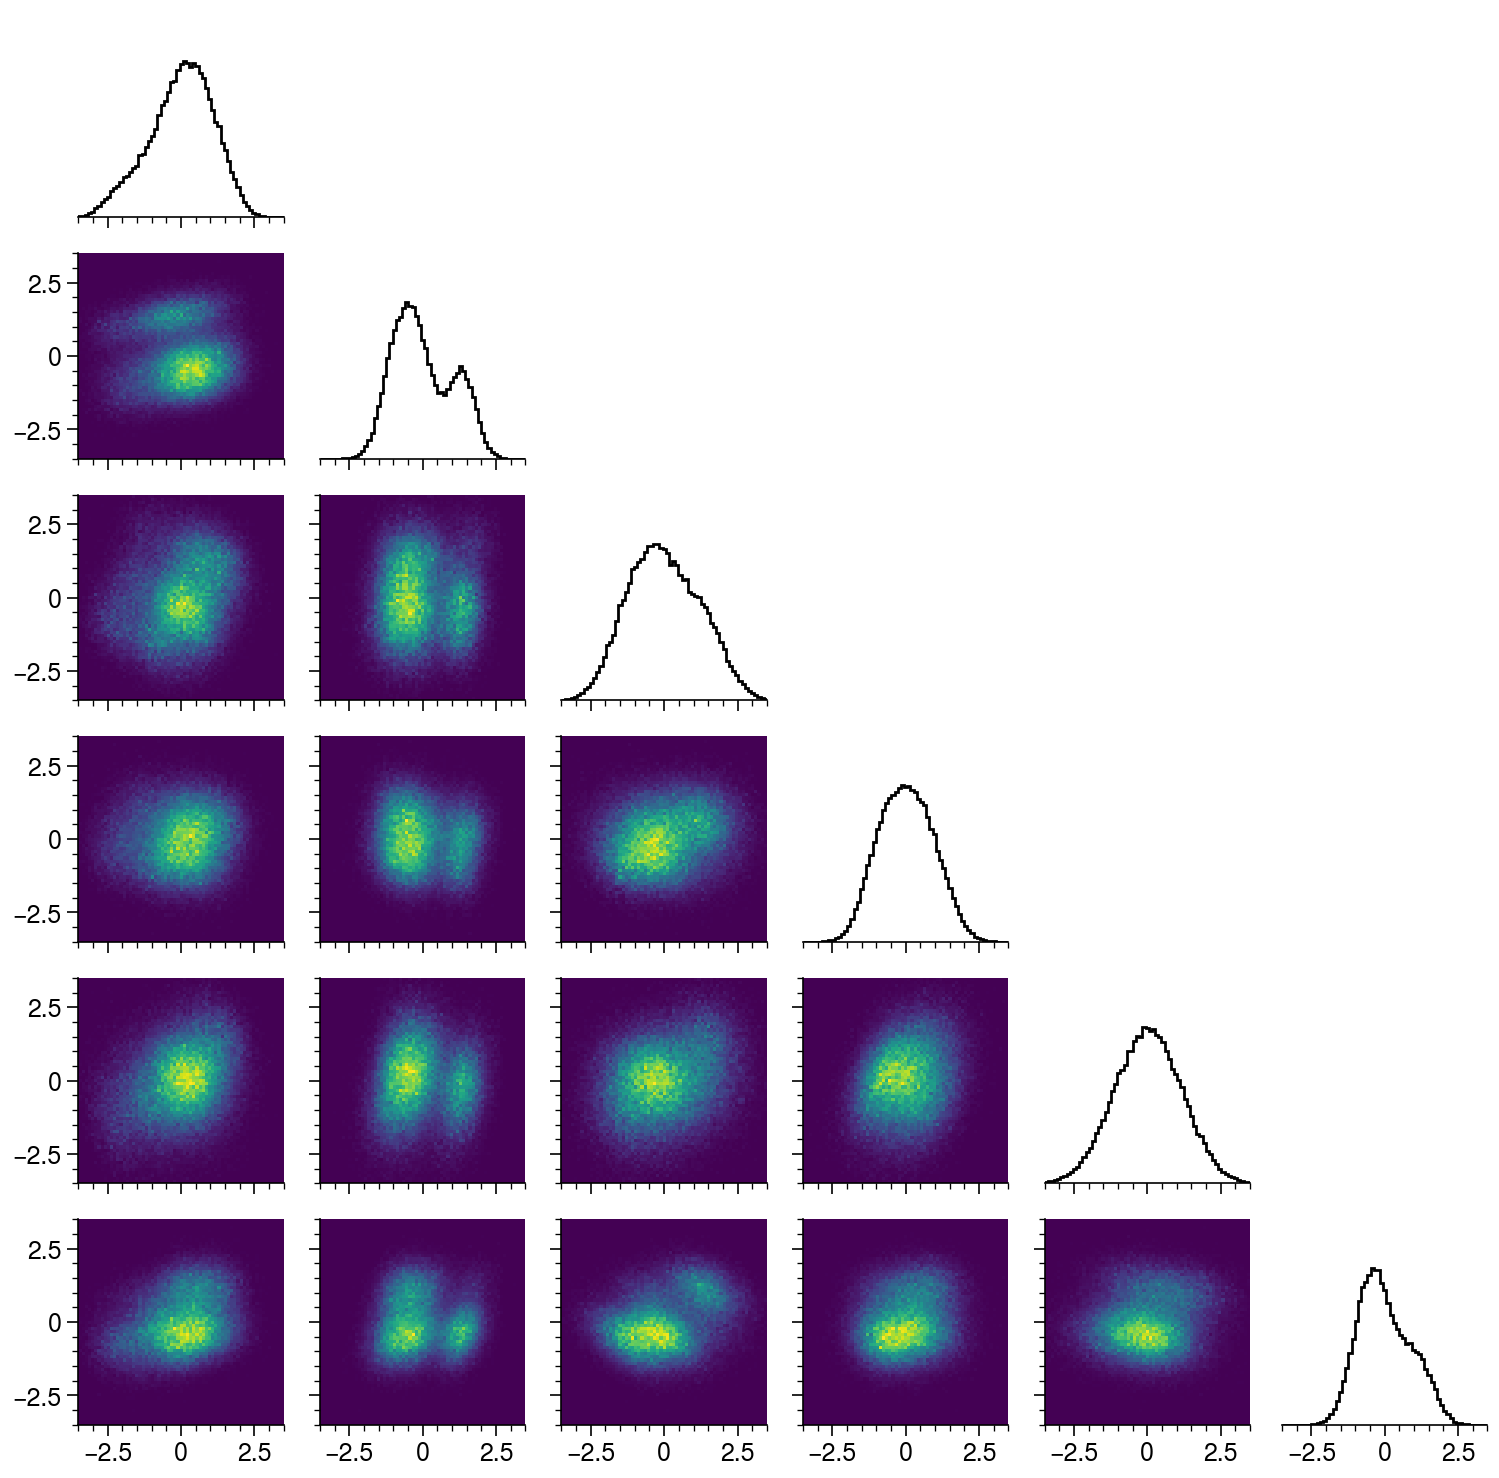

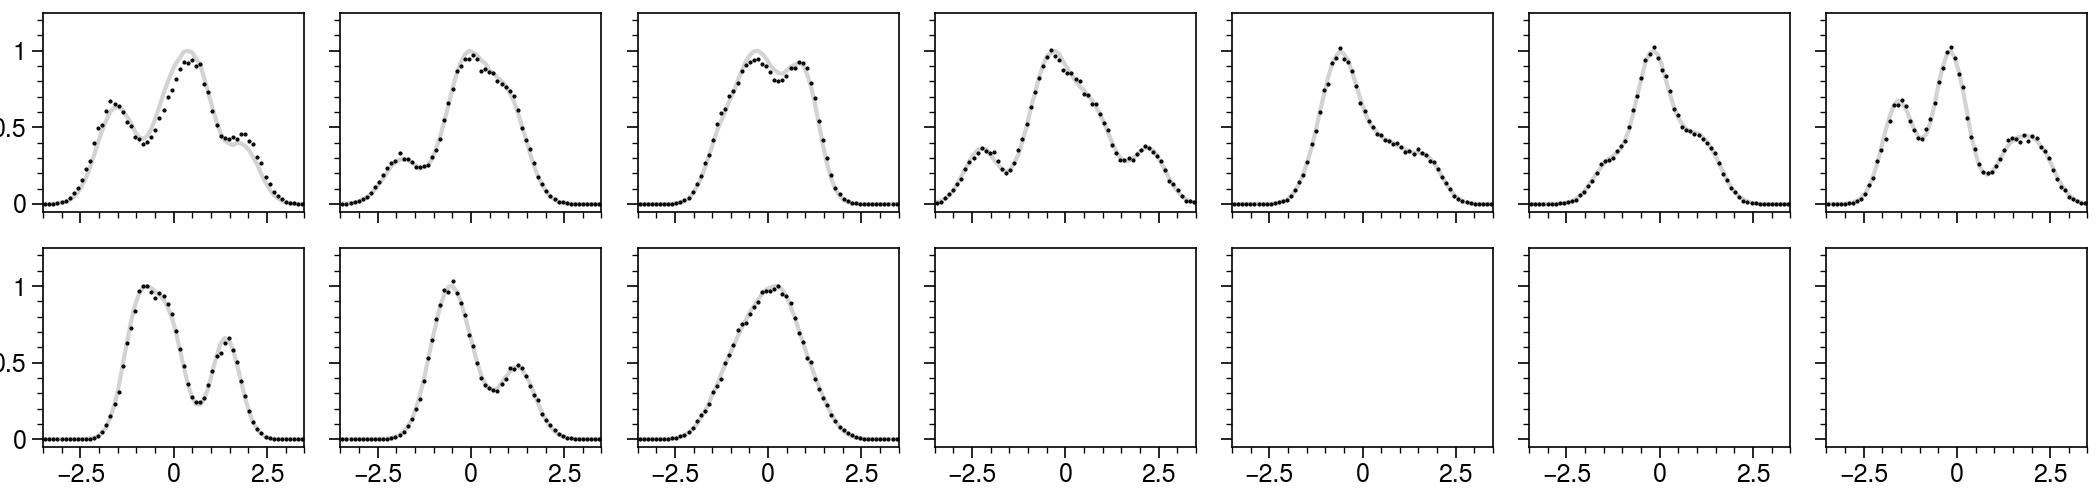

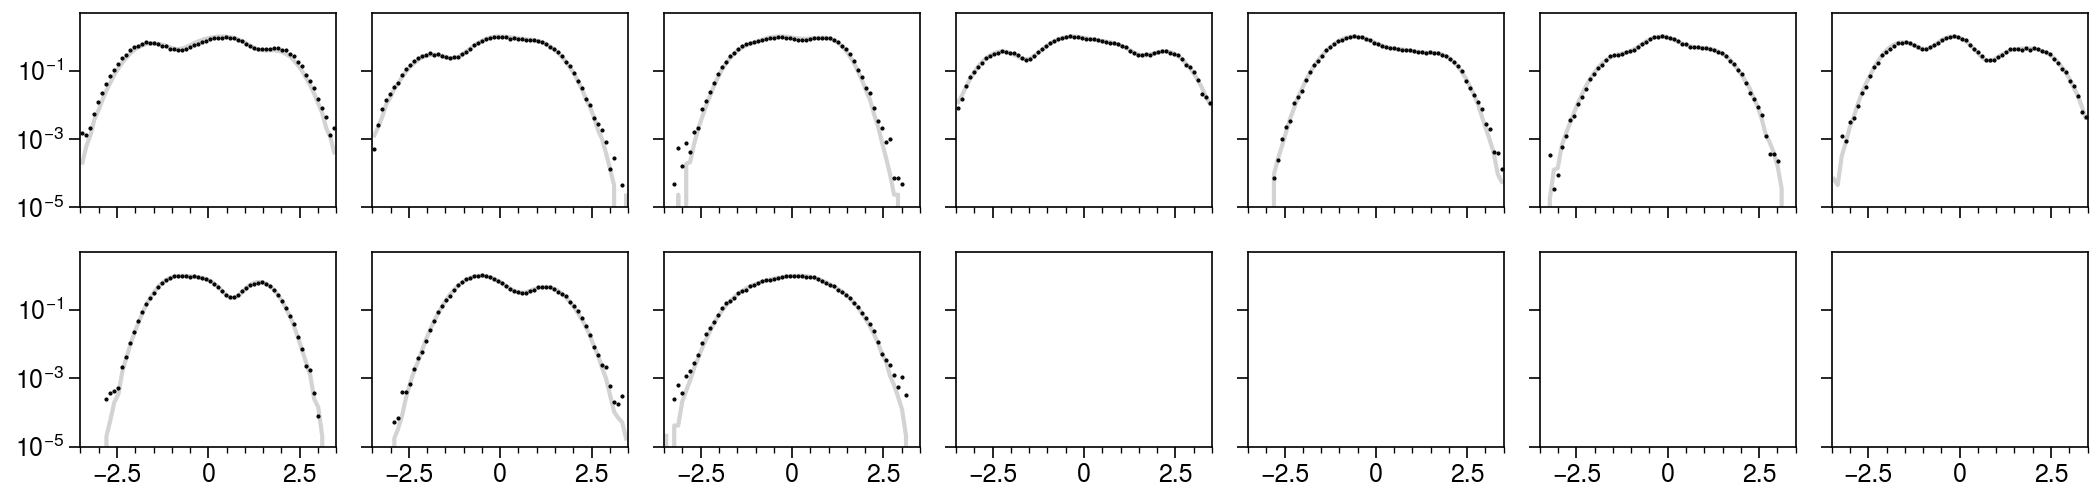

None


In [13]:
trainer = ment.train.Trainer(
    model,
    plot_func=plot_model,
    eval_func=None,
    notebook=True,
)

trainer.train(epochs=3, learning_rate=0.80)

## Evaluate

  0%|                                                                                                                                                                           | 0/14031 [00:00<?, ?it/s]

  2%|██▉                                                                                                                                                            | 262/14031 [00:00<00:05, 2616.39it/s]

  4%|█████▉                                                                                                                                                         | 525/14031 [00:00<00:05, 2622.24it/s]

  6%|████████▉                                                                                                                                                      | 788/14031 [00:00<00:05, 2617.52it/s]

  7%|███████████▊                                                                                                                                                  | 1050/14031 [00:00<00:05, 2587.47it/s]

  9%|██████████████▋                                                                                                                                               | 1309/14031 [00:00<00:04, 2549.65it/s]

 11%|█████████████████▌                                                                                                                                            | 1565/14031 [00:00<00:04, 2538.54it/s]

 13%|████████████████████▍                                                                                                                                         | 1819/14031 [00:00<00:04, 2523.97it/s]

 15%|███████████████████████▎                                                                                                                                      | 2072/14031 [00:00<00:04, 2516.49it/s]

 17%|██████████████████████████▏                                                                                                                                   | 2324/14031 [00:00<00:04, 2516.52it/s]

 18%|█████████████████████████████                                                                                                                                 | 2576/14031 [00:01<00:04, 2515.68it/s]

 20%|███████████████████████████████▊                                                                                                                              | 2828/14031 [00:01<00:04, 2510.63it/s]

 22%|██████████████████████████████████▋                                                                                                                           | 3080/14031 [00:01<00:04, 2509.39it/s]

 24%|█████████████████████████████████████▌                                                                                                                        | 3331/14031 [00:01<00:04, 2491.76it/s]

 26%|████████████████████████████████████████▎                                                                                                                     | 3581/14031 [00:01<00:04, 2485.75it/s]

 27%|███████████████████████████████████████████▏                                                                                                                  | 3830/14031 [00:01<00:04, 2472.00it/s]

 29%|█████████████████████████████████████████████▉                                                                                                                | 4078/14031 [00:01<00:04, 2383.94it/s]

 31%|████████████████████████████████████████████████▋                                                                                                             | 4327/14031 [00:01<00:04, 2413.08it/s]

 33%|███████████████████████████████████████████████████▌                                                                                                          | 4577/14031 [00:01<00:03, 2437.19it/s]

 34%|██████████████████████████████████████████████████████▍                                                                                                       | 4830/14031 [00:01<00:03, 2462.04it/s]

 36%|█████████████████████████████████████████████████████████▏                                                                                                    | 5080/14031 [00:02<00:03, 2471.82it/s]

 38%|████████████████████████████████████████████████████████████                                                                                                  | 5332/14031 [00:02<00:03, 2483.54it/s]

 40%|██████████████████████████████████████████████████████████████▉                                                                                               | 5585/14031 [00:02<00:03, 2495.82it/s]

 42%|█████████████████████████████████████████████████████████████████▋                                                                                            | 5837/14031 [00:02<00:03, 2500.54it/s]

 43%|████████████████████████████████████████████████████████████████████▌                                                                                         | 6089/14031 [00:02<00:03, 2504.53it/s]

 45%|███████████████████████████████████████████████████████████████████████▍                                                                                      | 6340/14031 [00:02<00:03, 2496.86it/s]

 47%|██████████████████████████████████████████████████████████████████████████▏                                                                                   | 6590/14031 [00:02<00:02, 2492.95it/s]

 49%|█████████████████████████████████████████████████████████████████████████████                                                                                 | 6840/14031 [00:02<00:02, 2473.16it/s]

 51%|███████████████████████████████████████████████████████████████████████████████▊                                                                              | 7088/14031 [00:02<00:02, 2391.08it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████▋                                                                           | 7339/14031 [00:02<00:02, 2425.51it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 7592/14031 [00:03<00:02, 2455.02it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 7844/14031 [00:03<00:02, 2473.35it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 8097/14031 [00:03<00:02, 2488.52it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                | 8350/14031 [00:03<00:02, 2499.43it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 8601/14031 [00:03<00:02, 2430.35it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 8845/14031 [00:03<00:02, 2380.24it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 9096/14031 [00:03<00:02, 2417.81it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 9349/14031 [00:03<00:01, 2448.26it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 9600/14031 [00:03<00:01, 2465.86it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 9854/14031 [00:03<00:01, 2485.97it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 10107/14031 [00:04<00:01, 2498.76it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 10358/14031 [00:04<00:01, 2501.92it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 10609/14031 [00:04<00:01, 2486.52it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 10858/14031 [00:04<00:01, 2478.49it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 11107/14031 [00:04<00:01, 2478.99it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 11357/14031 [00:04<00:01, 2482.37it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 11606/14031 [00:04<00:00, 2441.39it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 11851/14031 [00:04<00:00, 2367.07it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 12089/14031 [00:04<00:00, 2320.78it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 12335/14031 [00:04<00:00, 2360.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 12587/14031 [00:05<00:00, 2405.35it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 12843/14031 [00:05<00:00, 2449.25it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 13100/14031 [00:05<00:00, 2483.85it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 13360/14031 [00:05<00:00, 2516.87it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 13622/14031 [00:05<00:00, 2545.31it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 13883/14031 [00:05<00:00, 2563.49it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:05<00:00, 2479.75it/s]

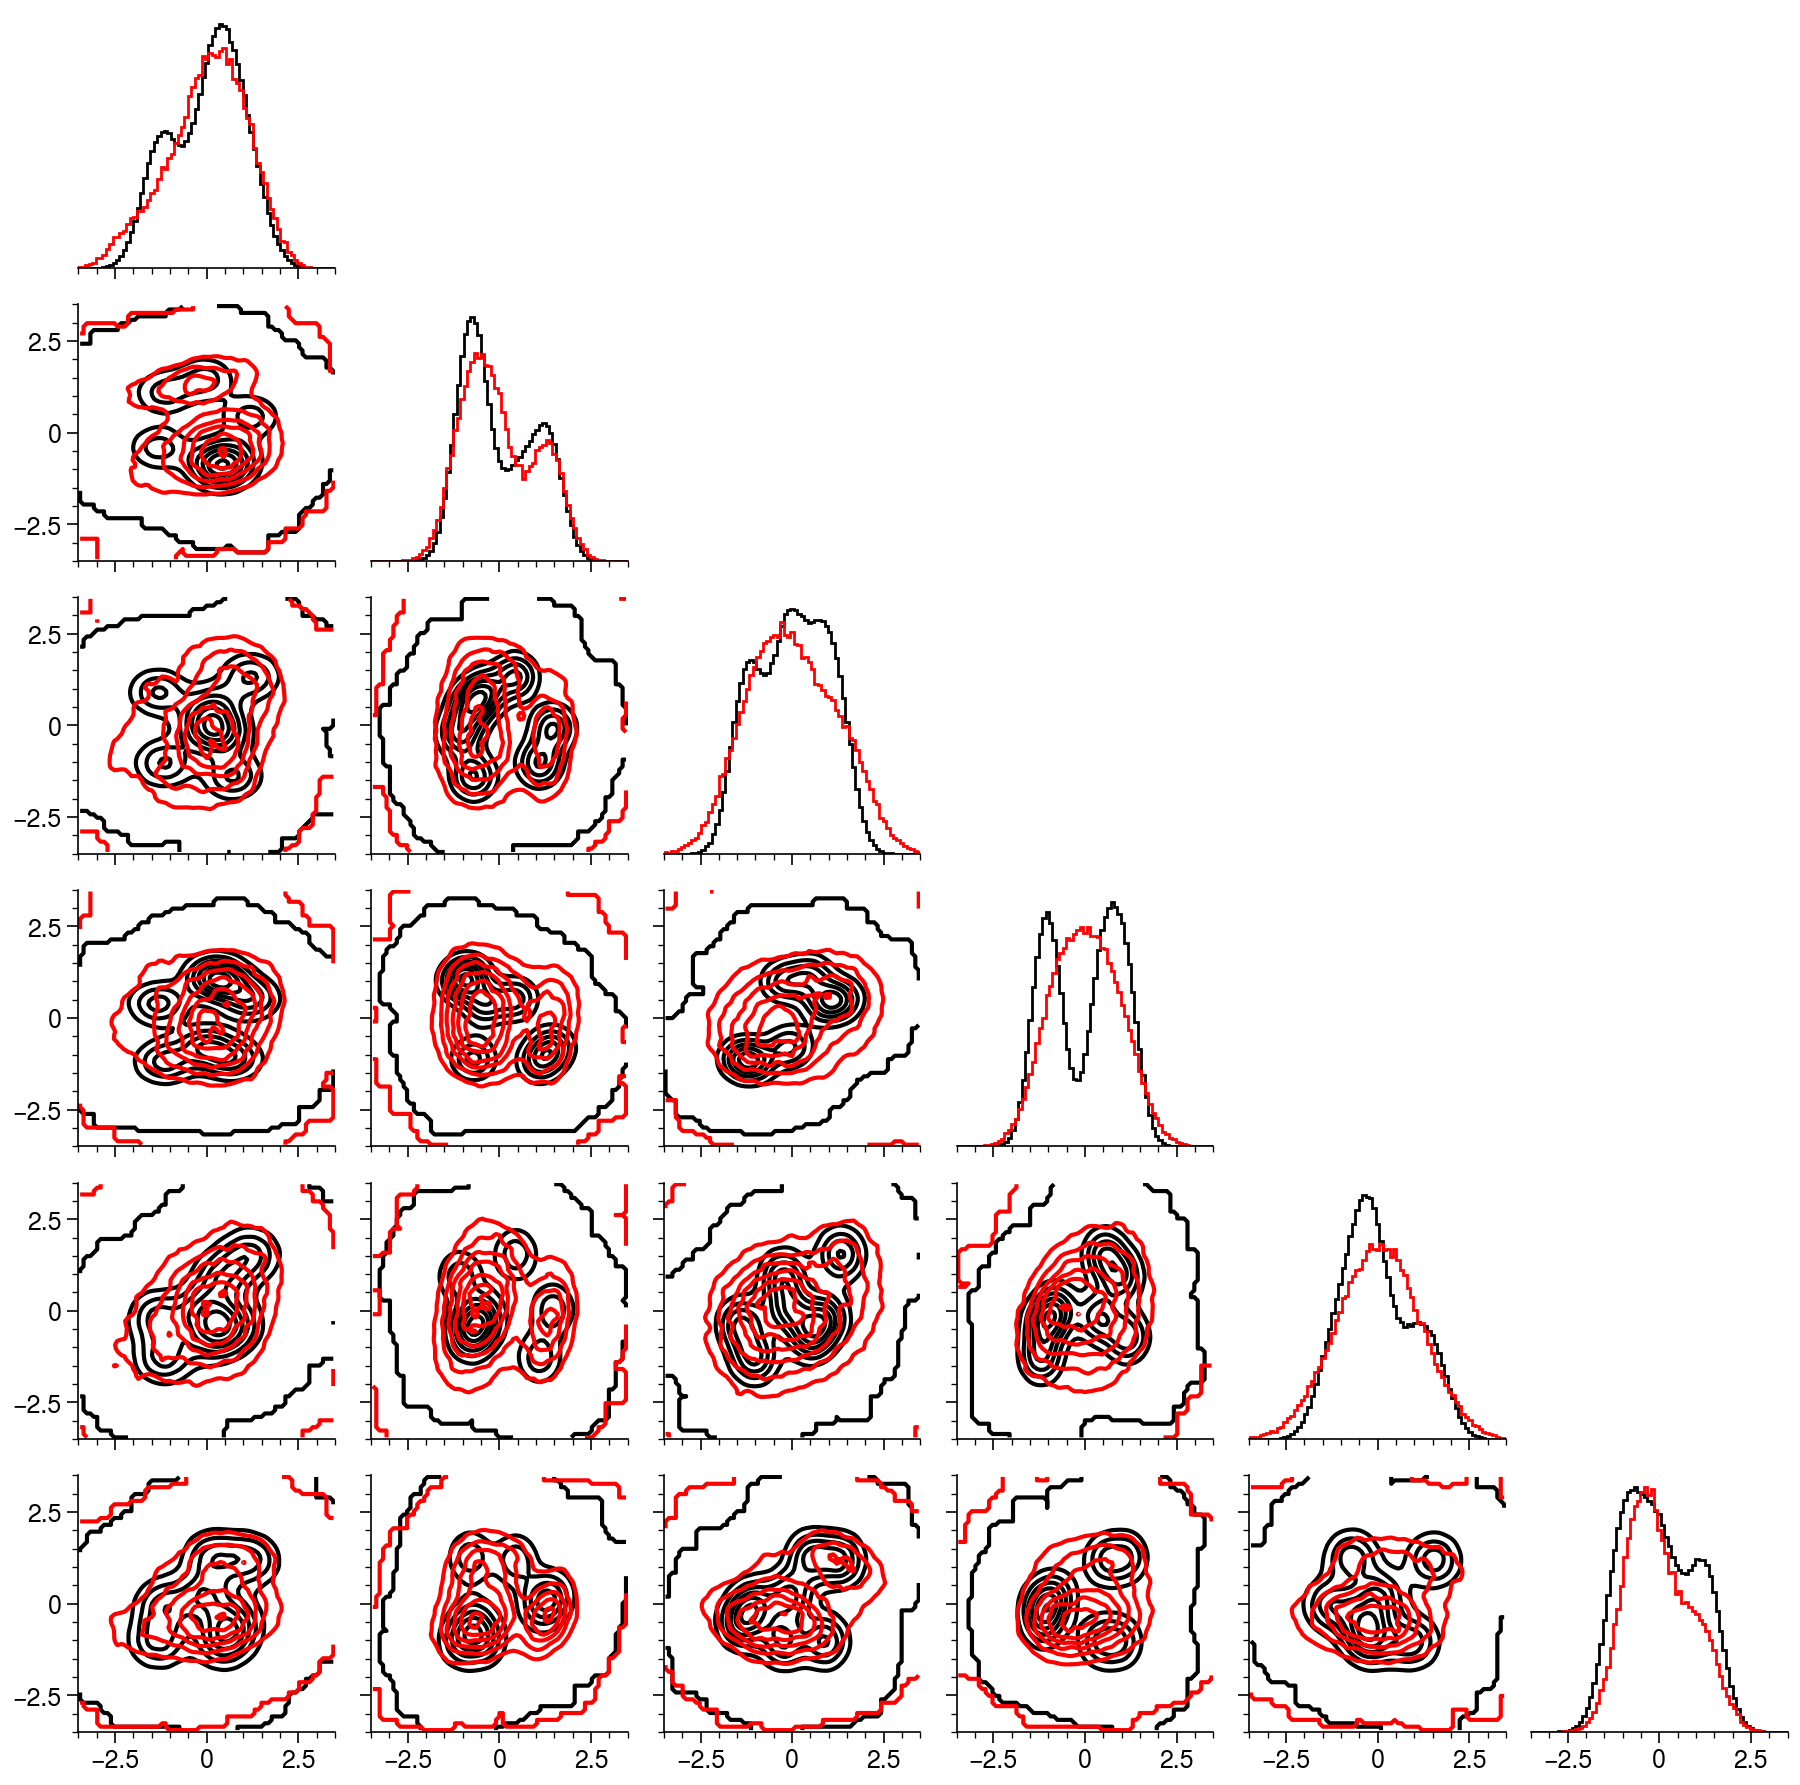

In [14]:
x_pred = model.unnormalize(model.sample(1_000_000))

grid = psv.CornerGrid(ndim, figwidth=(ndim * 1.5))
for x, color in zip([x_true, x_pred], ["black", "red"]):
    grid.plot(
        x,
        limits=limits,
        bins=75,
        diag_kws=dict(color=color),
        mask=False,
        kind="contour",
        process_kws=dict(blur=1.0),
        color=color,
        N=7,
    )
plt.show()